# Setting

In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import json
from anytree.importer import JsonImporter
from anytree import PreOrderIter

In [3]:
from scipy import stats
from scipy.stats import ttest_rel,ttest_ind,mannwhitneyu,wilcoxon,normaltest,shapiro,sem, spearmanr

import statsmodels.api as sm
import pylab as py

In [4]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [5]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
# data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir2 = home_dir + 'stat_model/'
R_out_dir = home_dir + 'R_analysis_data/'

In [6]:
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv', index_col=0) # first column is index 

data_choice_level['sqrt_leftover'] = np.sqrt(data_choice_level.leftover)
data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1
data_choice_level["step"] = data_choice_level.currNumCities/data_choice_level.allMAS

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) # 

with open(home_dir +'tree_data/undo_tree', 'r') as file:
    undo_tree = json.load(file)

In [7]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv') # first column is subject

puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

# add branching-node RT to puzzle data
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

for i in range(len(subjects_chosen)): #
    index_chosen = puzzleID_order_data.index[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])]
    puzzleID_order_data.loc[index_chosen,'RT_branching'] = RT_branching[i]
puzzleID_order_data['RT_branching'] = puzzleID_order_data['RT_branching']/1000

puzzleID_order_data['sqrt_nos'] = np.sqrt(puzzleID_order_data.nos)
puzzleID_order_data['log_RT1'] = np.log(puzzleID_order_data.RT1)
puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

In [8]:
# undo condition
# select the data before the very first undo or submit
data_subset_before1undo_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]     

        for i in range(len(dat_sbj_pzi)):
            if (dat_sbj_pzi.iloc[i]['undo'] != 1)&(dat_sbj_pzi.iloc[i]['submit'] != 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
            elif (dat_sbj_pzi.iloc[i]['undo'] == 1)|(dat_sbj_pzi.iloc[i]['submit'] == 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
                break

data_subset_before1undo = sc_data_choice_level.loc[data_subset_before1undo_index,:]

In [9]:
# undo condition
# select the data before the very first undo only
data_subset_before1undoonly_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]   
        temp_list = []  

        for i in range(len(dat_sbj_pzi)):
            if dat_sbj_pzi.iloc[i]['undo'] != 1:
                temp_list.append(dat_sbj_pzi.index[i])
            elif dat_sbj_pzi.iloc[i]['undo'] == 1:
                data_subset_before1undoonly_index.extend(temp_list)
                break

data_subset_before1undoonly = sc_data_choice_level.loc[data_subset_before1undoonly_index,:]

In [10]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y

single_condition_data['sqrt_leftover'] = np.sqrt(single_condition_data.leftover)
single_condition_data['sqrt_numFullUndo'] = np.sqrt(single_condition_data.numFullUndo)
# single_condition_data['percentile_numFullUndo'] = single_condition_data.numFullUndo.rank(method='min')

In [11]:
# helper functions
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if p == 0:
        axs.text((x1+x2)*.5, y+h,  r"$p = {:.1f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"$p = {0:s}$".format(as_si(p,1)), ha='center', va='bottom', color=col, fontsize = 8)
    elif p > 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.2f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

    elif 0.01 < p < 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.3f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.4f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

In [11]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
#lmerTest = importr('lmerTest')
#optimx = importr('optimx')
#brms = importr('brms')
statmod = importr('statmod')
# bbmle = importr('bbmle') 

# More undos at the end

In [13]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_bf = sc_data_choice_level.index[(sc_data_choice_level.submit!=1)&(sc_data_choice_level.currNumCities!=0)]
state_df = sc_data_choice_level.loc[index_bf, ["subjects", "allMAS", "within_reach", "currNumCities", "sqrt_leftover", "checkEnd", "step"]]
state_df = state_df.reset_index(drop=True)
state_df["firstUndo"] = list(sc_data_choice_level.loc[index_bf+1, "firstUndo"])
state_df

subjects  allMAS  within_reach  currNumCities  sqrt_leftover  checkEnd  \
0             0      10            24              1      16.240408         0   
1             0      10            20              2      15.701790         0   
2             0      10            15              3      15.165529         0   
3             0      10            14              4      14.792327         0   
4             0      10            11              5      14.414145         0   
...         ...     ...           ...            ...            ...       ...   
57528        99       7             7              3       8.690482         0   
57529        99       7             5              4       7.511292         0   
57530        99       7             2              5       6.149670         0   
57531        99       7             1              6       4.301770         0   
57532        99       7             0              7       2.338124         1   

           step  firstUndo  
0      0.100000          0  
1      0.200000          0  
2      0.300000          0  
3      0.400000          0  
4      0.500000          0  
...         ...        ...  
57528  0.428571          0  
57529  0.571429          0  
57530  0.714286          0  
57531  0.857143          0  
57532  1.000000          0  

[57533 rows x 8 columns]

In [14]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_bf_1undo = data_subset_before1undo.index[(data_subset_before1undo.submit!=1)&(data_subset_before1undo.currNumCities!=0)]

state_df_1undo = data_subset_before1undo.loc[index_bf_1undo, ["subjects", "allMAS", "within_reach", "currNumCities", "sqrt_leftover", "checkEnd", "step"]]
state_df_1undo = state_df_1undo.reset_index(drop=True)
state_df_1undo["firstUndo"] = list(sc_data_choice_level.loc[index_bf_1undo+1, "firstUndo"])
state_df_1undo

subjects  allMAS  within_reach  currNumCities  sqrt_leftover  checkEnd  \
0             0       8            26              1      13.961342         0   
1             0       8            21              2      12.298834         0   
2             0       8            15              3      10.762027         0   
3             0       8            12              4      10.187229         0   
4             0       8             9              5       9.611341         0   
...         ...     ...           ...            ...            ...       ...   
35341        99       9             8              5       9.801398         0   
35342        99       9             5              6       8.721663         0   
35343        99       9             2              7       7.384223         0   
35344        99       9             1              8       5.317701         0   
35345        99       9             0              9       2.855403         1   

           step  firstUndo  
0      0.125000          0  
1      0.250000          0  
2      0.375000          0  
3      0.500000          0  
4      0.625000          0  
...         ...        ...  
35341  0.555556          0  
35342  0.666667          0  
35343  0.777778          0  
35344  0.888889          0  
35345  1.000000          0  

[35346 rows x 8 columns]

#### Number of cities within reach

##### fixed effect

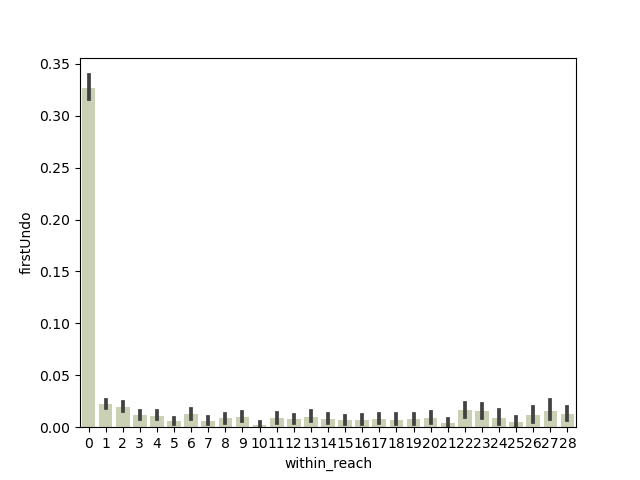

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='within_reach', y='firstUndo', data = state_df, color = '#ccd5ae') 

##### GLM

In [ ]:
%%R -i state_df

state_df$subjects <- factor(state_df$subjects)
state_df$firstUndo <- factor(state_df$firstUndo)

model_undo <- lme4::glmer(firstUndo ~  1 + within_reach + (1|subjects),
                  data = state_df, family = binomial)
# model_undo <- glm(firstUndo ~  1 + within_reach,
#                   data = data_subset, family = binomial)
# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + within_reach + (1 | subjects)
   Data: data_subset

     AIC      BIC   logLik deviance df.resid 
 19028.6  19055.7  -9511.3  19022.6    62124 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.494 -0.252 -0.149 -0.081 41.008 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.22     1.105   
Number of obs: 62127, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.020839   0.119669  -25.24   <2e-16 ***
within_reach -0.131556   0.004229  -31.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
within_rech -0.118


#### § Move number

##### fixed effect

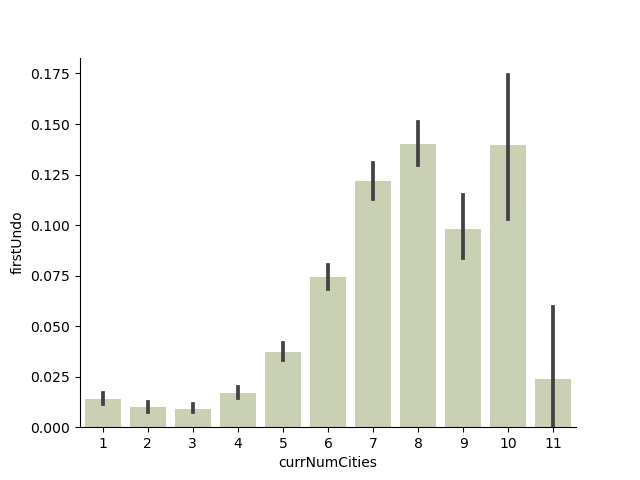

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='currNumCities', y='firstUndo', data = state_df, color = '#ccd5ae') 

##### § random effect

currNumCities  allMAS  firstUndo
0               1       8        100
1               1       9        100
2               2       8        100
3               2       9        100
4               3       8        100
5               3       9        100
6               4       8        100
7               4       9        100
8               5       8        100
9               5       9        100
10              6       8        100
11              6       9        100
12              7       8         99
13              7       9        100
14              8       8         98
15              8       9        100
16              9       9         98

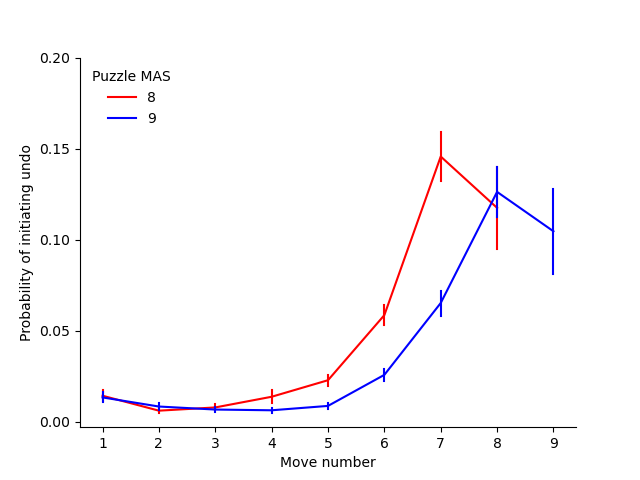

In [ ]:
firstUndo_sub = state_df.groupby(['subjects','currNumCities',"allMAS"])['firstUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', hue = "allMAS", 
             data = firstUndo_sub.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', 
        ylabel='Probability of initiating undo')
# set y ticks with step of 0.05
axs.set_yticks(np.arange(0, 0.25, 0.05))
#axs.set_ylim(0,0.2,0.5)
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
firstUndo_sub.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:].groupby(['currNumCities',"allMAS"])['firstUndo'].count().reset_index()

currNumCities  allMAS  firstUndo
0               1       8        100
1               1       9        100
2               2       8        100
3               2       9        100
4               3       8        100
5               3       9        100
6               4       8        100
7               4       9        100
8               5       8        100
9               5       9        100
10              6       8        100
11              6       9        100
12              7       8         99
13              7       9        100
14              8       8         98
15              8       9        100
16              9       9         98

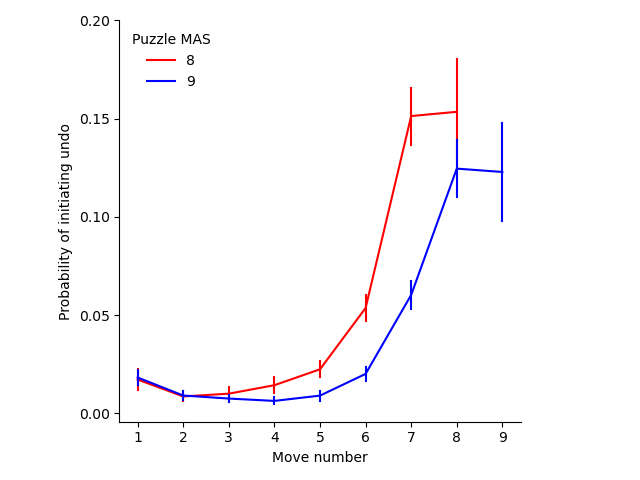

In [ ]:
firstUndo_sub = state_df_1undo.groupby(['subjects','currNumCities',"allMAS"])['firstUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', hue = "allMAS", 
             data = firstUndo_sub.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set_yticks(np.linspace(0,0.2,5))
axs.set(xlabel='Move number', 
        ylabel='Probability of initiating undo')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
firstUndo_sub.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:].groupby(['currNumCities',"allMAS"])['firstUndo'].count().reset_index()

### Step

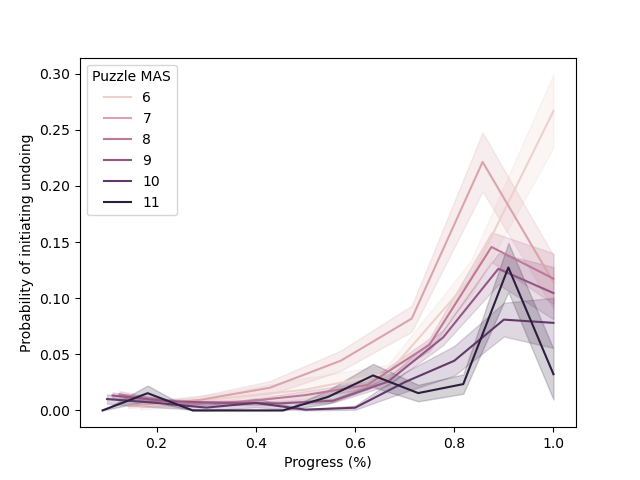

In [ ]:
firstUndo_sub = state_df.groupby(['subjects','step',"allMAS"])['firstUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='step', y='firstUndo', hue = "allMAS", data = firstUndo_sub, errorbar = "se")
axs.set(xlabel='Progress (%)', ylabel='Probability of initiating undoing')
# set legend title
axs.legend(title = "Puzzle MAS")

### Remaining budget

##### scatter plot

Text(0, 0.5, 'firstUndo')

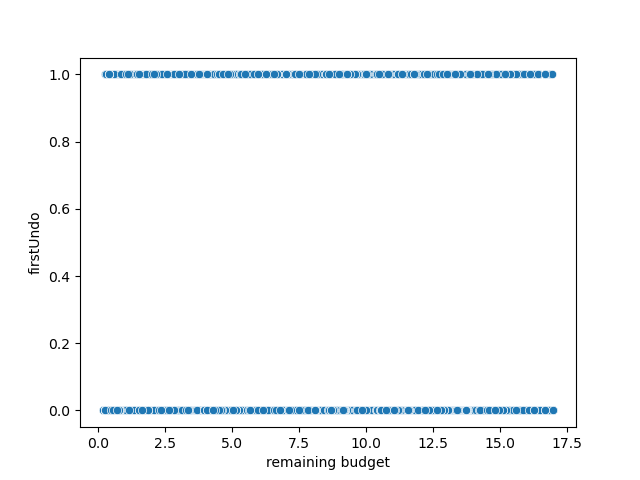

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()
sns.scatterplot(x='sqrt_leftover', y='firstUndo', data=data_subset) 
ax1.set_xlabel("remaining budget")
ax1.set_ylabel("firstUndo")

##### GLM

In [ ]:
%%R -i data_subset

data_subset$subjects <- as.factor(data_subset[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + sqrt_leftover + (1 |subjects),
                                  data = data_subset, family = "binomial")

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + sqrt_leftover + (1 | subjects)
   Data: data_subset

     AIC      BIC   logLik deviance df.resid 
 19874.1  19901.2  -9934.1  19868.1    62124 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6228 -0.2383 -0.1770 -0.1150 18.3639 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.207    1.099   
Number of obs: 62127, groups:  subjects, 100

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.574968   0.125289  -20.55   <2e-16 ***
sqrt_leftover -0.133812   0.005293  -25.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sqrt_leftvr -0.330


### § Terminal state/ Non-terminal state

##### plot

In [15]:
state_df_1undo_sub = state_df_1undo[(state_df_1undo.allMAS==8)|(state_df_1undo.allMAS==9)]
undo_end_sub = state_df_1undo_sub[state_df_1undo_sub.checkEnd==1].groupby(['subjects'])['firstUndo'].mean()
undo_notend_sub = state_df_1undo_sub[state_df_1undo_sub.checkEnd==0].groupby(['subjects'])['firstUndo'].mean()
print(len(undo_end_sub))
print(len(undo_notend_sub))

100
100


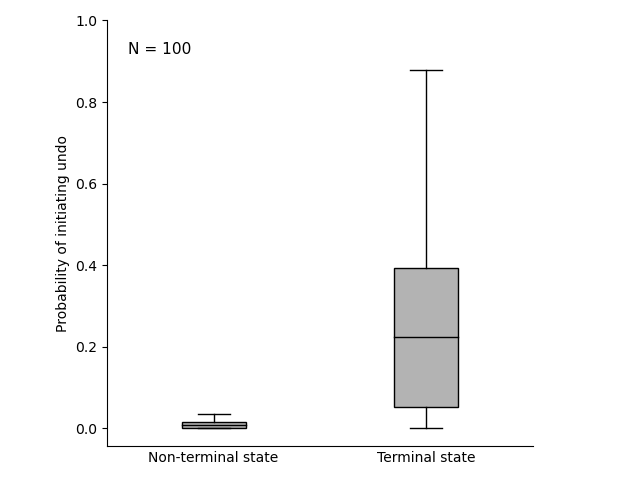

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
# axs.bar([1,2,3,4],np.nanmean(dat_subjects,axis = 0),
#         color=['#ccd5ae','#ccd5ae','#fefae0','#fefae0'],
#         hatch=['//','','//',''],edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [np.array(undo_notend_sub), np.array(undo_end_sub)],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    patch_artist=True,
    whis = 1.5,
    medianprops = dict(color = 'k'))  #

for patch in bx['boxes']:
    patch.set_facecolor([.7,.7,.7])

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Non-terminal state',
                              'Terminal state'])#,fontsize=18
axs.tick_params(axis='x', which='both',length=0)

axs.set_yticks(np.linspace(0,1,6))
axs.set_ylabel('Probability of initiating undo')

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
      fontsize=11,  va='top')

axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

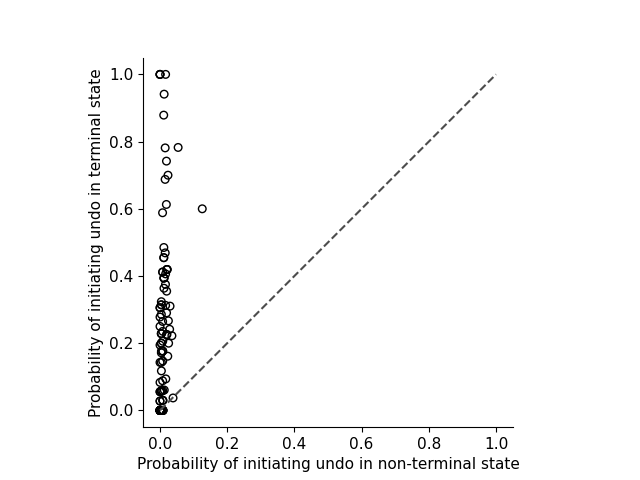

In [21]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(undo_notend_sub), 
            np.array(undo_end_sub), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Probability of initiating undo in non-terminal state')
axs.set_ylabel('Probability of initiating undo in terminal state')

axs.set_ylim([-0.05,1.05])
axs.set_xlim([-0.05,1.05])

# add diagonal line
axs.plot([0,1], [0,1], ls="--", c=".3")

# add text on upper left corner of the plot
# axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
#         fontsize=11,  va='top')

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

0.2669240927236181
0.015217854631966633


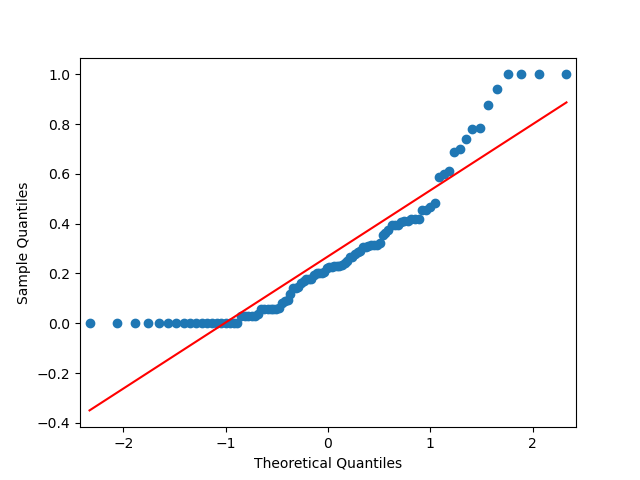

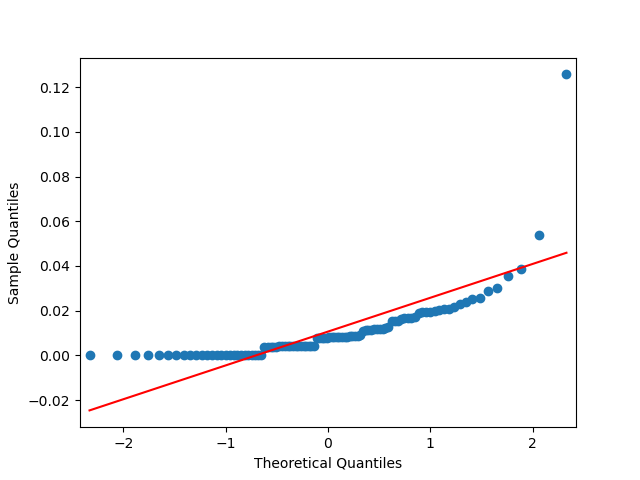

36.0
1.2724551734179578e-15


Text(0.5, 1.0, '$p = 1.3\\times 10^{-15}$')

In [ ]:
# check equal variance ----
print(np.std(undo_end_sub, ddof=1))
print(np.std(undo_notend_sub, ddof=1))
## violated

# check normality ----
sm.qqplot(undo_end_sub, line='s')
py.show()
sm.qqplot(undo_notend_sub, line='s')
py.show()
## violated

stat1, p1 = mannwhitneyu(np.array(undo_end_sub), np.array(undo_notend_sub)) # should not be paired test! Because of unequal variance, and the measurements are rather unrelated
print(stat1)
print(p1)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

##### GLM

In [ ]:
df_end_undo["type"] = "terminal"
df_notend_undo["type"] = "non-terminal"
undo_end_df = pd.concat([df_end_undo, df_notend_undo])

In [ ]:
%%R -i undo_end_df

undo_end_df$subject <- factor(undo_end_df$subject)

model_undo_end = lme4::glmer(firstUndo ~  1 + type + (1 |subjects),
                                  data = undo_end_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_undo_end)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + type + (1 | subjects)
   Data: undo_end_df

     AIC      BIC   logLik deviance df.resid 
 11975.7  12002.5  -5984.8  11969.7    56319 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.596 -0.128 -0.086 -0.055 43.984 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 2.055    1.433   
Number of obs: 56322, groups:  subjects, 100

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -5.6873     0.1579  -36.01   <2e-16 ***
typeterminal   4.3383     0.0582   74.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
typeterminl -0.300


# Dissatisfaction when there are no errors

## § all first undo

In [ ]:
# na can happen in branching_RT because there may be "fake undo"
def filter_dataframe(df, col1_list, col2_list):
    RT1 = []
    RT_branching = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            RT1.append(float(temp.loc[:,"RT1"].values))
            RT_branching.append(float(temp.loc[:,"RT_branching"].values))
        if temp.empty:
            RT1.append(np.nan)
            RT_branching.append(np.nan)
    return RT1, RT_branching

def filter_dataframe_TT(df, col1_list, col2_list):
    TT = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            TT.append(float(temp.loc[:,"TT"].values))
        if temp.empty:
            TT.append(np.nan)
    return TT

# before undo
index_first_undo =  sc_data_choice_level.index[sc_data_choice_level['firstUndo'] == 1] 
df_beforeUndo = sc_data_choice_level.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)&(df_beforeUndo.currMas == df_beforeUndo.allMAS)] # there are no errors and  end of trial
state_undo = df_beforeUndo.loc[index_end_undo, ['leftover','currNumCities','subjects','puzzleID']]
state_undo['lastRT'] = sc_data_choice_level.loc[index_end_undo+1, 'RT'].values
state_undo['lastRT_log'] = np.log(sc_data_choice_level.loc[index_end_undo+1, 'RT'].values/1000+1)
state_undo = state_undo.drop_duplicates()

subjects_undo = list(state_undo['subjects'])
puzzleID_undo = list(state_undo['puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition']==0].copy(), subjects_undo, puzzleID_undo)
state_undo["RT1"] = RT1
state_undo["RT_branching"] = RT_branching
state_undo["TT"] = TT
state_undo['firstUndo'] = 1

# before submit
index_notundo = sc_data_choice_level.index[(sc_data_choice_level['submit'] == 1)] # submit
df_notbeforeUndo = sc_data_choice_level.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)&(df_notbeforeUndo.currMas == df_notbeforeUndo.allMAS)]
state_notundo = df_notbeforeUndo.loc[index_end_notundo,['leftover','currNumCities','subjects','puzzleID']]
state_notundo['lastRT'] = sc_data_choice_level.loc[index_end_notundo+1, 'RT'].values
state_notundo['lastRT_log'] = np.log(sc_data_choice_level.loc[index_end_notundo+1, 'RT'].values/1000+1)
state_notundo = state_notundo.drop_duplicates()

subjects = list(state_notundo['subjects'])
puzzleID = list(state_notundo['puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition']==0].copy(), subjects, puzzleID)
state_notundo["RT1"] = RT1
state_notundo["RT_branching"] = RT_branching
state_notundo["TT"] = TT
state_notundo['firstUndo'] = 0

state_notundo = state_notundo[~(state_notundo['subjects'].isin(subjects_undo) & state_notundo['puzzleID'].isin(puzzleID_undo))] # only use those which directly submit

state_df = pd.concat([state_undo,state_notundo])
# bin leftover into 5 bins and create a new column
temp1, cutoff = pd.cut(state_df['leftover'], bins=[0,7,14,21,28,35,42], labels=range(1,7),retbins=True)
state_df['leftover_bin'] = temp1
# get the cutoffs for each bin
state_df = state_df.reset_index(drop=True)


In [ ]:
state_df

leftover  currNumCities  subjects  puzzleID  lastRT  lastRT_log  \
0      8.622047              7         0        19    8789    9.081370   
1     24.281846              9         0        32    4159    8.333270   
2     14.438090              8         2        42    4137    8.327968   
3     20.819878              6         2         1    2084    7.642524   
4      8.621321              8         2        15    3471    8.152486   
...         ...            ...       ...       ...     ...         ...   
1272  21.994079              8        98        38    1021    6.929517   
1273   3.511872              8        98        20    1032    6.940222   
1274  30.247948              9        98        32     886    6.787845   
1275  10.842372              8        98         7    1046    6.953684   
1276  10.728280              8        98        28    1177    7.071573   

         RT1  RT_branching      TT  firstUndo leftover_bin  
0      5.159         8.232  40.552          1            2  
1      3.113         2.159  20.823          1            4  
2     12.393        12.393  21.167          1            3  
3     12.950         1.649  22.238          1            3  
4      5.674         1.745  17.975          1            2  
...      ...           ...     ...        ...          ...  
1272   2.211           NaN  19.749          0            4  
1273   2.559           NaN  17.661          0            1  
1274   2.388           NaN  19.991          0            5  
1275   5.172           NaN  19.882          0            2  
1276   2.380           NaN  12.365          0            2  

[1277 rows x 11 columns]

## § very first undo

In [ ]:
# for RT1 and RT_branching, use only the very first undo
    
# before undo
index_first_undo = data_subset_before1undo.index[(data_subset_before1undo['firstUndo'] == 1)] # submit
df_beforeUndo = data_subset_before1undo.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)&(df_beforeUndo.currMas == df_beforeUndo.allMAS)] # there are no errors and  end of trial
state_undo_1undo = df_beforeUndo.loc[index_end_undo, ['subjects','puzzleID']]

subjects_undo = list(df_beforeUndo.loc[index_end_undo,'subjects'])
puzzleID_undo = list(df_beforeUndo.loc[index_end_undo,'puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
state_undo_1undo["RT1"] = RT1
# take log of RT1 as a new column
state_undo_1undo["RT1_log"] = np.log(state_undo_1undo["RT1"]+1)
state_undo_1undo["RT_branching"] = RT_branching
state_undo_1undo['firstUndo'] = 1

# before submit
index_notundo = data_subset_before1undo.index[(data_subset_before1undo['submit'] == 1)] # submit
df_notbeforeUndo = data_subset_before1undo.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)&(df_notbeforeUndo.currMas == df_notbeforeUndo.allMAS)]
state_notundo_1undo = df_notbeforeUndo.loc[index_end_notundo,['subjects','puzzleID']]

subjects = list(df_notbeforeUndo.loc[index_end_notundo,'subjects'])
puzzleID = list(df_notbeforeUndo.loc[index_end_notundo,'puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
state_notundo_1undo["RT1"] = RT1
state_notundo_1undo["RT1_log"] = np.log(state_notundo_1undo["RT1"]+1)
state_notundo_1undo["RT_branching"] = RT_branching 
state_notundo_1undo['firstUndo'] = 0

state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1
state_df_1undo = state_df_1undo.reset_index(drop=True)
max(state_df_1undo['rt1_bin'])

5

## Achieved score

### Histogram

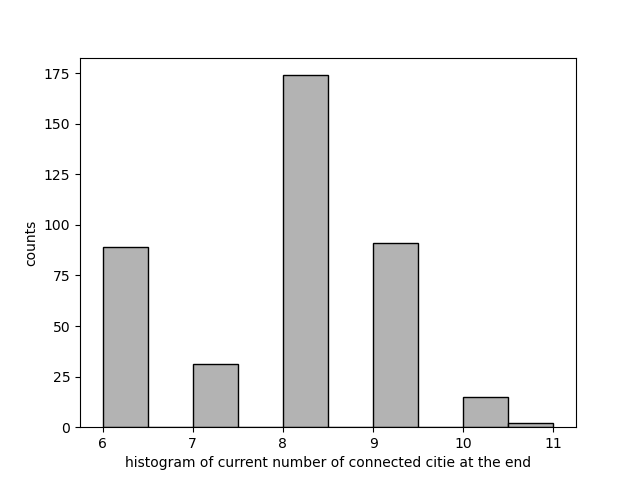

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
axs.hist(state_undo.currNumCities,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('histogram of current number of connected citie at the end') 
plt.show()

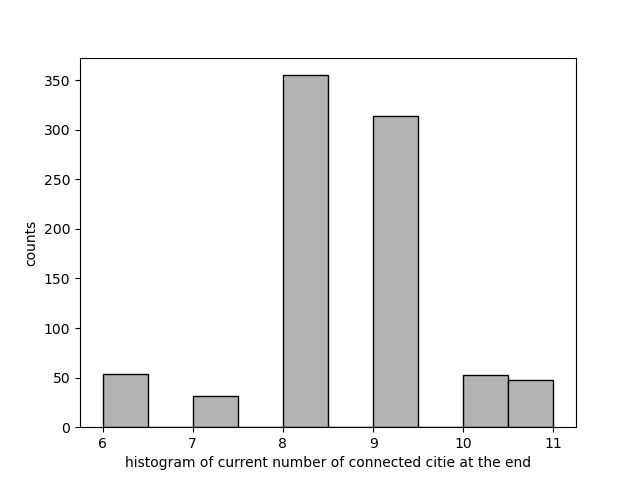

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
axs.hist(state_notundo.currNumCities,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('histogram of current number of connected citie at the end') 
plt.show()

### plot of current number of connected citie before submit/undo + t-test

####  fixed effect

<IPython.core.display.Javascript object>


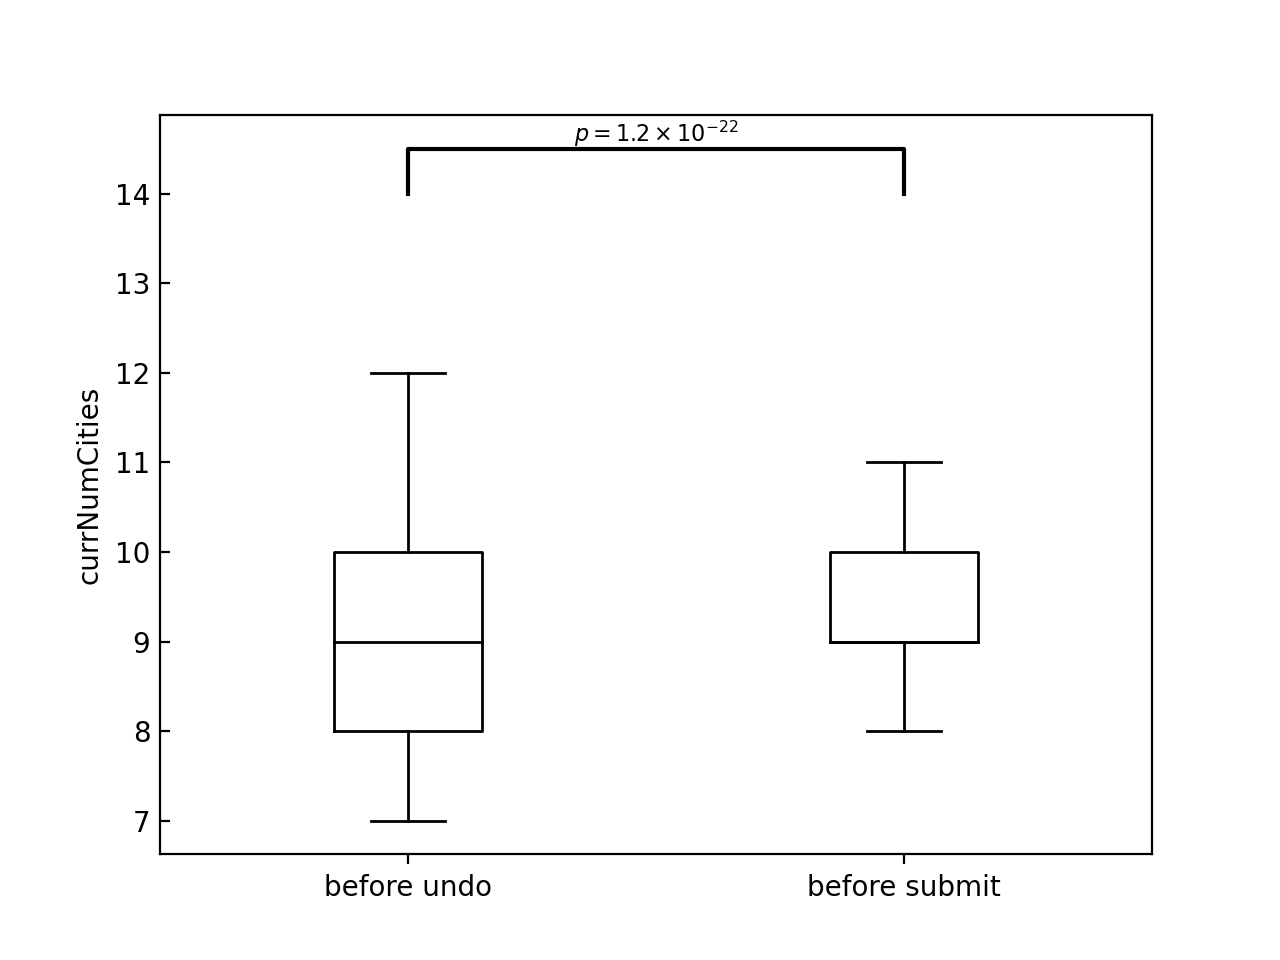

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot([currNumCities_undo,currNumCities_notundo],
   positions =[1,2],widths = 0.3,showfliers=False,whis = 1.5,
   medianprops = dict(color = 'k'))  #
#--------------------------------------
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['before undo','before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('currNumCities') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

1.1667035204431213
1.0447372507459478


<IPython.core.display.Javascript object>


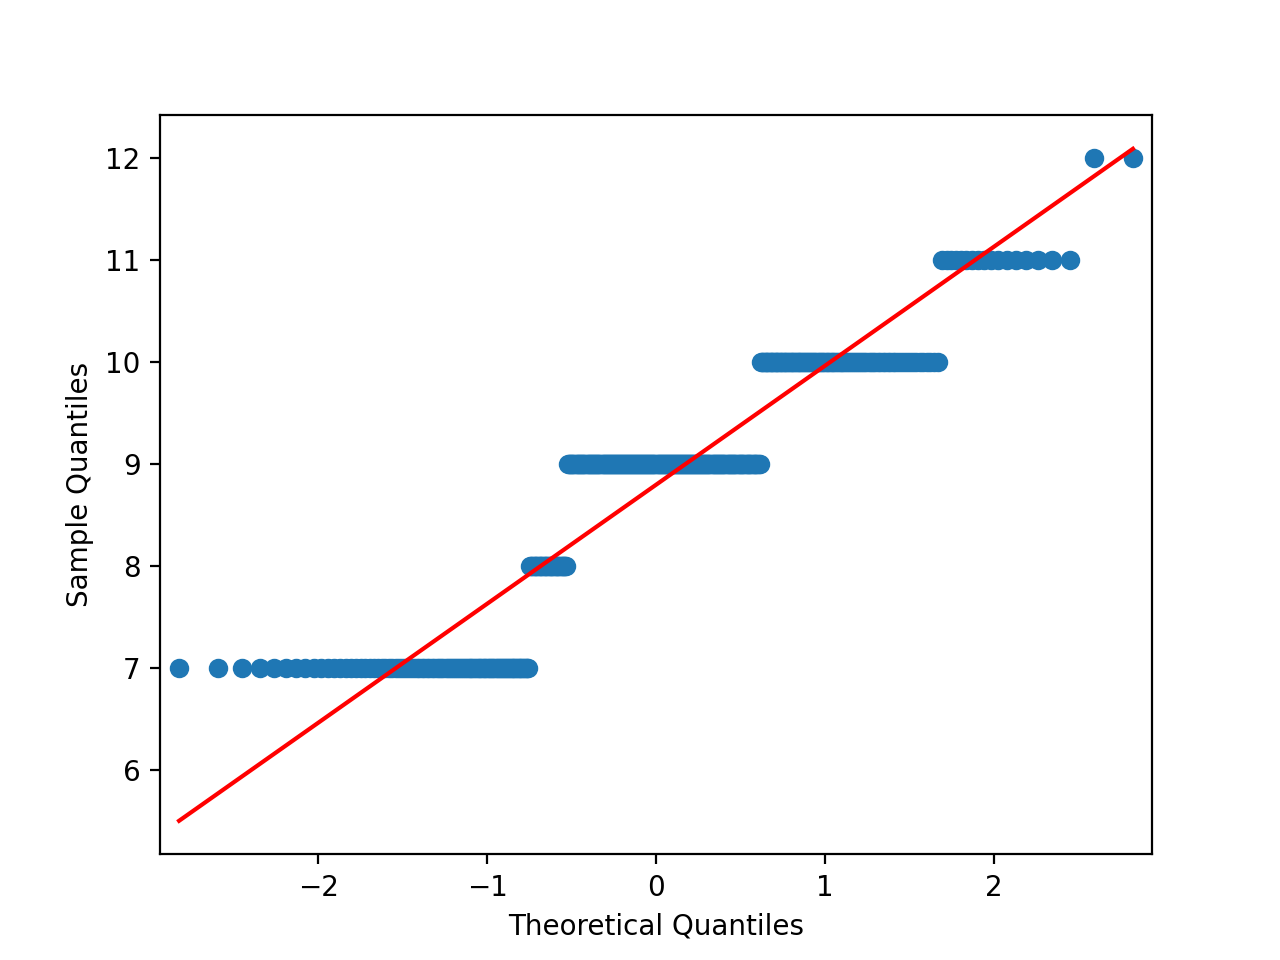

<IPython.core.display.Javascript object>


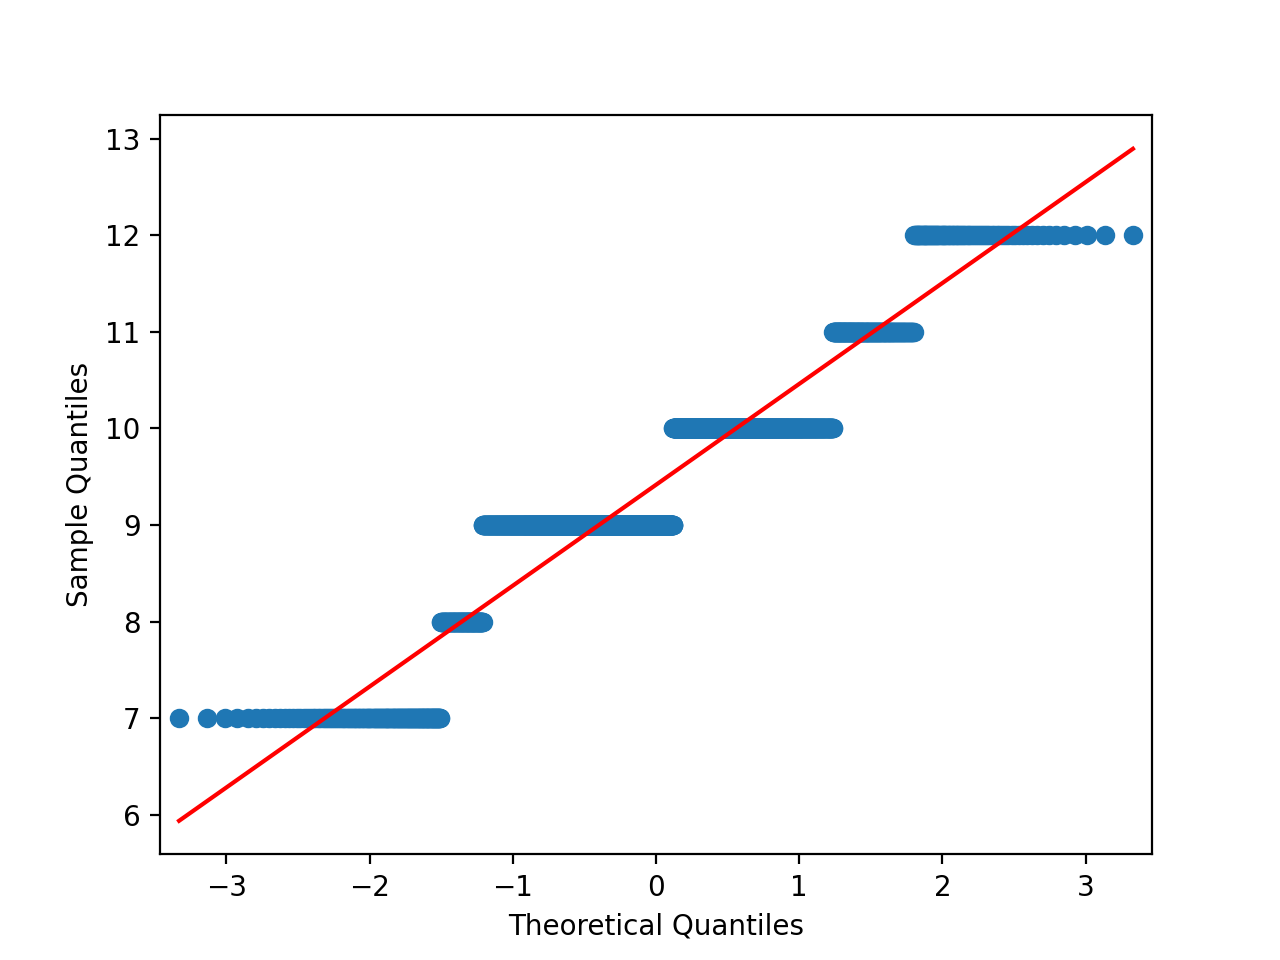

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(currNumCities_undo, ddof=1))
print(np.std(currNumCities_notundo, ddof=1))
## check normality
sm.qqplot(currNumCities_undo, line='s')
py.show()
sm.qqplot(currNumCities_notundo, line='s')
py.show()

In [ ]:
stat1, p1 = ttest_ind(currNumCities_undo,currNumCities_notundo,equal_var=False)

x1, x2 = 1,2  
if bx['caps'][1]._y[0] > bx['caps'][3]._y[0]:
    y, h, col = bx['caps'][1]._y[0] + 2, 0.5, 'k'
else:
    y, h, col = bx['caps'][3]._y[0] + 2, 0.5, 'k'

axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)
plt.show()

####  random effect

In [ ]:
currNumCities_undo = df_beforeUndo.loc[index_end_undo,['currNumCities','subjects','puzzleID']] 
currNumCities_undo_sub = currNumCities_undo.groupby(['subjects'])['currNumCities'].mean()
currNumCities_undo_sub_sem = sem(currNumCities_undo_sub)

currNumCities_notundo = df_notbeforeUndo.loc[index_end_notundo,['currNumCities','subjects','puzzleID']]
currNumCities_notundo_sub = currNumCities_notundo.groupby(['subjects'])['currNumCities'].mean()
currNumCities_notundo_sub_sem = sem(currNumCities_notundo_sub)

<IPython.core.display.Javascript object>


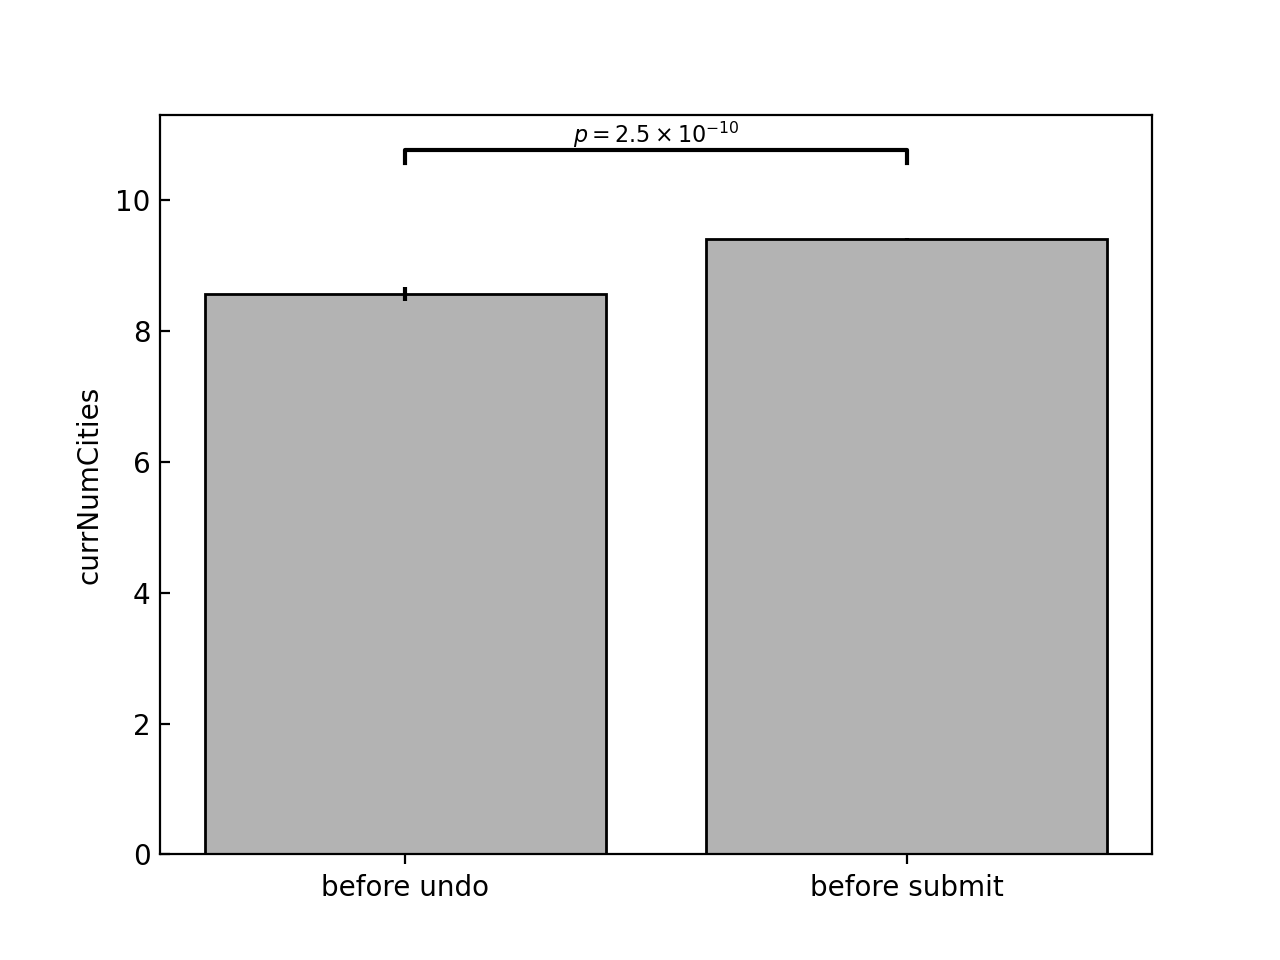

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2],
             
             [currNumCities_undo_sub.mean(),currNumCities_notundo_sub.mean()],
             
             color = (.7,.7,.7), 
             
             edgecolor = 'k',
             
             yerr=[currNumCities_undo_sub_sem, currNumCities_notundo_sub_sem])


axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['before undo','before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('currNumCities') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

0.8401524776554902
0.15607141310362768


<IPython.core.display.Javascript object>


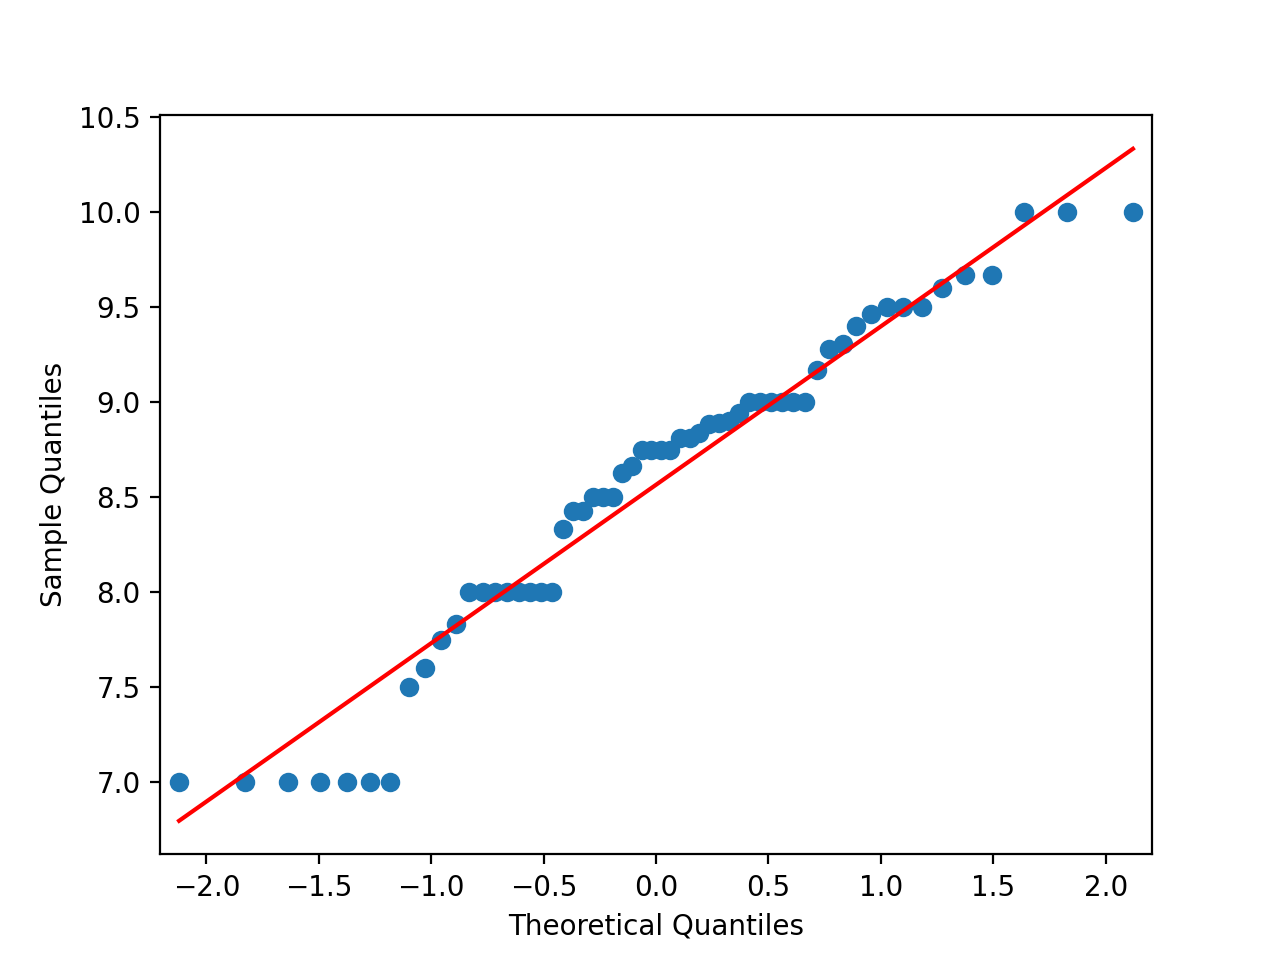

<IPython.core.display.Javascript object>


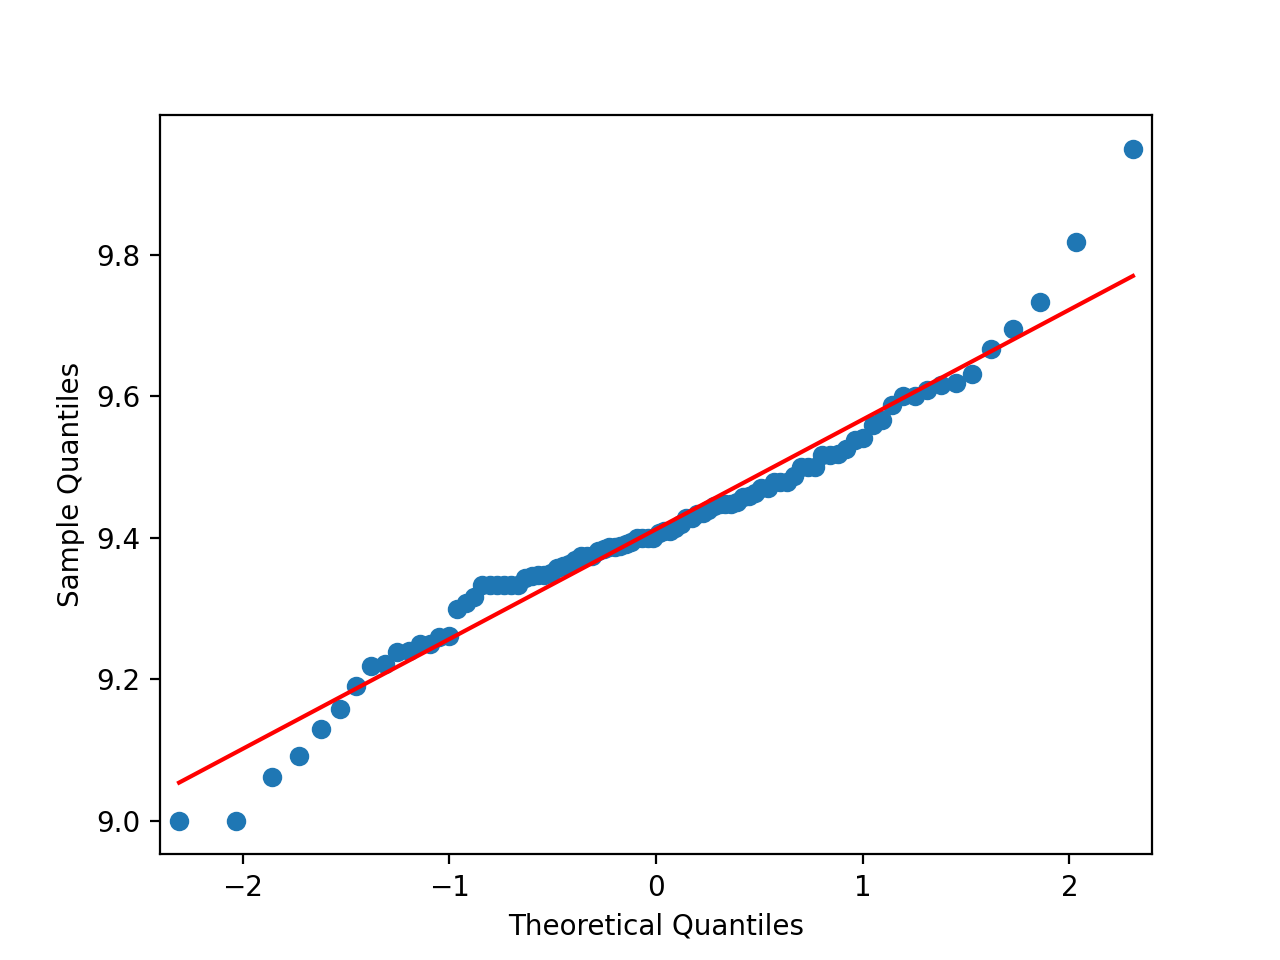

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(currNumCities_undo_sub, ddof=1))
print(np.std(currNumCities_notundo_sub, ddof=1))
## check normality
sm.qqplot(currNumCities_undo_sub, line='s')
py.show()
sm.qqplot(currNumCities_notundo_sub, line='s')
py.show()

In [ ]:
stat1, p1 = ttest_ind(currNumCities_undo_sub,currNumCities_notundo_sub,equal_var=False)

x1, x2 = 1,2
y, h, col = bx[0].get_height() + 2, 0.2, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

plt.show()

### § proportion

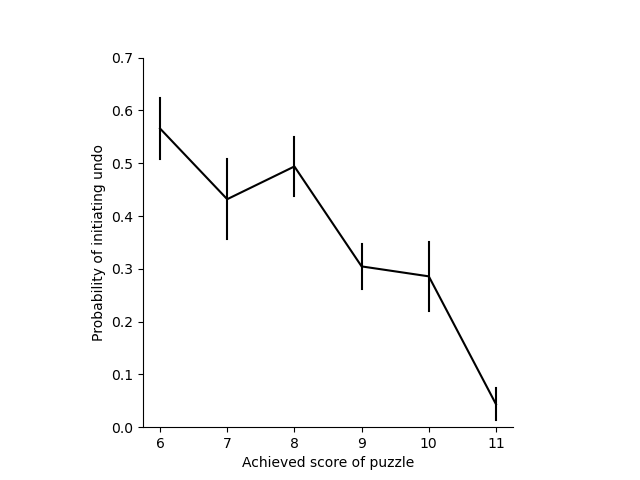

currNumCities
6     76
7     44
8     81
9     90
10    49
11    46
Name: firstUndo, dtype: int64

In [ ]:
firstUndo_sub = state_df.groupby(['subjects','currNumCities'])['firstUndo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             data = firstUndo_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set_ylim(0,0.7)
axs.set(xlabel='Achieved score of puzzle', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
plt.show()

firstUndo_sub.groupby(['currNumCities'])['firstUndo'].count()

currNumCities
6     76
7     44
8     81
9     90
10    49
11    46
Name: TT, dtype: int64

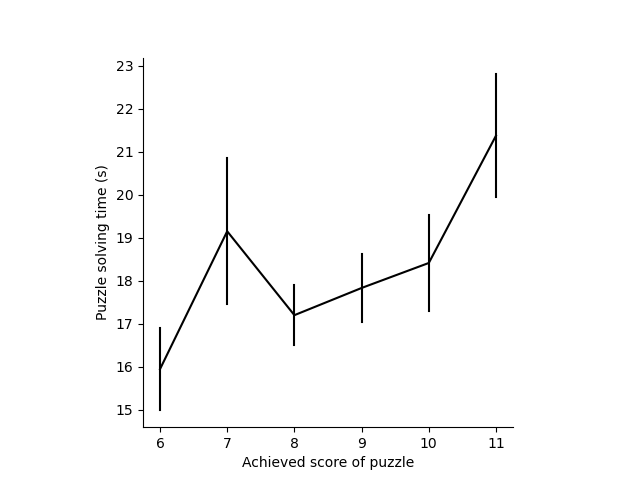

In [ ]:
TT_sub = state_df.groupby(['subjects','currNumCities'])['TT'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='TT', data = TT_sub, color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Achieved score of puzzle', ylabel='Puzzle solving time (s)')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
TT_sub.groupby(['currNumCities'])['TT'].count()

### GLM submit/undo - currNumCities at end 

assumptions of logistic regression: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/

In [ ]:
currNumCities_undo['submit'] = 0
currNumCities_notundo['submit'] = 1

In [ ]:
currNumCities_df = pd.concat([currNumCities_undo,currNumCities_notundo])
currNumCities_df = currNumCities_df.reset_index(drop=True)
currNumCities_df

currNumCities  subjects  puzzleID  submit
0                 9         0        42       0
1                 7         0         1       0
2                 9         0        15       0
3                10         0         2       0
4                 9         1        29       0
...             ...       ...       ...     ...
2719             11        99        13       1
2720             12        99        43       1
2721              9        99        38       1
2722              7        99         1       1
2723             10        99        34       1

[2724 rows x 4 columns]

In [ ]:
currNumCities_df.groupby(['currNumCities']).mean()['submit']

currNumCities
7     0.615385
8     0.776978
9     0.845439
10    0.894025
11    0.907104
12    0.976190
Name: submit, dtype: float64

In [ ]:
%%R -i currNumCities_df
currNumCities_df$subjects <- as.factor(currNumCities_df[,"subjects"])
currNumCities_df$puzzleID <- as.factor(currNumCities_df[,"puzzleID"])

model_submit1 = lme4::glmer(submit ~  1 + currNumCities + (1 |subjects),
                                  data = currNumCities_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_submit1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: submit ~ 1 + currNumCities + (1 | subjects)
   Data: currNumCities_df

     AIC      BIC   logLik deviance df.resid 
  1824.2   1841.9   -909.1   1818.2     2721 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.0344  0.0878  0.1910  0.3630  1.9320 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 4.9      2.214   
Number of obs: 2724, groups:  subjects, 99

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.74289    0.59973  -4.574  4.8e-06 ***
currNumCities  0.63501    0.06047  10.501  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
currNumCits -0.874


## Remaining budget

### proportion

[Text(0.5, 0, 'Remaining budget'),
 Text(0, 0.5, 'Probability of initiating undoing')]

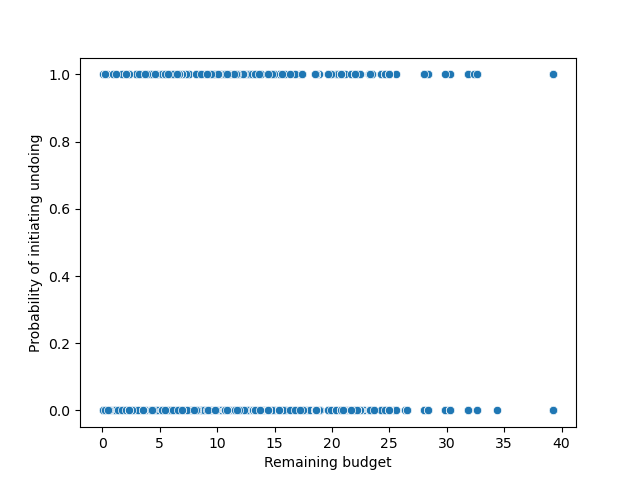

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# scatter plot
sns.scatterplot(x='leftover', y='firstUndo', data = state_df)
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Remaining budget', ylabel='Probability of initiating undoing')

### histogram of remaining budget at the end of trial 

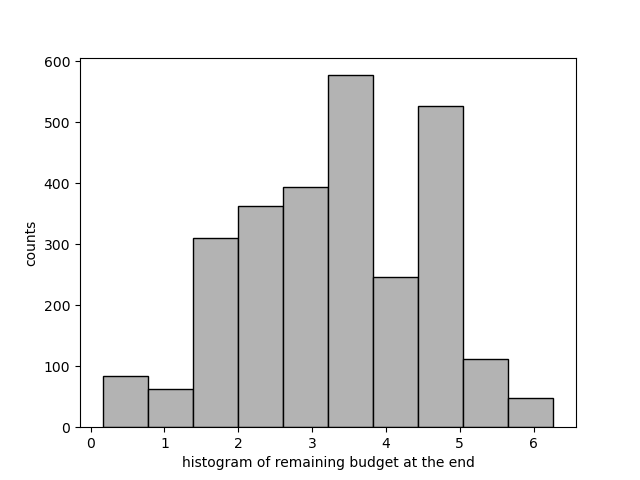

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(np.sqrt(state_df.leftover),
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('histogram of remaining budget at the end') 
plt.show()

### plot of remaining budget before submit/undo

#### fixed effect

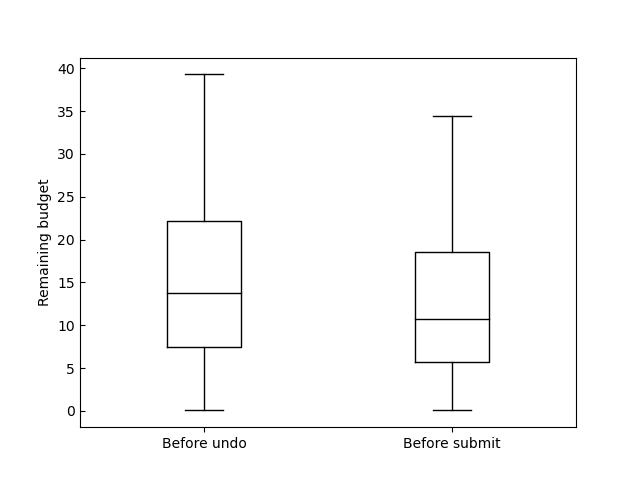

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot([state_undo.leftover,state_notundo.leftover],
   positions =[1,2],widths = 0.3,showfliers=False,whis = 1.5,
   medianprops = dict(color = 'k'))  #

#--------------------------------------
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Before undo','Before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('Remaining budget') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

original qq-plot is right-skewed.

9.15828671228378
8.229535756792751


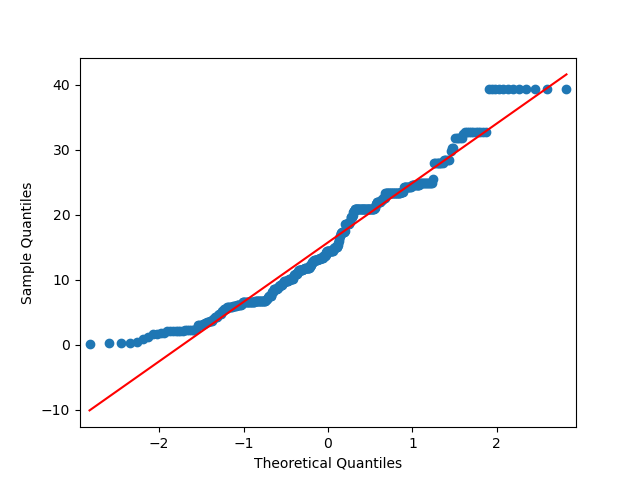

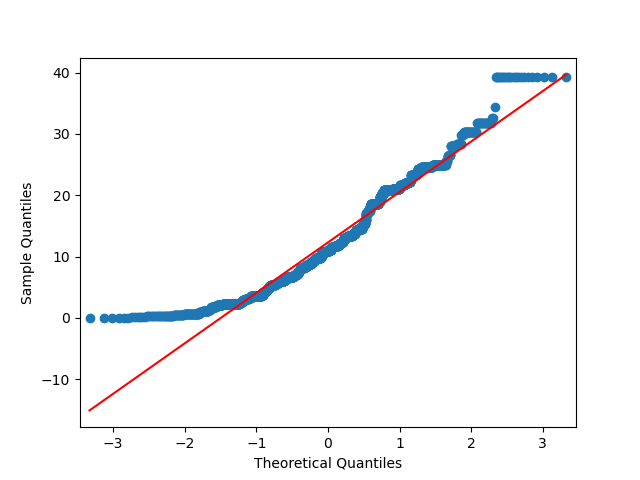

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(state_undo.leftover, ddof=1))
print(np.std(state_notundo.leftover, ddof=1))
## check normality
sm.qqplot(state_undo.leftover, line='s')
py.show()
sm.qqplot(state_notundo.leftover, line='s')
py.show()

In [ ]:
# run 2-independent-sample t test
stat1, p1 = ttest_ind(np.sqrt(leftover_undo),np.sqrt(leftover_notundo),equal_var=False)
x1, x2 = 1,2  
if bx['caps'][1]._y[0] > bx['caps'][3]._y[0]:
    y, h, col = bx['caps'][1]._y[0] + 2, 0.5, 'k'
else:
    y, h, col = bx['caps'][3]._y[0] + 2, 0.5, 'k'

axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

#### § random effect

In [ ]:
leftover_undo_sub = state_undo.groupby(['subjects'])['leftover'].mean()
leftover_undo_sub_sem = sem(leftover_undo_sub)

leftover_notundo_sub = state_notundo.groupby(['subjects'])['leftover'].mean()
leftover_notundo_sub_sem = sem(leftover_notundo_sub)

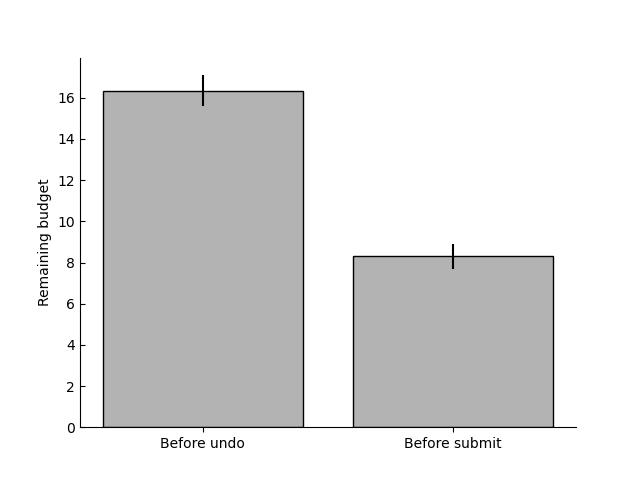

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2],
             
             [leftover_undo_sub.mean(),leftover_notundo_sub.mean()],
             
             color = (.7,.7,.7), 
             
             edgecolor = 'k',
             
             yerr=[leftover_undo_sub_sem, leftover_notundo_sub_sem])


axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Before undo','Before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('Remaining budget') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

5.68480463116035
1.9256794146933054


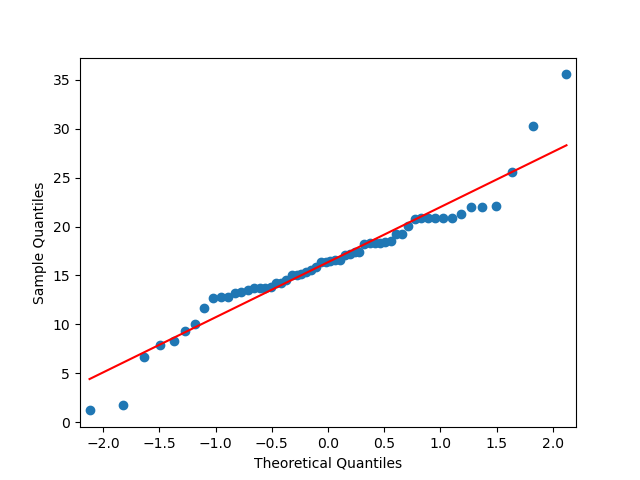

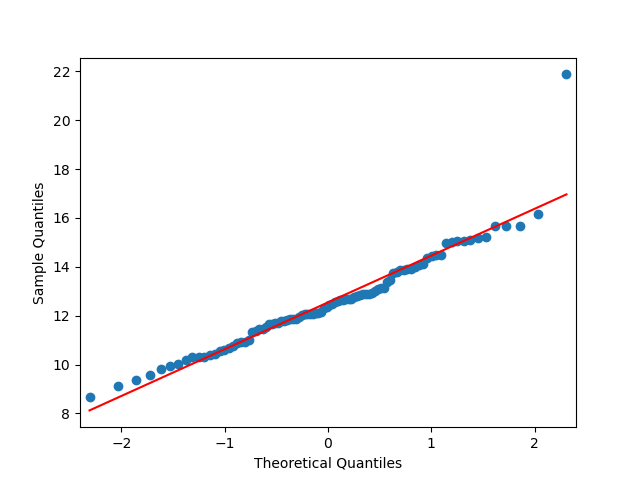

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(leftover_undo_sub, ddof=1))
print(np.std(leftover_notundo_sub, ddof=1))
# not met
## check normality
sm.qqplot(leftover_undo_sub, line='s')
py.show()
sm.qqplot(leftover_notundo_sub, line='s')
py.show()

In [ ]:
stat1, p1 = mannwhitneyu(leftover_undo_sub,leftover_notundo_sub)

x1, x2 = 1,2
y, h, col = bx[0].get_height() + 2, 0.2, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

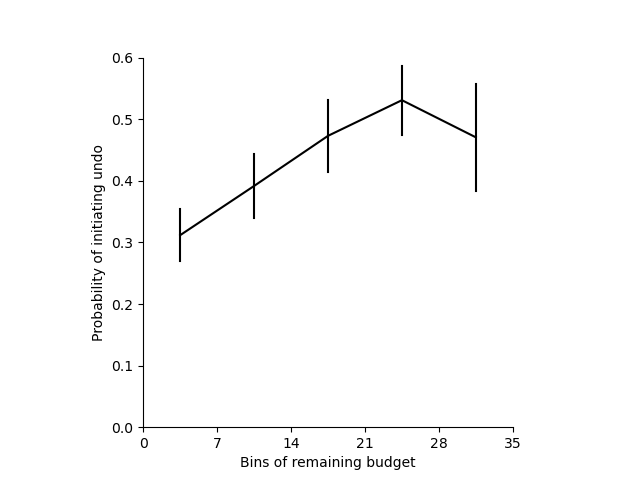

leftover_bin
1    92
2    80
3    74
4    81
5    34
6    19
Name: firstUndo, dtype: int64

In [ ]:
firstUndo_sub = state_df.groupby(['subjects','leftover_bin'])['firstUndo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.leftover_bin<=5],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 6.5, 1))
axs.set_xticklabels(cutoff[:-1])
axs.set_ylim(0,0.6)
axs.set(xlabel='Bins of remaining budget', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
plt.show()

# count ignore nan
firstUndo_sub.groupby(['leftover_bin'])['firstUndo'].count()

### GLM submit/undo - remaining budget at end 

In [ ]:
leftover_undo['submit'] = 0
leftover_notundo['submit'] = 1
leftover_df = pd.concat([leftover_undo,leftover_notundo])
# wrong! leftover_df = sc_data_choice_level.loc[leftover_all.index+1,['leftover','submit','subjects','puzzleID']]
leftover_df = leftover_df.reset_index(drop=True)
leftover_df['currNumCities'] = currNumCities_df.currNumCities


In [ ]:
%%R -i leftover_df
leftover_df$subjects <- as.factor(leftover_df[,"subjects"])
leftover_df$puzzleID <- as.factor(leftover_df[,"puzzleID"])

model_submit2 = lme4::glmer(submit ~  1 + leftover + (1 |subjects) + (1 |puzzleID),
                                  data = leftover_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_submit2)

In [ ]:
np.corrcoef(leftover_df.sqrt_leftover, currNumCities_df.currNumCities)

array([[ 1.        , -0.08598434],
       [-0.08598434,  1.        ]])

In [ ]:
%%R -i leftover_df

leftover_df$subjects <- as.factor(leftover_df[,"subjects"])
leftover_df$puzzleID <- as.factor(leftover_df[,"puzzleID"])

model_submit = lme4::glmer(submit ~  1 + sqrt_leftover + currNumCities + (1 |subjects),
                                  data = leftover_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_submit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: submit ~ 1 + sqrt_leftover + currNumCities + (1 | subjects)
   Data: leftover_df

     AIC      BIC   logLik deviance df.resid 
  1771.7   1795.3   -881.8   1763.7     2720 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.9399  0.0792  0.1685  0.3435  2.5581 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 5.154    2.27    
Number of obs: 2724, groups:  subjects, 99

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.42086    0.63874  -2.224   0.0261 *  
sqrt_leftover -0.39207    0.05483  -7.150 8.67e-13 ***
currNumCities  0.64740    0.06254  10.352  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sqrt_l
sqrt_leftvr -0.263       
currNumCits -0.819 -0.085


In [ ]:
%%R 
VarCorr(model_submit)
# AICtab(model_submit,model_submit1,nobs=nrow(leftover_df))

 Groups   Name        Std.Dev.
 subjects (Intercept) 2.2703  


## Uncertainty

### § First-move RT

In [ ]:
mannwhitneyu(state_undo_1undo["RT1"].dropna(),state_notundo_1undo["RT1"].dropna())

MannwhitneyuResult(statistic=255104.0, pvalue=2.5096722050492988e-06)

In [ ]:
RT1_undo_sub = state_undo_1undo.groupby(['subjects'])['RT1_log'].mean()
RT1_undo_sub_sem = sem(RT1_undo_sub, nan_policy="omit")

RT1_notundo_sub = state_notundo_1undo.groupby(['subjects'])['RT1_log'].mean()
RT1_notundo_sub_sem = sem(RT1_notundo_sub, nan_policy="omit")

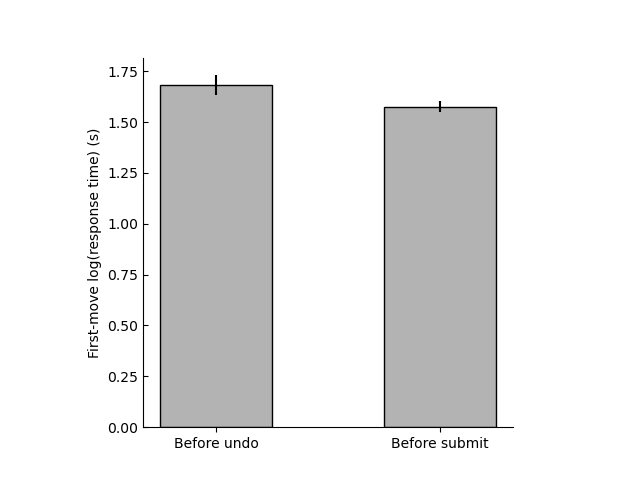

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2],
             [RT1_undo_sub.mean(),RT1_notundo_sub.mean()],
             color = (.7,.7,.7), 
             edgecolor = 'k', 
             width = 0.5,            
             yerr=[RT1_undo_sub_sem, RT1_notundo_sub_sem])

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Before undo','Before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('First-move log(response time) (s)') #,fontsize=18
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

0.37731505714254737
0.2645288477260418


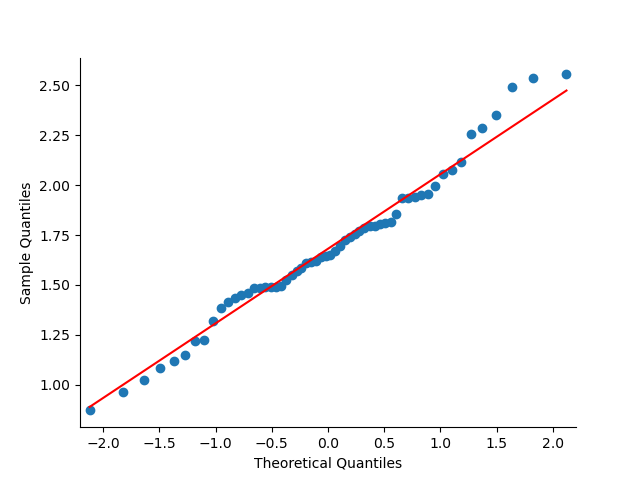

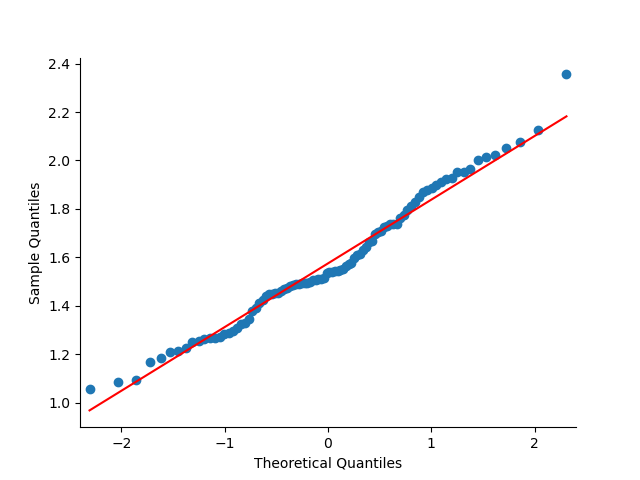

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(RT1_undo_sub, ddof=1))
print(np.std(RT1_notundo_sub, ddof=1))
## check normality
sm.qqplot(RT1_undo_sub, line='s')
py.show()
sm.qqplot(RT1_notundo_sub, line='s')
py.show()

In [ ]:
stat1, p1 = ttest_ind(RT1_undo_sub.dropna(),RT1_notundo_sub.dropna(), alternative = 'greater')

x1, x2 = 1,2
y, h, col = bx[0].get_height() + 0.2, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

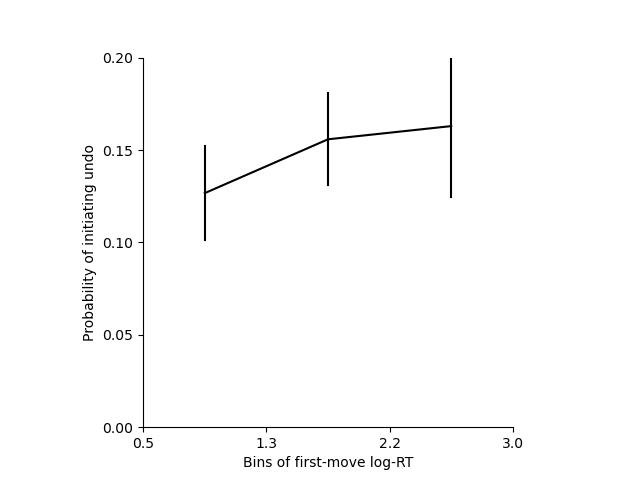

rt1_bin
1    91
2    97
3    65
4    11
5     1
Name: firstUndo, dtype: int64

In [ ]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['firstUndo'].mean().reset_index()
#sequentialUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors'])['sequentialUndo'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
#axs.set_xticks(np.arange(0.5, 7.5, 1))
# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
axs.set_ylim([0,0.2])
axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Bins of first-move log-RT', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
plt.show()

firstUndo_sub.groupby(['rt1_bin'])['firstUndo'].count()

### Branching-node RT [no branching node in submit condition]

In [ ]:
mannwhitneyu(state_undo_1undo["RT_branching"].dropna(),state_notundo_1undo["RT_branching"].dropna())

In [ ]:
RT_branching_undo_sub = state_undo_1undo.groupby(['subjects'])['RT_branching'].mean()
RT_branching_undo_sub_sem = sem(RT_branching_undo_sub, nan_policy="omit")

RT_branching_notundo_sub = state_notundo_1undo.groupby(['subjects'])['RT_branching'].mean()
RT_branching_notundo_sub_sem = sem(RT_branching_notundo_sub, nan_policy="omit")

In [ ]:
len(RT_branching_undo_sub.dropna())

57

/Users/dbao/opt/anaconda3/envs/road/lib/python3.8/site-packages/numpy/ma/core.py:3377: UserWarning: Warning: converting a masked element to nan.
  _data[indx] = dval
/Users/dbao/opt/anaconda3/envs/road/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


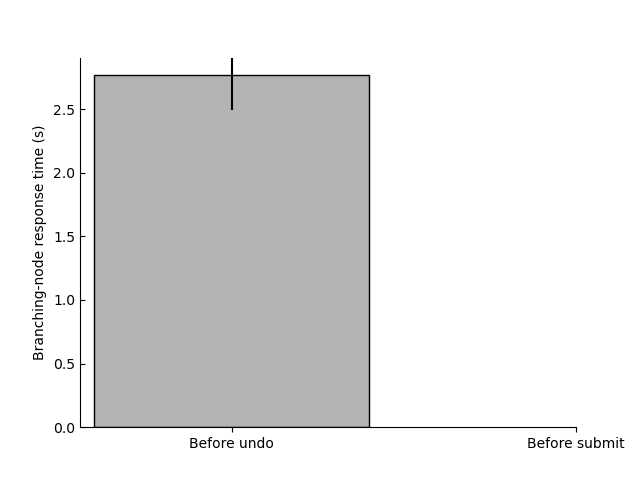

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2],
             [RT_branching_undo_sub.mean(),RT_branching_notundo_sub.mean()],
             color = (.7,.7,.7), 
             edgecolor = 'k',             
             yerr=[RT_branching_undo_sub_sem, RT_branching_notundo_sub_sem])

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Before undo','Before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('Branching-node response time (s)') #,fontsize=18

plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

In [ ]:
stat1, p1 = mannwhitneyu(RT_branching_undo_sub.dropna(),RT_branching_notundo_sub.dropna())

x1, x2 = 1,2
y, h, col = bx[0].get_height() + 1, 0.2, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

### § Last RT

In [ ]:
RT_undo_sub = state_undo.groupby(['subjects'])['lastRT_log'].mean()
RT_undo_sub_sem = sem(RT_undo_sub, nan_policy="omit")

RT_notundo_sub = state_notundo.groupby(['subjects'])['lastRT_log'].mean()
RT_notundo_sub_sem = sem(RT_notundo_sub, nan_policy="omit")

In [ ]:
print(len(RT_undo_sub.dropna()))
print(len(RT_notundo_sub.dropna()))

58
81


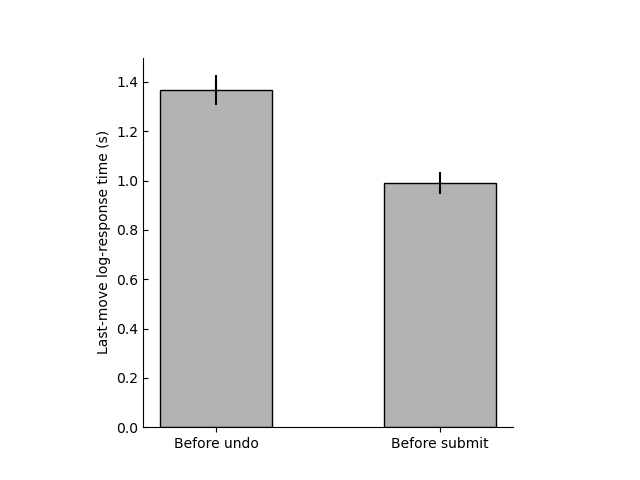

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2],
             [RT_undo_sub.mean(),RT_notundo_sub.mean()],
             color = (.7,.7,.7), 
             edgecolor = 'k',  
             width = 0.5,             
             yerr=[RT_undo_sub_sem, RT_notundo_sub_sem])

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Before undo','Before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('Last-move log-response time (s)') #,fontsize=18

axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
plt.show()
# fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

0.458972711429163
0.39032062711495785


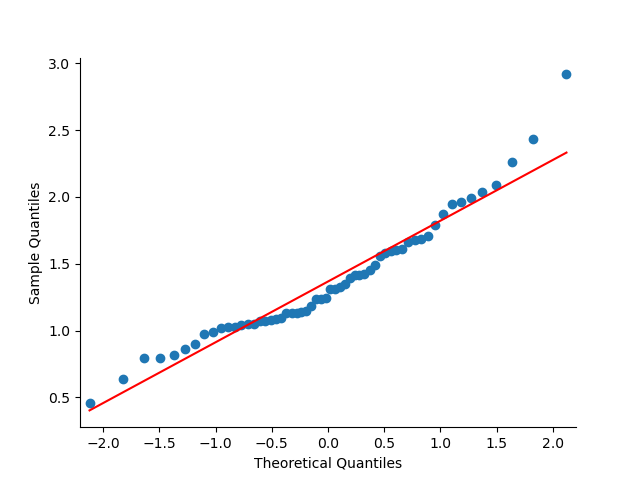

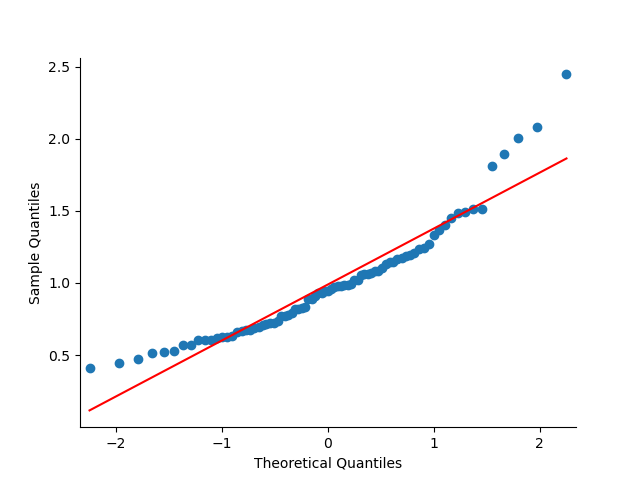

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(RT_undo_sub, ddof=1))
print(np.std(RT_notundo_sub, ddof=1))
## check normality
sm.qqplot(RT_undo_sub, line='s')
py.show()
sm.qqplot(RT_notundo_sub, line='s')
py.show()

In [ ]:
stat1, p1 = mannwhitneyu(RT_undo_sub.dropna(),RT_notundo_sub.dropna())

x1, x2 = 1,2
y, h, col = bx[0].get_height() + 1, 0.2, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

## Puzzle MAS

### numFullUndo

<IPython.core.display.Javascript object>


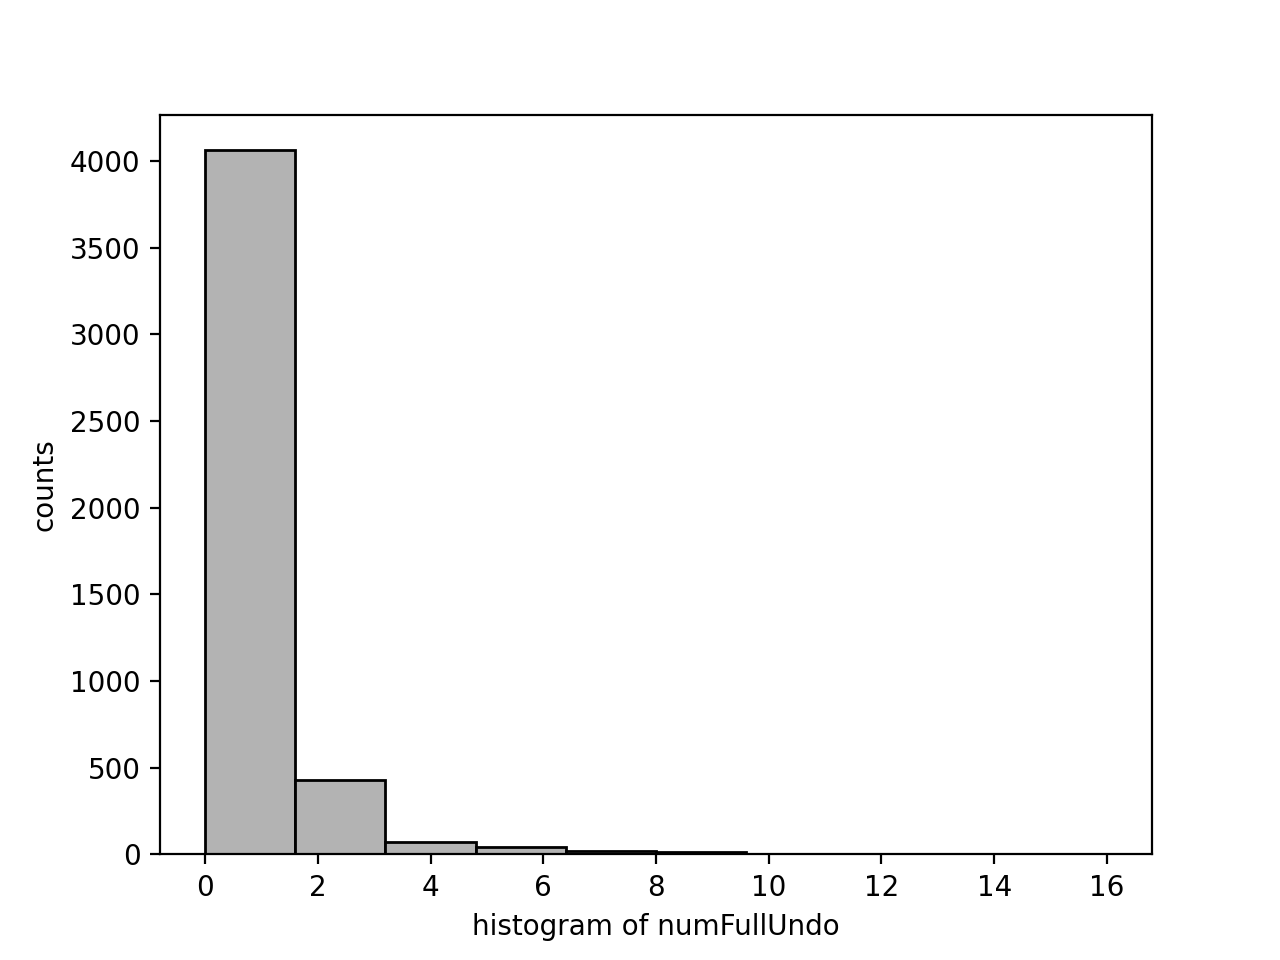

0.6889797675419715

In [ ]:
%matplotlib notebook

numFullUndo = single_condition_data['numFullUndo']

fig, axs = plt.subplots(1, 1)
axs.hist(numFullUndo,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('histogram of numFullUndo') 
plt.show()

sum(single_condition_data['numFullUndo']==0)/len(single_condition_data['numFullUndo']==0)
# sum(single_condition_data['numFullUndo']==1)/len(single_condition_data['numFullUndo']==0)

### barplot number of undo across different puzzle MAS

#### fixed effect

<IPython.core.display.Javascript object>


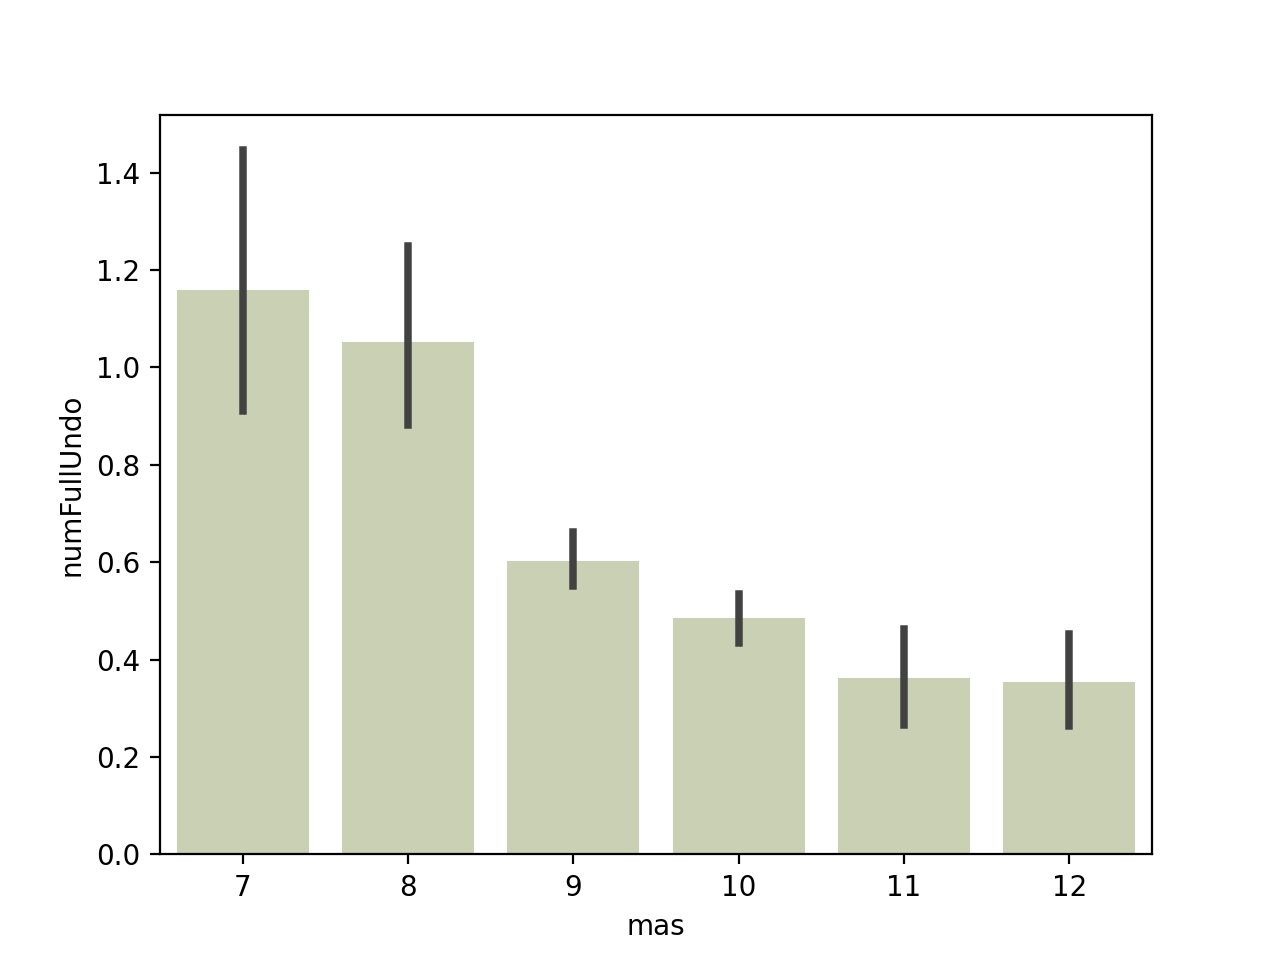

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='mas', y='numFullUndo', data = single_condition_data, color = '#ccd5ae') 

#### random effect

<IPython.core.display.Javascript object>


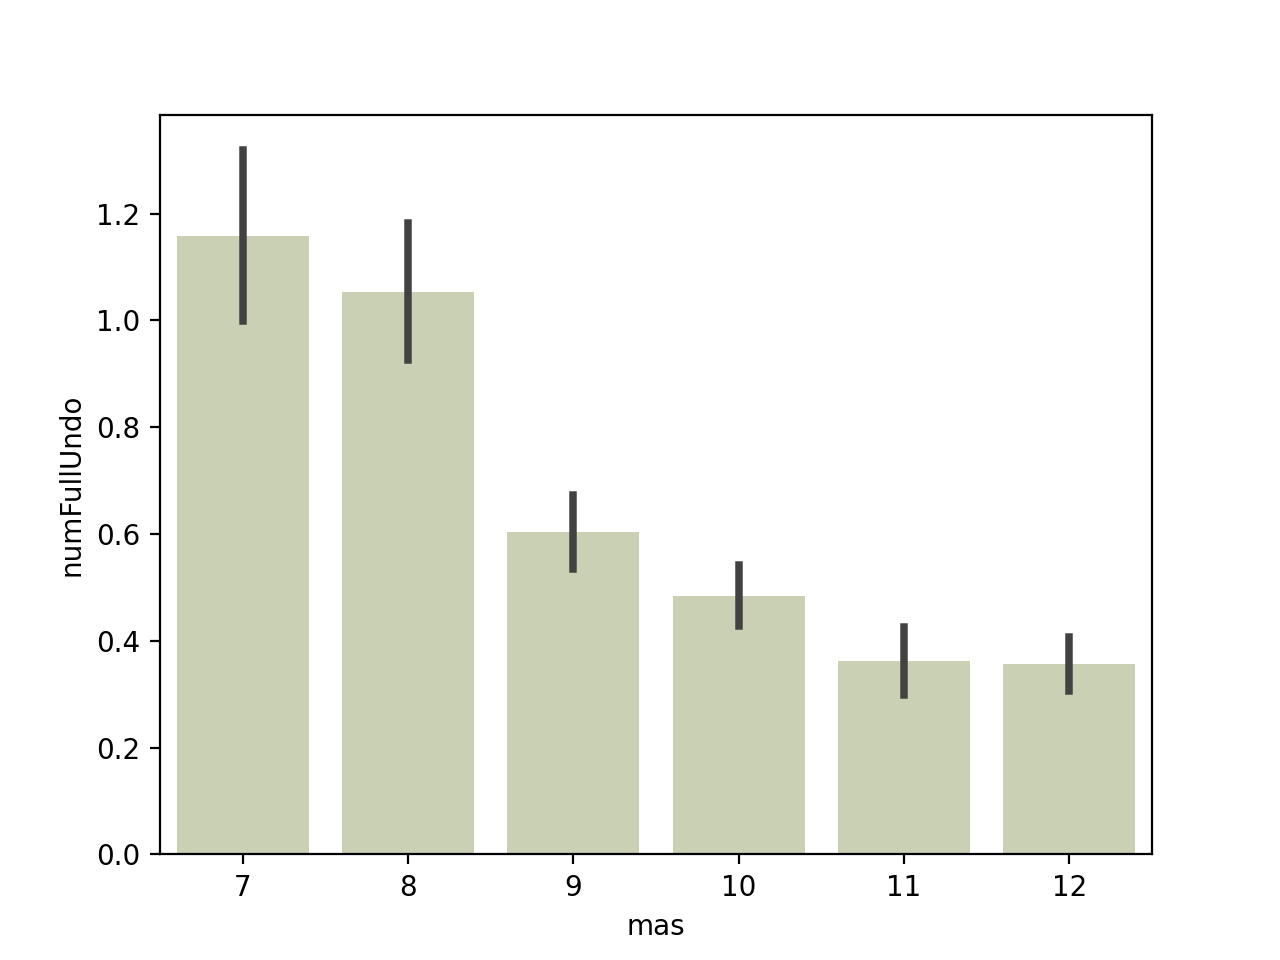

<AxesSubplot:xlabel='mas', ylabel='numFullUndo'>

In [ ]:
numFullUndo_sub = single_condition_data.groupby(['subjects','mas'])['numFullUndo'].mean().reset_index()

%matplotlib notebook
fig, axs = plt.subplots(1, 1)

sns.barplot(x='mas', y='numFullUndo', data = numFullUndo_sub, errorbar = "se", color = '#ccd5ae') 

### GLM

In [ ]:
%%R -i single_condition_data
single_condition_data$subjects <- as.factor(single_condition_data[,"subjects"])
single_condition_data$z_mas <- scale(single_condition_data$mas)

model_undo = lmerTest::lmer(numFullUndo ~  1 + mas + (1 |subjects),
                                  data = single_condition_data, control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model_undo)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: numFullUndo ~ 1 + mas + (1 | subjects)
   Data: single_condition_data
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 13883

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9978 -0.4484 -0.1347  0.1763 13.5091 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.3851   0.6206  
 Residual             1.0905   1.0443  
Number of obs: 4646, groups:  subjects, 101

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    2.22358    0.15674 2353.23930   14.19   <2e-16 ***
mas           -0.17262    0.01508 4544.00956  -11.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
mas -0.914


In [ ]:
%%R
model_undo_brms = brm(numFullUndo ~  1  + mas + (1 |subjects),
                                  data = single_condition_data,  
                                  chains = 3, cores = 3, iter = 2000, warmup = 1000, 
                                  family = "zero_inflated_poisson")

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling

Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 


In [ ]:
%%R -i out_dir2
save(model_undo_brms, single_condition_data, file=file.path(out_dir2, file=paste("model_undo_brms.RData", sep="")))

In [ ]:
%%R
summary(model_undo_brms)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: numFullUndo ~ 1 + mas + (1 | subjects) 
   Data: single_condition_data (Number of observations: 4646) 
  Draws: 3 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 3000

Group-Level Effects: 
~subjects (Number of levels: 101) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.46      0.13     1.22     1.73 1.02      243      520

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.31      0.24     0.84     1.76 1.01      341      996
mas          -0.25      0.02    -0.29    -0.21 1.00     2560     2345

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.23      0.02     0.20     0.27 1.00     2341     2152

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measu

## [discard]Puzzle remaining budget 

### histogram of remaining budget, numFullUndo

<IPython.core.display.Javascript object>


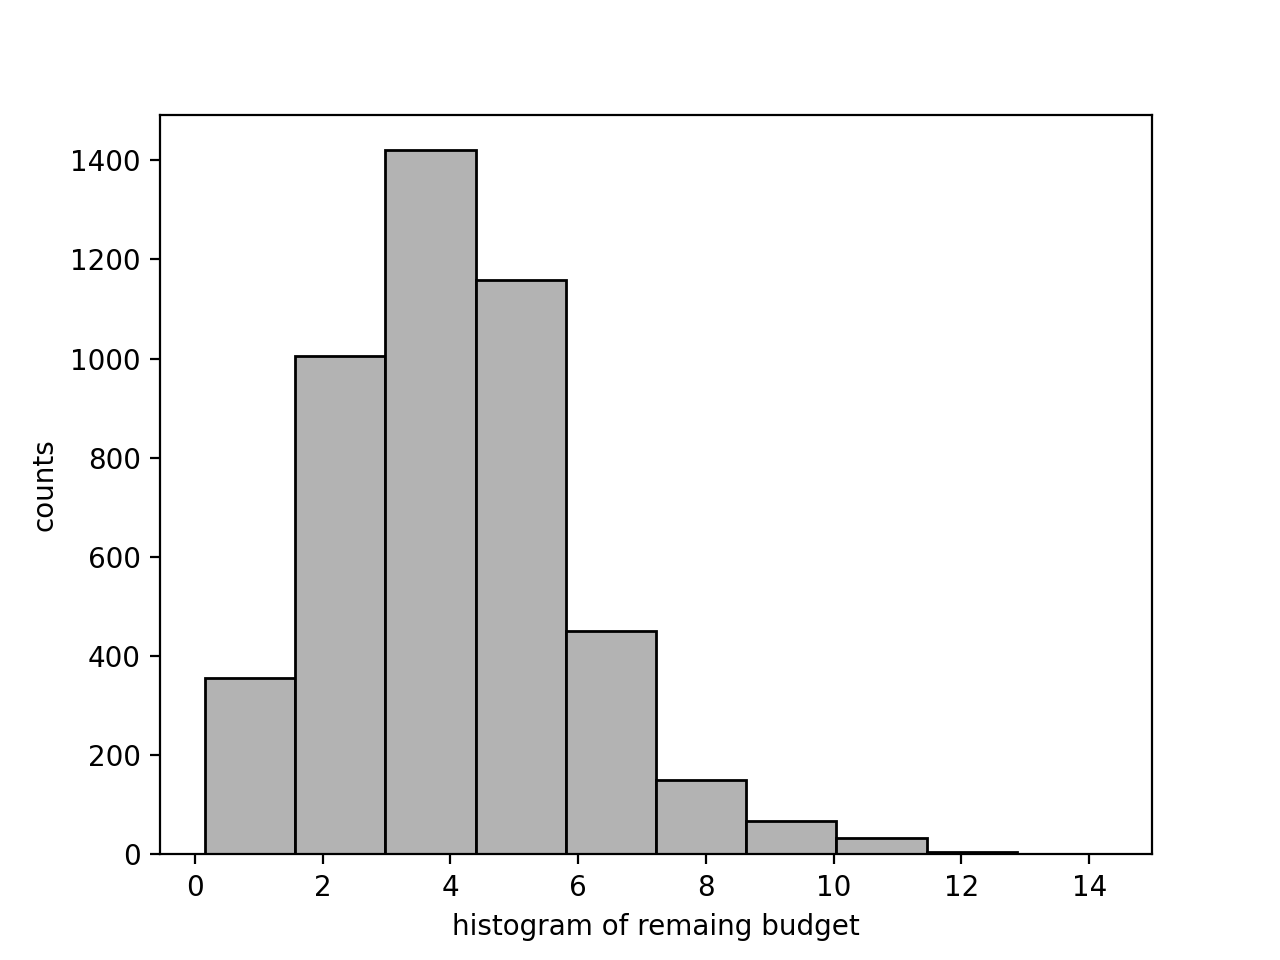

In [ ]:
%matplotlib notebook

budget = single_condition_data['sqrt_leftover']

fig, axs = plt.subplots(1, 1)
axs.hist(budget,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('histogram of remaing budget') 
plt.show()

the distribution of numFullUndo shows that we may need to consider zero-inflation

### scatter plot of puzzle remaining budget and numUndo

In [ ]:
numFullUndo_df = single_condition_data.groupby(['subjects','mas'])['sqrt_numFullUndo'].mean().to_frame(name = 'sqrt_numFullUndo').reset_index()
scatter_data = single_condition_data.groupby(['subjects','mas'])['sqrt_leftover'].mean().to_frame(name = 'sqrt_leftover').reset_index()
scatter_data['sqrt_numFullUndo'] = numFullUndo_df.sqrt_numFullUndo


In [ ]:
single_condition_data

index  subjects  puzzleID  reward  numCities  mas  nos   leftover  \
0        14         1         0      81          9    9  104  12.884179   
1        17         1         1      49          7    7    6  20.819878   
2        90         1         2     100         10   10   70  24.612640   
3        87         1         3      81          9   10   34   4.923116   
4        77         1         4      81          9   10    4   3.415435   
...     ...       ...       ...     ...        ...  ...  ...        ...   
4641   9217       101        41      81          9   10    1  35.979604   
4642   9208       101        42      81          9    9   16  14.438090   
4643   9286       101        43     144         12   12   16   6.951823   
4644   9216       101        44      49          7    7   13  23.277761   
4645   9222       101        45     100         10   10    6   8.153328   

      numError  sumSeverityErrors  ...  numUNDO  numFullUndo  numEnd      TT  \
0            1                  1  ...        6            1       2  48.615   
1            3                  3  ...       11            3       4  62.332   
2            0                  0  ...        7            1       2  56.502   
3            1                  1  ...        0            0       1  20.538   
4            1                  1  ...        0            0       1  17.277   
...        ...                ...  ...      ...          ...     ...     ...   
4641         1                  1  ...        0            0       1  32.239   
4642         1                  1  ...        1            1       2  22.359   
4643         0                  0  ...        0            0       1  33.208   
4644         1                  1  ...        5            1       2  37.889   
4645         0                  0  ...        1            1       1  19.242   

         RT1   RTlater  RTsubmit  tortuosity  sqrt_leftover  sqrt_numFullUndo  
0      6.991  2.998786     2.330    1.324578       3.589454          1.000000  
1     12.950  3.026647     2.671    1.194868       4.562880          1.732051  
2      5.713  2.591250     7.993    1.461975       4.961113          1.000000  
3      6.919  2.345000     1.486    4.915218       2.218810          0.000000  
4      3.956  1.986375     1.174    1.623106       1.848090          0.000000  
...      ...       ...       ...         ...            ...               ...  
4641   7.786  3.869625     1.117    3.120843       5.998300          0.000000  
4642   6.040  2.035778     1.009    1.339191       3.799749          1.000000  
4643  14.932  2.838091     1.823    1.660709       2.636631          0.000000  
4644   9.232  1.886000     7.945    1.263519       4.824703          1.000000  
4645   5.977  1.555800     0.850    1.536035       2.855403          1.000000  

[4646 rows x 21 columns]

<IPython.core.display.Javascript object>


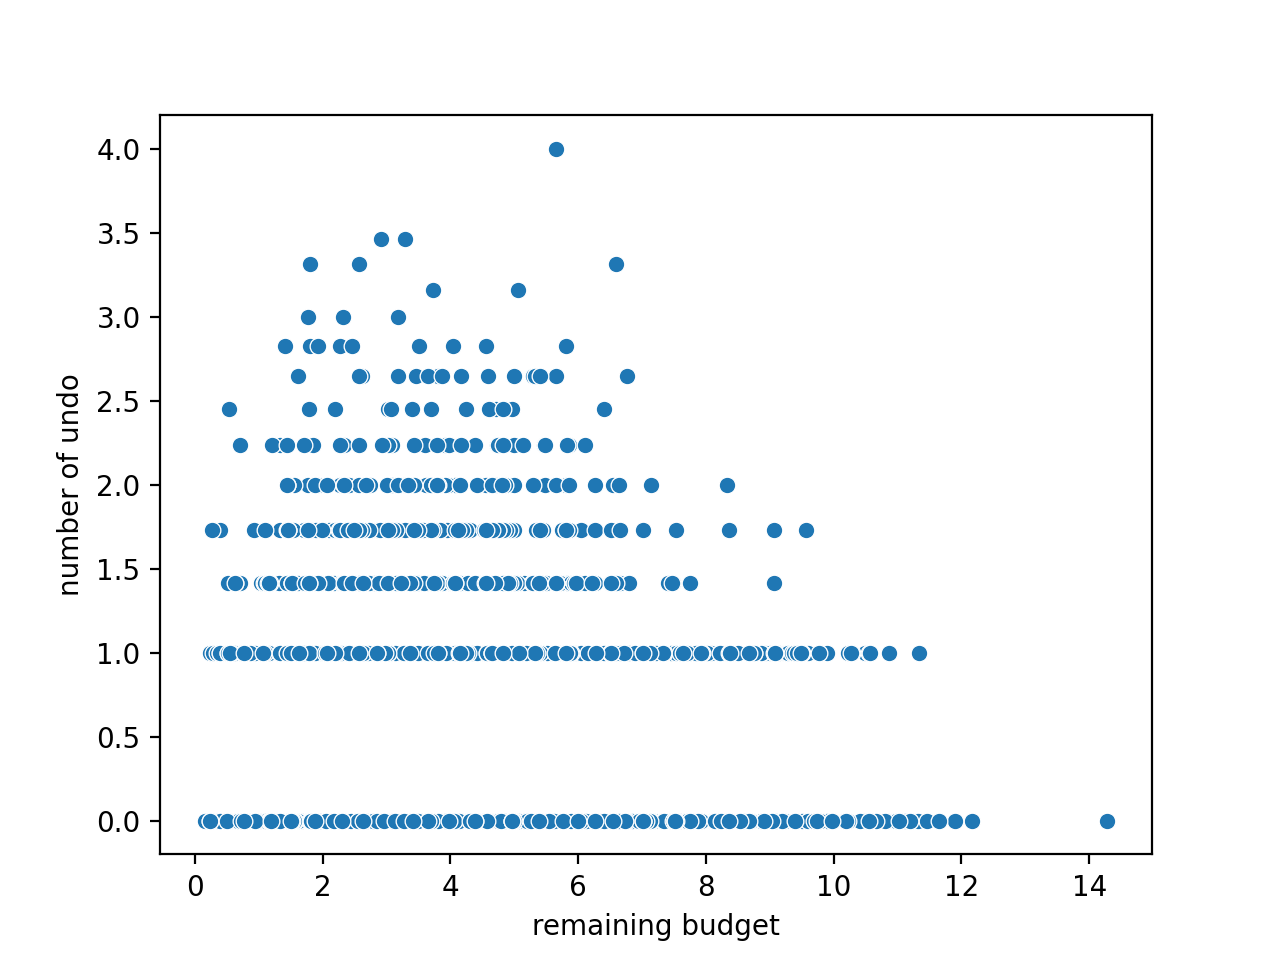

Text(0, 0.5, 'number of undo')

In [ ]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='sqrt_leftover', y='sqrt_numFullUndo', data=single_condition_data) 
ax1.set_xlabel("remaining budget")
ax1.set_ylabel("number of undo")

# Errors 

## When will there be errors?  (error binary / severity) 

### it happens more at the begining of a trial

In [ ]:
# remove the steps where the current connected cities is 1. Because the error is calculated as the current state feature. And when at the starting city, there cannot be errors commited.
# basic condition

data_cond0_outcome = data_choice_level[(data_choice_level['condition']==0)&(data_choice_level['currNumCities']!=0)&(data_choice_level['submit']!=1)]
# get the dataframe of the previous state
data_cond0_state = data_choice_level.iloc[data_cond0_outcome.index - 1,:].reset_index(drop=True)
data_cond0_outcome = data_cond0_outcome.reset_index(drop=True)
data_cond0_outcome['prevNumCities'] = data_cond0_state['currNumCities']

In [ ]:
data_cond1_outcome = data_subset_before1undo[(data_subset_before1undo['currNumCities']!=0)&(data_subset_before1undo['submit']!=1)]
# get the dataframe of the previous state
data_cond1_state = sc_data_choice_level.iloc[data_cond1_outcome.index - 1,:].reset_index(drop=True)
data_cond1_outcome = data_cond1_outcome.reset_index(drop=True)
data_cond1_outcome['prevNumCities'] = data_cond1_state['currNumCities']
data_cond1_outcome

Unnamed: 0  subjects  puzzleID  trialID  allMAS  \
0             104         0         0        8       8   
1             105         0         0        8       8   
2             106         0         0        8       8   
3             107         0         0        8       8   
4             108         0         0        8       8   
...           ...       ...       ...      ...     ...   
35341      111303        99        45       29       9   
35342      111304        99        45       29       9   
35343      111305        99        45       29       9   
35344      111306        99        45       29       9   
35345      111307        99        45       29       9   

                                      path  choice  currNumCities  currMas  \
0                                  [0, 28]      28              1        8   
1                               [0, 28, 5]       5              2        8   
2                           [0, 28, 5, 26]      26              3        8   
3                        [0, 28, 5, 26, 4]       4              4        8   
4                    [0, 28, 5, 26, 4, 24]      24              5        8   
...                                    ...     ...            ...      ...   
35341                 [0, 17, 24, 7, 2, 3]       3              5        9   
35342             [0, 17, 24, 7, 2, 3, 29]      29              6        9   
35343         [0, 17, 24, 7, 2, 3, 29, 10]      10              7        9   
35344      [0, 17, 24, 7, 2, 3, 29, 10, 6]       6              8        9   
35345  [0, 17, 24, 7, 2, 3, 29, 10, 6, 12]      12              9        9   

       currNos  ...  severityOfErrors  error     RT  undoRT  tortuosity  \
0           39  ...                 0      0  13788     NaN    1.000000   
1           27  ...                 0      0   1150     NaN    1.097830   
2            5  ...                 0      0   5192     NaN    1.140038   
3            4  ...                 0      0   1734     NaN    1.253478   
4            4  ...                 0      0   1200     NaN    1.244496   
...        ...  ...               ...    ...    ...     ...         ...   
35341        1  ...                 0      0    959     NaN    1.136825   
35342        1  ...                 0      0    961     NaN    1.390376   
35343        1  ...                 0      0    941     NaN    1.668227   
35344        1  ...                 0      0   1018     NaN    1.577621   
35345        1  ...                 0      0   1229     NaN    1.536035   

       branching  branchingFirst  sqrt_leftover      step  prevNumCities  
0            NaN             NaN      13.961342  0.125000              0  
1            NaN             NaN      12.298834  0.250000              1  
2            NaN             NaN      10.762027  0.375000              2  
3            NaN             NaN      10.187229  0.500000              3  
4            NaN             NaN       9.611341  0.625000              4  
...          ...             ...            ...       ...            ...  
35341        NaN             NaN       9.801398  0.555556              4  
35342        NaN             NaN       8.721663  0.666667              5  
35343        NaN             NaN       7.384223  0.777778              6  
35344        NaN             NaN       5.317701  0.888889              7  
35345        NaN             NaN       2.855403  1.000000              8  

[35346 rows x 28 columns]

In [ ]:
data_cond1_undo_outcome = data_subset_before1undoonly[(data_subset_before1undoonly['currNumCities']!=0)&(data_subset_before1undoonly['submit']!=1)]
# get the dataframe of the previous state
data_cond1_undo_state = sc_data_choice_level.iloc[data_cond1_undo_outcome.index - 1,:].reset_index(drop=True)
data_cond1_undo_outcome = data_cond1_undo_outcome.reset_index(drop=True)
data_cond1_undo_outcome['prevNumCities'] = data_cond1_undo_state['currNumCities']

#### basic distributions

In [ ]:
n_reach = data_subset['within_reach'] 

%matplotlib widget

fig, axs = plt.subplots(1, 1)
axs.hist(n_reach, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('number of cities within reach') 
plt.show()

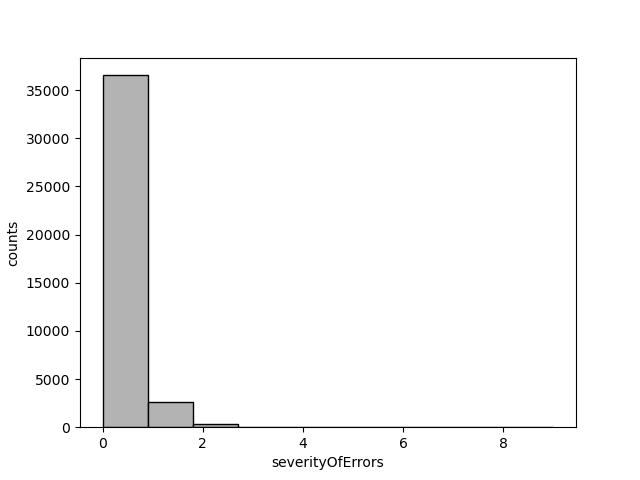

In [ ]:
severityOfErrors = data_subset['severityOfErrors'] 

%matplotlib widget

fig, axs = plt.subplots(1, 1)
axs.hist(severityOfErrors, 
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('severityOfErrors') 
plt.show()

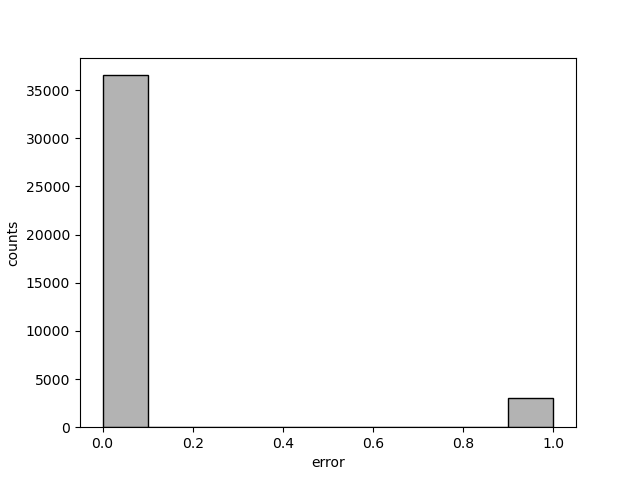

In [ ]:
error = data_subset['error'] 

%matplotlib widget

fig, axs = plt.subplots(1, 1)
axs.hist(error, 
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('error') 
plt.show()

#### number of cities within reach

##### fixed effect

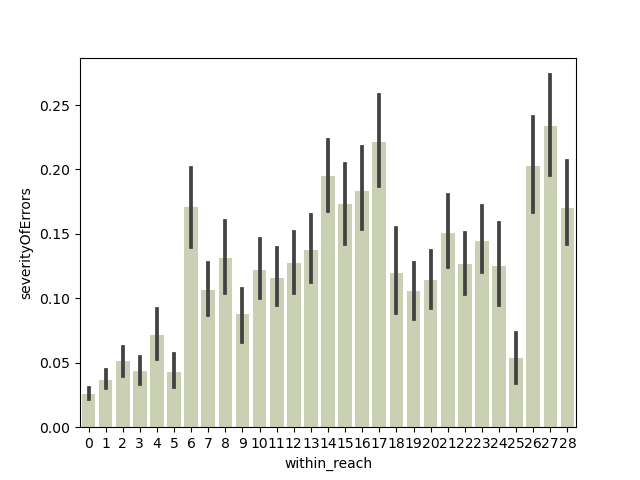

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='within_reach', y='severityOfErrors', data = data_subset, color = '#ccd5ae') 

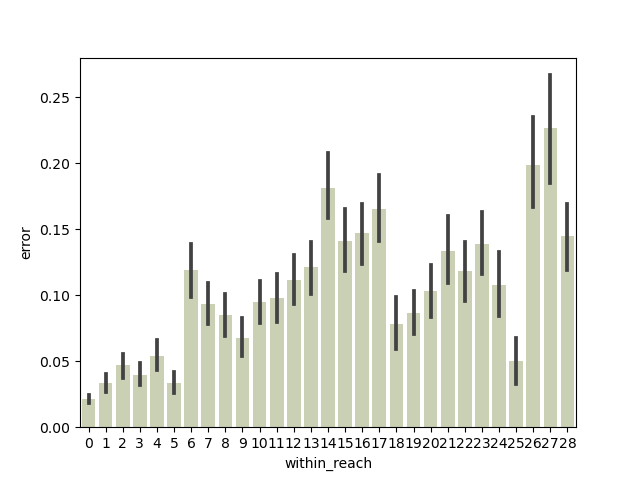

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='within_reach', y='error', data = data_subset, color = '#ccd5ae') 


##### random effect

<AxesSubplot:xlabel='within_reach', ylabel='severityOfErrors'>

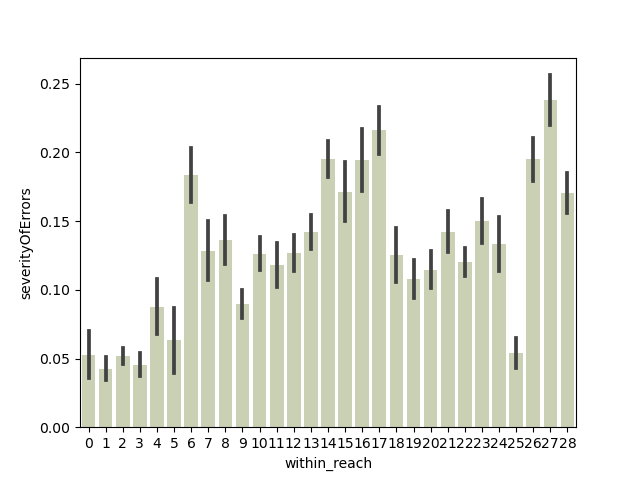

In [ ]:
severityOfErrors_sub = data_subset.groupby(['subjects','within_reach'])['severityOfErrors'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.barplot(x='within_reach', y='severityOfErrors', data = severityOfErrors_sub, errorbar = "se", color = '#ccd5ae') 


<AxesSubplot:xlabel='within_reach', ylabel='error'>

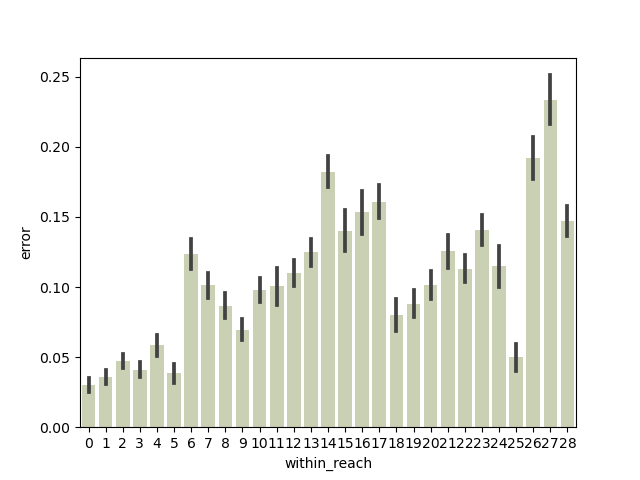

In [ ]:
error_sub = data_subset.groupby(['subjects','within_reach'])['error'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.barplot(x='within_reach', y='error', data = error_sub, errorbar = "se", color = '#ccd5ae') 


#### § current number of connected citie

##### fixed effect

In [ ]:
error_step = data_subset.groupby(['currNumCities'])['error'].mean().to_frame()

print(error_step)

                      error
currNumCities_new          
1                  0.276347
2                  0.086463
3                  0.073558
4                  0.080328
5                  0.060438
6                  0.033258
7                  0.032734
8                  0.004199
9                  0.012042
10                 0.012567
11                 0.000000


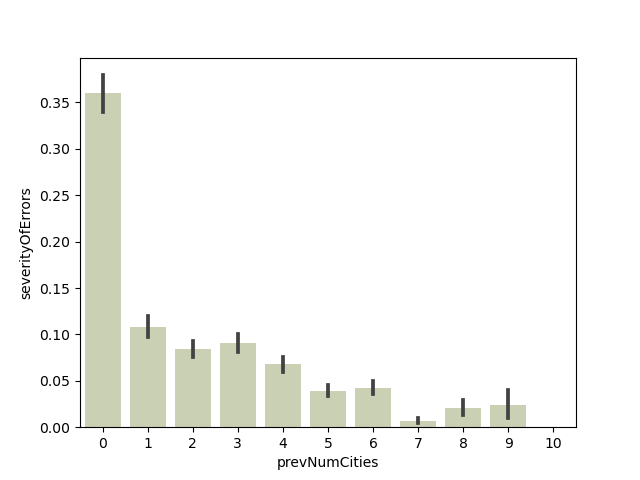

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='prevNumCities', y='severityOfErrors', data = data_cond0_outcome, color = '#ccd5ae') 

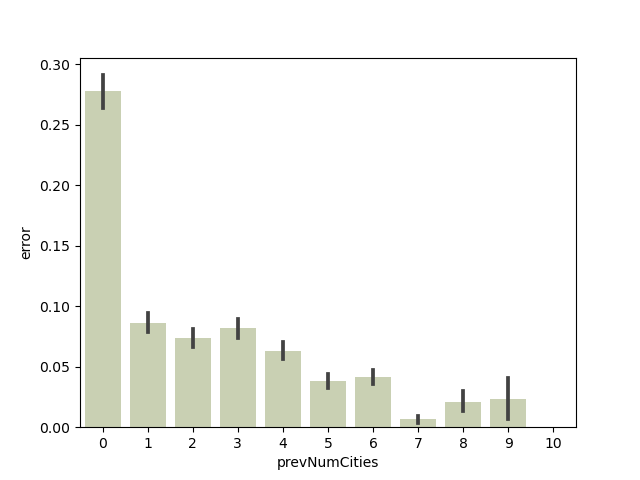

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='prevNumCities', y='error', data = data_cond0_outcome, color = '#ccd5ae') 


##### § random effect

<AxesSubplot:xlabel='prevNumCities', ylabel='severityOfErrors'>

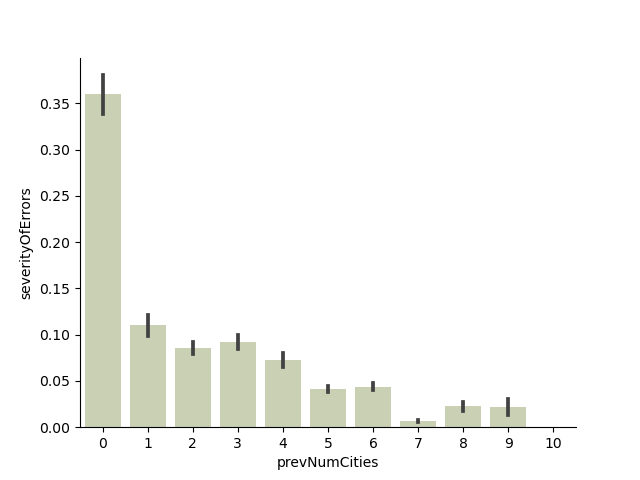

In [ ]:
severityOfErrors_sub = data_cond0_outcome.groupby(['subjects','prevNumCities'])['severityOfErrors'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.barplot(x='prevNumCities', y='severityOfErrors', data = severityOfErrors_sub, errorbar = "se", color = '#ccd5ae') 


prevNumCities  allMAS  error
0               0       8    100
1               0       9    100
2               1       8    100
3               1       9    100
4               2       8    100
5               2       9    100
6               3       8    100
7               3       9    100
8               4       8    100
9               4       9    100
10              5       8    100
11              5       9    100
12              6       8     98
13              6       9     99
14              7       8     94
15              7       9     97
16              8       9     93

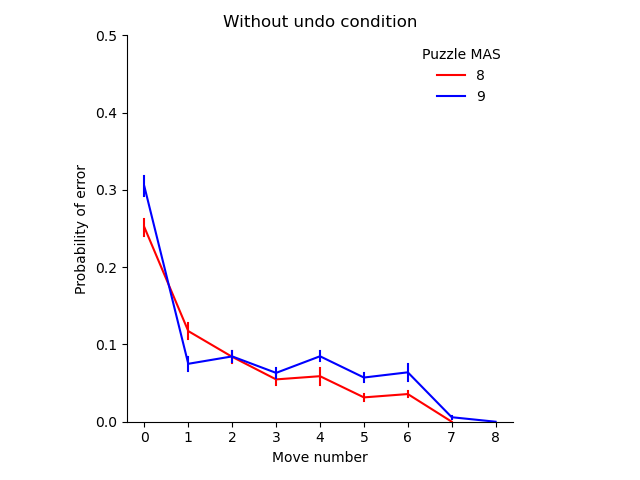

In [ ]:
error_sub = data_cond0_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Without undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

0.11001802409003511
0.13734618457502284


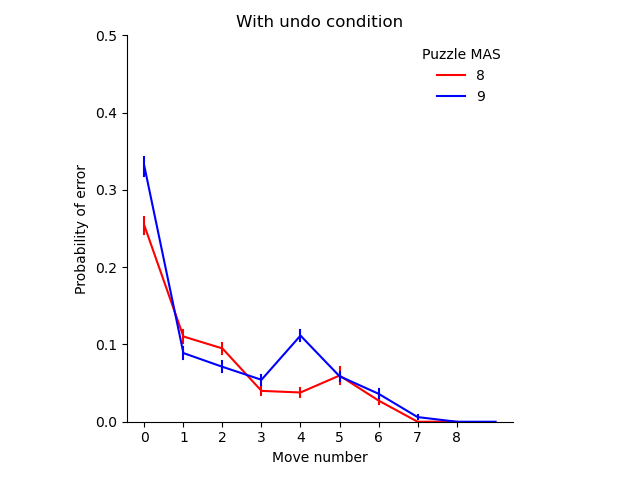

In [ ]:
error_sub = data_cond1_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

puzzleCount = data_cond1_outcome.loc[(data_cond1_outcome.allMAS==9)&(data_cond1_outcome.prevNumCities==4),:].groupby(['puzzleID'])["error"].mean().reset_index()
print(np.mean(puzzleCount.error))
print(np.std(puzzleCount.error))

prevNumCities  allMAS  error
0               0       8     85
1               0       9     82
2               1       8     84
3               1       9     81
4               2       8     82
5               2       9     77
6               3       8     82
7               3       9     76
8               4       8     79
9               4       9     75
10              5       8     77
11              5       9     75
12              6       8     69
13              6       9     73
14              7       8     40
15              7       9     66
16              8       9     36

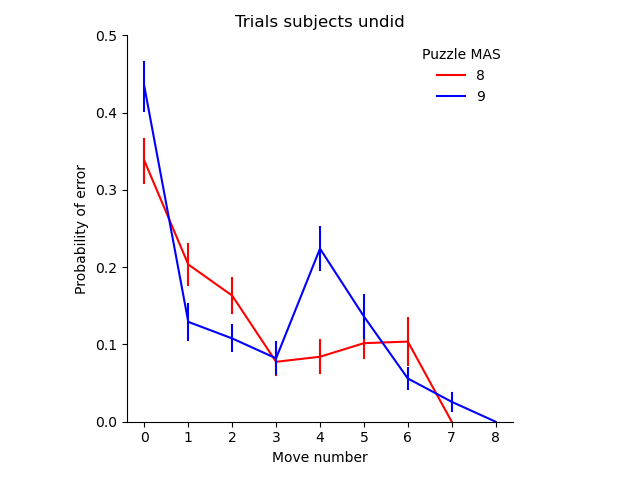

In [ ]:
error_sub = data_cond1_undo_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Trials subjects undid")
# set x_ticks
axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

##### GLM 

In [ ]:
%%R
model_error = lme4::glmer(error ~  1 + z_currNumCities + (1 |subjects),
                                  data = data_choice_level[data_choice_level$condition==0,], family = "binomial")

# get the coefficients for the best fitting model
summary(model_error)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + z_currNumCities + (1 | subjects)
   Data: data_choice_level[data_choice_level$condition == 0, ]

     AIC      BIC   logLik deviance df.resid 
 20948.0  20974.1 -10471.0  20942.0    44179 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7227 -0.3115 -0.2317 -0.1746  9.7633 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.09434  0.3071  
Number of obs: 44182, groups:  subjects, 100

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.78836    0.03783  -73.71   <2e-16 ***
z_currNumCities -0.60212    0.02063  -29.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
z_currNmCts 0.269 


In [ ]:
%%R -i data_choice_level

data_choice_level$subjects <- as.factor(data_choice_level[,"subjects"])
data_choice_level$z_severityOfErrors<- scale(data_choice_level$severityOfErrors)
data_choice_level$z_currNumCities<- scale(data_choice_level$currNumCities)

model_errorsev = lmerTest::lmer(z_severityOfErrors ~  1 + z_currNumCities + (1|subjects),
                                  data = data_choice_level[data_choice_level$condition==0,], control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model_errorsev)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: z_severityOfErrors ~ 1 + z_currNumCities + (1 | subjects)
   Data: data_choice_level[data_choice_level$condition == 0, ]
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 124489.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4386 -0.3446 -0.2124 -0.0801 25.9177 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.02476  0.1573  
 Residual             0.97415  0.9870  
Number of obs: 44182, groups:  subjects, 100

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      1.682e-02  1.642e-02  9.131e+01   1.024    0.308    
z_currNumCities -1.335e-01  4.564e-03  4.415e+04 -29.249   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
z_currNmCts -0.004
optimizer (optimx) 

In [ ]:
data_subset = data_subset.drop(columns=['branching', 'branchingFirst'])

In [ ]:
%%R -i data_subset

data_subset$subjects <- as.factor(data_subset[,"subjects"])

model_errorsev = brm(severityOfErrors ~  1  + currNumCities + (1 |subjects),
                                  data = data_subset,  
                                  chains = 3, cores = 3, iter = 2000, warmup = 1000, 
                                  family = "zero_inflated_poisson")

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling

Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 


In [ ]:
%%R -i out_dir2
save(model_errorsev, data_subset, file=file.path(out_dir2, file=paste("model_errorsev_brms.RData", sep="")))


In [ ]:
%%R
summary(model_errorsev)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: severityOfErrors ~ 1 + currNumCities + (1 | subjects) 
   Data: data_subset (Number of observations: 35480) 
  Draws: 3 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 3000

Group-Level Effects: 
~subjects (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.36      0.03     0.30     0.43 1.00     1010     1985

Population-Level Effects: 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.49      0.07    -0.62    -0.36 1.00     1572     2176
currNumCities    -0.22      0.01    -0.24    -0.20 1.00     4900     2146

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.66      0.01     0.63     0.68 1.00     3206     2341

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective

#### step

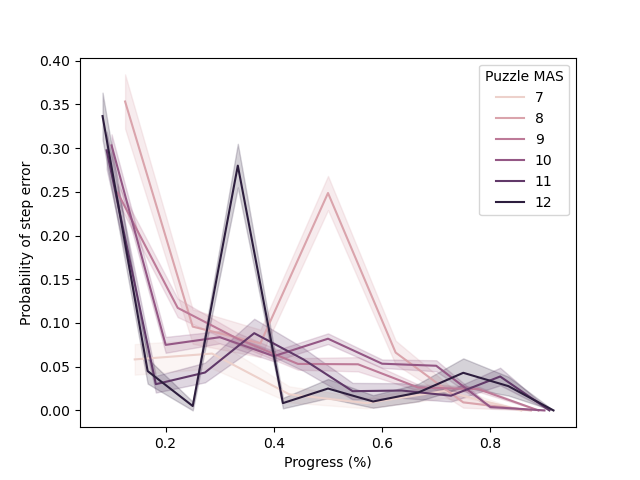

In [ ]:
error_sub = data_cond0_outcome.groupby(['subjects','step',"allMAS"])['error'].mean().reset_index()

%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='step', y='error', hue = "allMAS", data = error_sub, errorbar = "se") 
axs.set(xlabel='Progress (%)', ylabel='Probability of step error')
axs.legend(title = "Puzzle MAS")

#### remaining budget

##### scatter plot

In [ ]:
data_choice_level['z_leftover'] = stats.zscore(data_choice_level.leftover)
data_choice_level['z_severityOfErrors'] = stats.zscore(data_choice_level.severityOfErrors)

0.30977121705391786

<IPython.core.display.Javascript object>


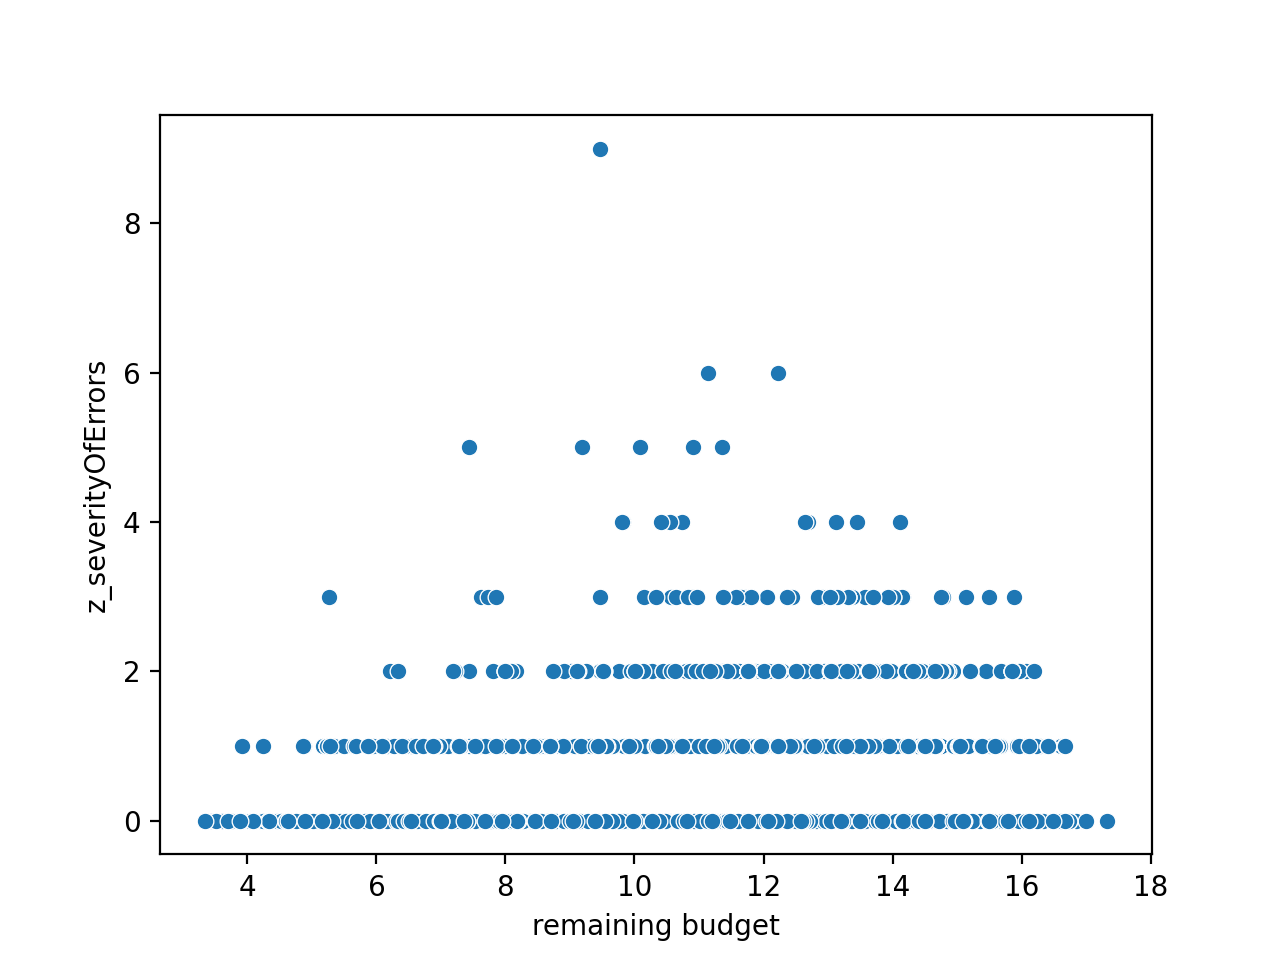

Text(0, 0.5, 'z_severityOfErrors')

In [ ]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='sqrt_leftover', y='severityOfErrors', data=data_subset) 
ax1.set_xlabel("remaining budget")
ax1.set_ylabel("z_severityOfErrors")

##### GLM

In [ ]:
%%R -i data_subset

data_subset$subjects <- as.factor(data_subset[,"subjects"])

model_error = lme4::glmer(error ~  1 + sqrt_leftover + (1 |subjects),
                                  data = data_subset, family = "binomial")

# get the coefficients for the best fitting model
summary(model_error)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + sqrt_leftover + (1 | subjects)
   Data: data_subset

     AIC      BIC   logLik deviance df.resid 
 19609.7  19635.2  -9801.9  19603.7    35477 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6578 -0.3110 -0.2821 -0.2538  5.1182 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1091   0.3303  
Number of obs: 35480, groups:  subjects, 100

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.943430   0.082515 -35.671  < 2e-16 ***
sqrt_leftover  0.038325   0.005803   6.605 3.99e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sqrt_leftvr -0.883
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00226131 (tol = 0.002, component 1)



In [ ]:
%%R 

data_choice_level$z_leftover<- scale(data_choice_level$leftover)

model_errorsev2 = lmerTest::lmer(z_severityOfErrors ~  1 + z_leftover + (1|subjects),
                                  data = data_choice_level[data_choice_level$condition==0,], control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model_errorsev2)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: z_severityOfErrors ~ 1 + z_leftover + (1 | subjects)
   Data: data_choice_level[data_choice_level$condition == 0, ]
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 125190.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3972 -0.2868 -0.2163 -0.1474 25.8268 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.02863  0.1692  
 Residual             0.98947  0.9947  
Number of obs: 44182, groups:  subjects, 100

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.357e-02  1.758e-02 9.240e+01   0.772    0.442    
z_leftover  5.556e-02  4.608e-03 4.412e+04  12.056   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
z_leftover -0.008


In [ ]:
%%R

model_errorsev2 = brm(severityOfErrors ~  1  + sqrt_leftover + (1 |subjects),
                                  data = data_subset,  
                                  chains = 3, cores = 3, iter = 2000, warmup = 1000, 
                                  family = "zero_inflated_poisson")

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling

Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 


In [ ]:
%%R -i out_dir2
save(model_errorsev2, data_subset, file=file.path(out_dir2, file=paste("model_errorsev2_brms.RData", sep="")))


In [ ]:
%%R
summary(model_errorsev2)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: severityOfErrors ~ 1 + sqrt_leftover + (1 | subjects) 
   Data: data_subset (Number of observations: 35480) 
  Draws: 3 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 3000

Group-Level Effects: 
~subjects (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.39      0.03     0.33     0.46 1.00      781     1303

Population-Level Effects: 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.68      0.10    -1.87    -1.49 1.00     2309     2316
sqrt_leftover     0.03      0.01     0.02     0.05 1.00     5307     2173

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.68      0.01     0.66     0.71 1.00     3518     2109

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective

### the puzzle is difficult; the puzzle has multiple similar solutions

#### basic distributions

<IPython.core.display.Javascript object>


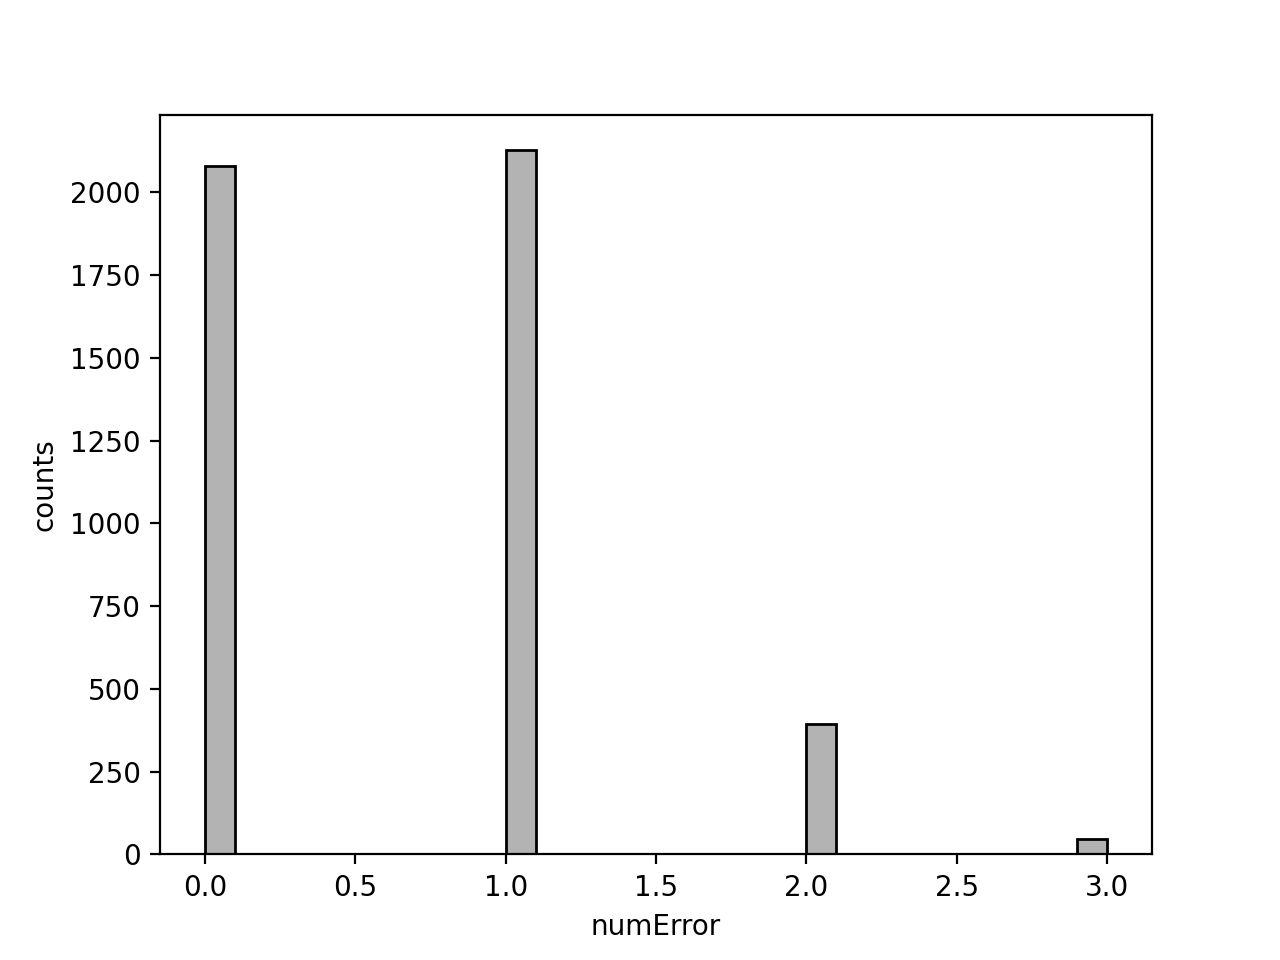

In [ ]:
basic_error = np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['numError'])  

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(basic_error, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('numError') 
plt.show()

<IPython.core.display.Javascript object>


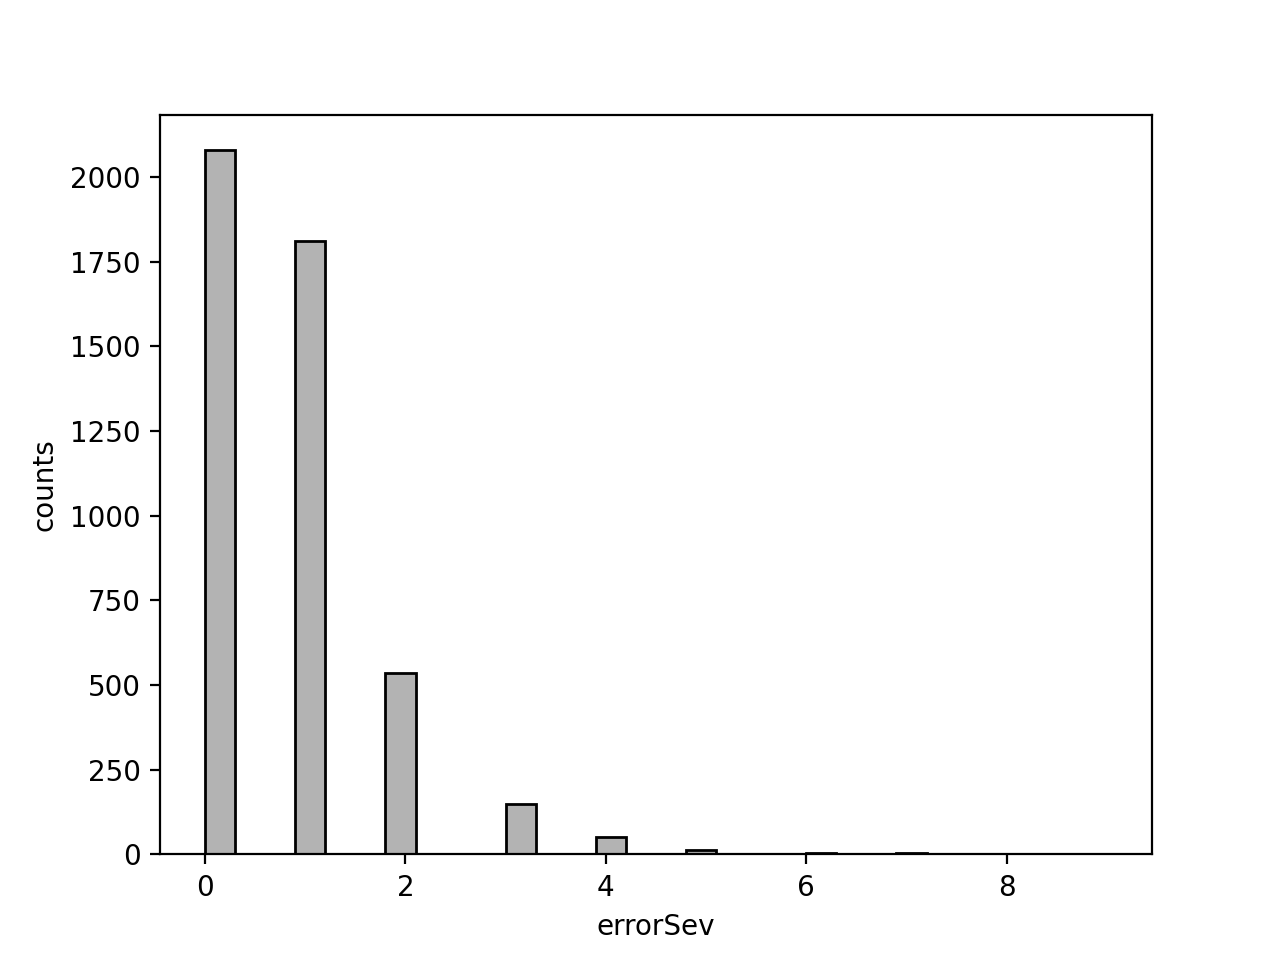

In [ ]:
errorSev = np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['sumSeverityErrors'])  

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(errorSev, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('errorSev') 
plt.show()

<IPython.core.display.Javascript object>


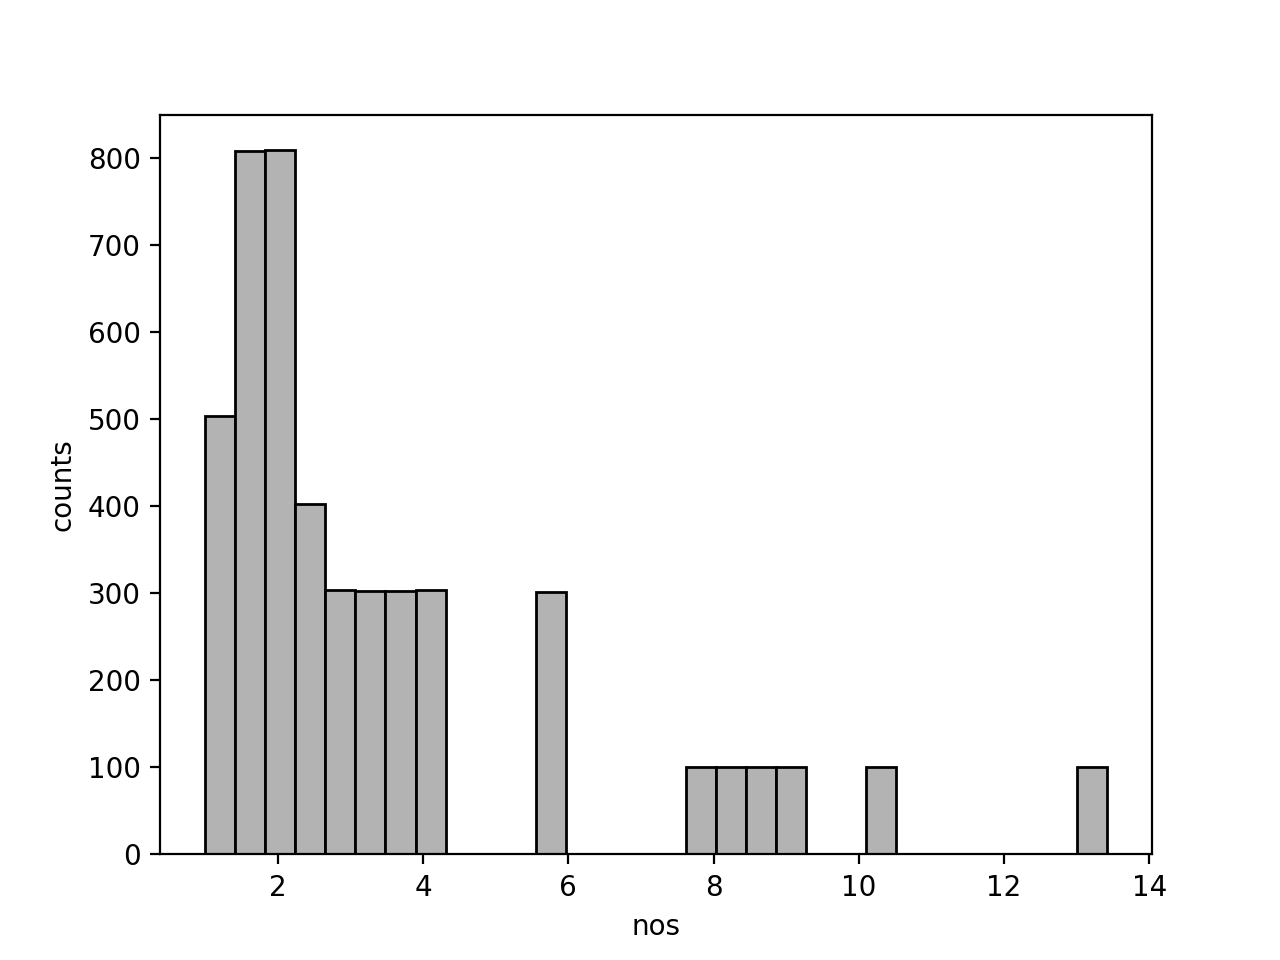

In [ ]:
n_optimal = np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['sqrt_nos']) 

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(n_optimal, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('nos') 
plt.show()

In [ ]:
n_optimal_bin = (puzzleID_order_data[puzzleID_order_data['condition']==0]).groupby(["nos"])['numError'].count()
print(n_optimal_bin)

nos
1      504
2      606
3      202
4      303
5      506
6      403
8      203
9      101
10     101
12     202
13     303
16     202
17     102
31     100
33     101
34     101
60     101
70     101
76     101
84     101
104    101
180    101
Name: numError, dtype: int64


<IPython.core.display.Javascript object>


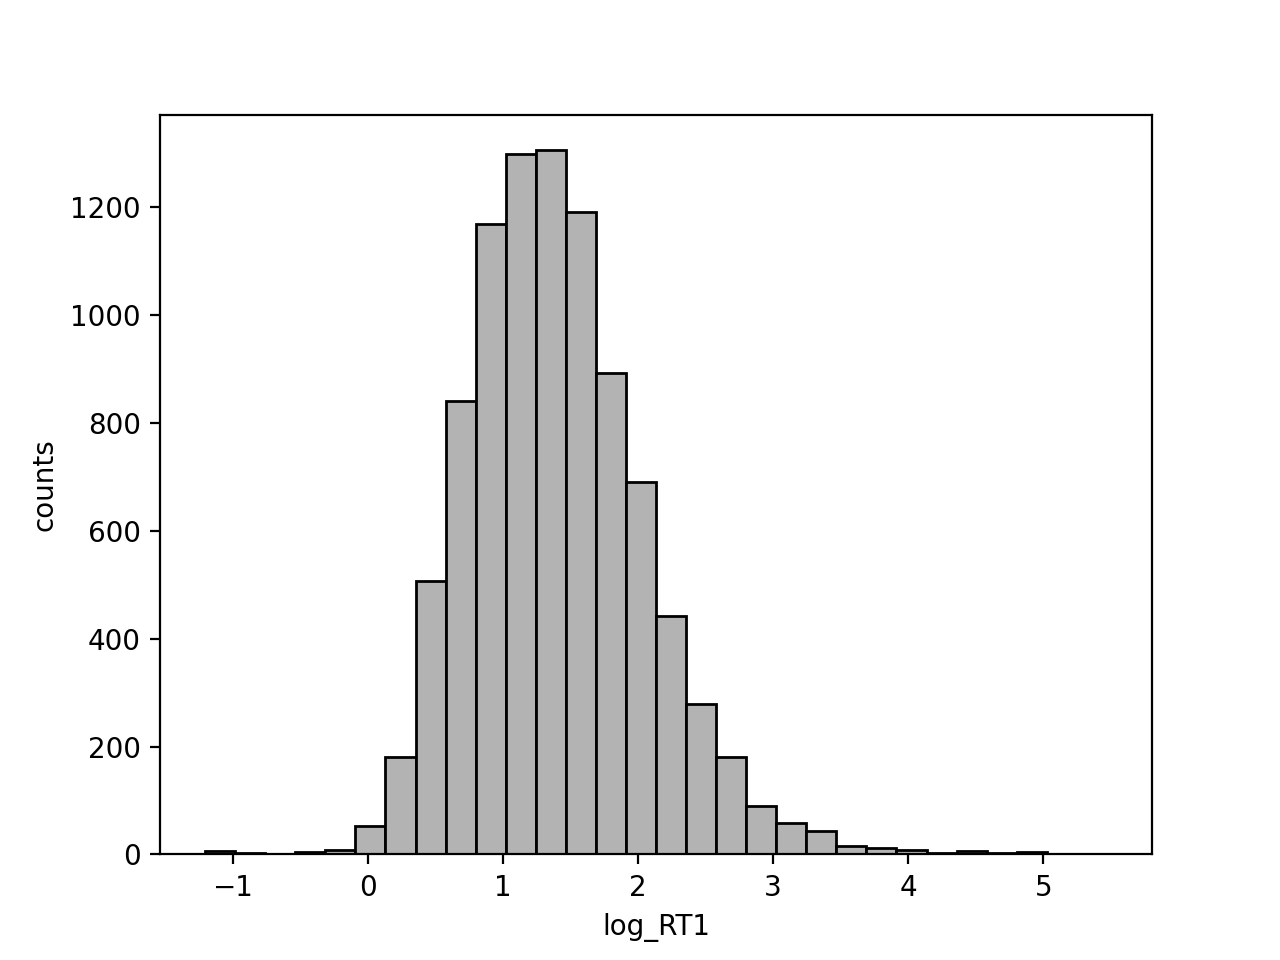

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(puzzleID_order_data.log_RT1, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('log_RT1') 
plt.show()

#### number of optimal solutions

In [ ]:
# bins1 = stats.binned_statistic(n_optimal, error_basic, 'mean', bins=[1,3,6,9,200])
# bins2 = stats.binned_statistic(n_optimal, error_undo, 'mean', bins=[1,3,6,9,15])

bins0 = (puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects', pd.cut(puzzleID_order_data.nos,[1,4,8,12,17,34,76,180])])['numError'].mean()).reset_index()


<IPython.core.display.Javascript object>


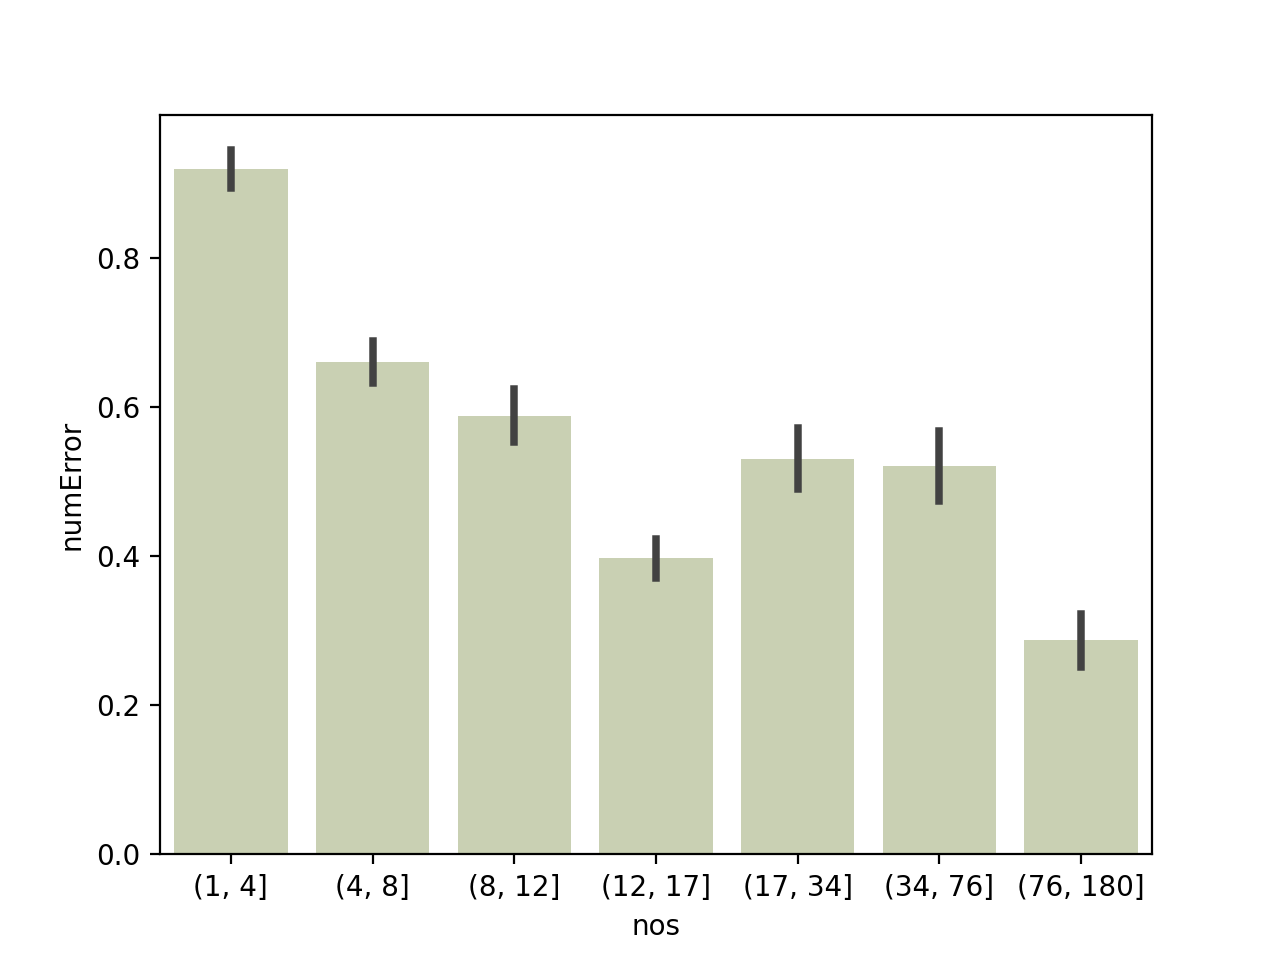

In [ ]:
fig, axs = plt.subplots()         

# axs.plot(bins1[1][:-1], bins1[0], color = '#81b29a', linewidth=3,label='basic')

# sub_n = len(np.unique(puzzleID_order_data.subjects))
# x = range(len(bins00))
# y1 = bins00.mean()
# c1 = bins00.std()/np.sqrt(sub_n)

# axs.plot(x,y1 , color = '#81b29a', linewidth=3, label = 'Self')
# axs.fill_between(x, (y1-c1), (y1+c1), color='#81b29a', alpha=.1)

axs = sns.barplot(x='nos', y='numError', data = bins0, errorbar = "se", color = '#ccd5ae') 
# axs.set_xlabel('number of optimal solutions')
# axs.set_ylabel('count of error')
# axs.set_xticks([1,3,6,9])
# axs.set_xticklabels(["1-45","3,6,'9+'])
# axs.legend()
# fig.savefig(out_dir + 'error_optimal.png', dpi=600, bbox_inches='tight')

In [ ]:
# # seems to be not true
# # non-parametric version of anova (because number of observations is different: 
# # https://www.reneshbedre.com/blog/anova.html
# # Kruskal-Wallis Test
# stat1, p1 = stats.kruskal(error_basic[(n_optimal<3) & (n_optimal>=1)], error_basic[(n_optimal<6) & (n_optimal>=3)], error_basic[(n_optimal<9) & (n_optimal>=6)],error_basic[n_optimal>=9])
# x1, x2 = 1,9
# y, h, col = bins1[0][0] + 0.05, 0, 'k'
# axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# text(p1)

In [ ]:
# bins0['nos_factor'] = bins0['nos'].astype(str).str.replace(r'\((\d+)\s*,\s*(\d+)]', r'\1', regex=True)
# bins0['nos_factor'] = pd.to_numeric(bins0.nos_factor, errors='coerce')
# bins0 = bins0.drop(columns=['nos'])

In [ ]:
bins1 = (puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects',"nos"])['numError'].mean()).reset_index()
bins1

subjects  nos  numError
0            1    1  1.400000
1            1    2  1.166667
2            1    3  1.000000
3            1    4  1.000000
4            1    5  0.800000
...        ...  ...       ...
2216       101   70  0.000000
2217       101   76  1.000000
2218       101   84  1.000000
2219       101  104  0.000000
2220       101  180  0.000000

[2221 rows x 3 columns]

<IPython.core.display.Javascript object>


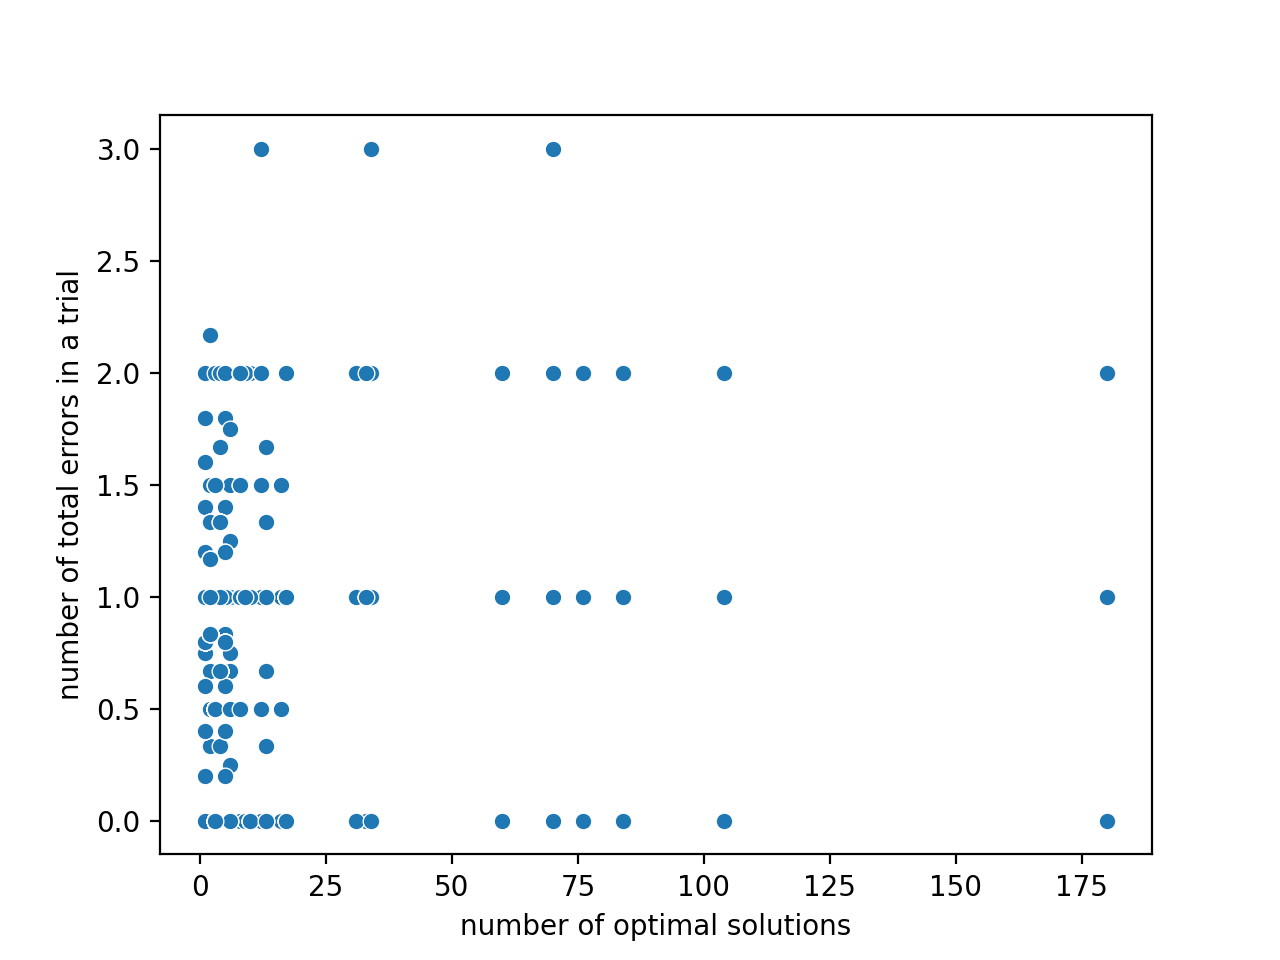

Text(0, 0.5, 'number of total errors in a trial')

In [ ]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='nos', y='numError', data=bins1) 
ax1.set_xlabel("number of optimal solutions")
ax1.set_ylabel("number of total errors in a trial")

In [ ]:
%%R -i bins1

# bins0$nos_factor <- as.factor(bins0$nos_factor)

model_numError = lmerTest::lmer(numError ~  1 + nos + (1 |subjects),
                                  data = bins1, control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model_numError)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: numError ~ 1 + nos + (1 | subjects)
   Data: bins1
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 3545.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0404 -0.8060 -0.1409  0.7101  4.9123 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.03938  0.1985  
 Residual             0.26835  0.5180  
Number of obs: 2221, groups:  subjects, 101

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  6.648e-01  2.431e-02  1.337e+02   27.35   <2e-16 ***
nos         -2.886e-03  2.532e-04  2.119e+03  -11.40   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
nos -0.368


In [ ]:
data_subset2 = puzzleID_order_data[puzzleID_order_data['condition']==0]

In [ ]:
%%R -i data_subset2

data_subset2$subjects <- as.factor(data_subset2[,"subjects"])
model_numError = lme4::glmer(numError ~  1 + sqrt_nos + (1 |subjects),
                                  data = data_subset2, family = "poisson")

# get the coefficients for the best fitting model
summary(model_numError)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: numError ~ 1 + sqrt_nos + (1 | subjects)
   Data: data_subset2

     AIC      BIC   logLik deviance df.resid 
  9103.6   9123.0  -4548.8   9097.6     4643 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2810 -0.7511  0.1024  0.4493  4.7650 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.05762  0.24    
Number of obs: 4646, groups:  subjects, 101

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.101082   0.039040  -2.589  0.00962 ** 
sqrt_nos    -0.111019   0.008644 -12.843  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
sqrt_nos -0.630


In [ ]:
%%R 

model_sumSeverityErrors = lme4::glmer(sumSeverityErrors ~  1 + sqrt_nos + (1 |subjects),
                                  data = data_subset2, family = "poisson")

# get the coefficients for the best fitting model
summary(model_sumSeverityErrors)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: sumSeverityErrors ~ 1 + sqrt_nos + (1 | subjects)
   Data: data_subset2

     AIC      BIC   logLik deviance df.resid 
 10272.2  10291.6  -5133.1  10266.2     4643 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7969 -0.7836 -0.0874  0.4611  6.4288 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1171   0.3422  
Number of obs: 4646, groups:  subjects, 101

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.072411   0.044508   1.627    0.104    
sqrt_nos    -0.121716   0.008098 -15.031   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
sqrt_nos -0.509


#### RT of the first move

<IPython.core.display.Javascript object>


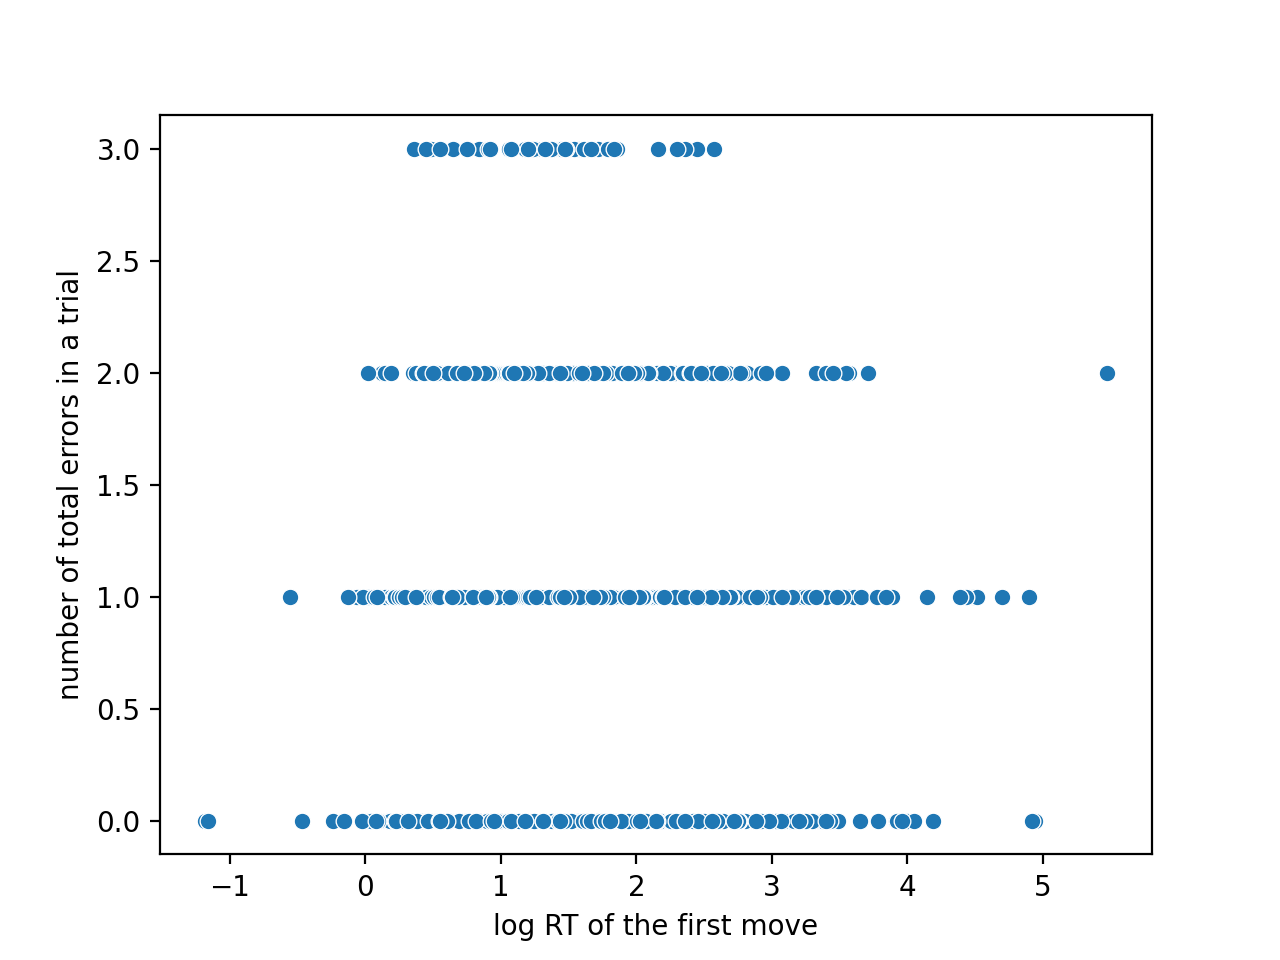

Text(0, 0.5, 'number of total errors in a trial')

In [ ]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='log_RT1', y='numError', data=puzzleID_order_data[puzzleID_order_data['condition']==0]) 
ax1.set_xlabel("log RT of the first move")
ax1.set_ylabel("number of total errors in a trial")

In [ ]:
bins1 = (puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects',"log_RT1"])['numError'].mean()).reset_index()


<IPython.core.display.Javascript object>


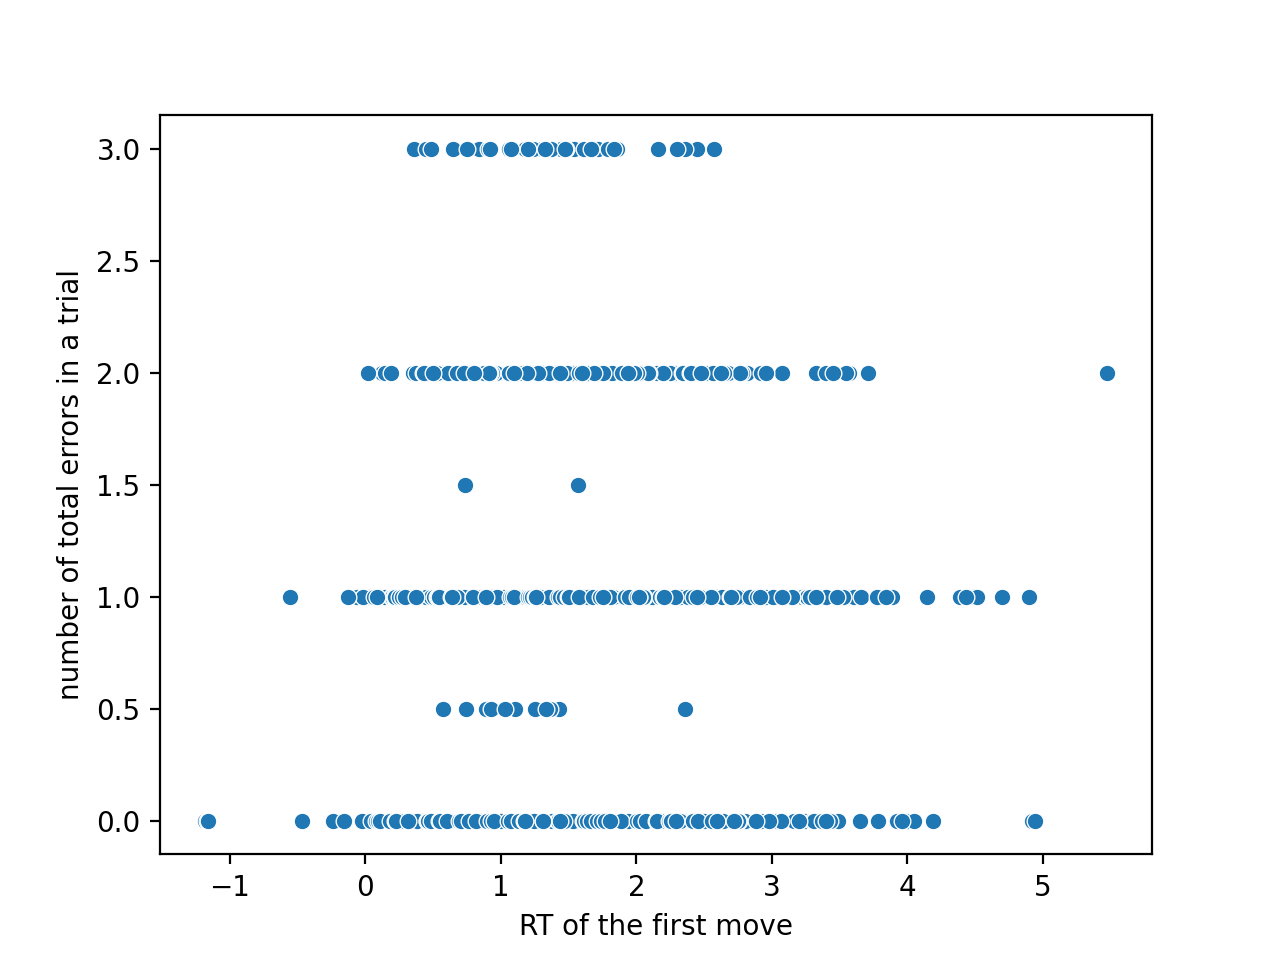

Text(0, 0.5, 'number of total errors in a trial')

In [ ]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='log_RT1', y='numError', data=bins1) 
ax1.set_xlabel("RT of the first move")
ax1.set_ylabel("number of total errors in a trial")

In [ ]:
%%R -i bins1

bins1$z_numError <- scale(bins1$numError)

model_numError = lmerTest::lmer(z_numError ~  1 + log_RT1 + (1 |subjects),
                                  data = bins1, control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model_numError)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: z_numError ~ 1 + log_RT1 + (1 | subjects)
   Data: bins1
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 12904.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5259 -0.9093  0.2498  0.6151  3.8747 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.0814   0.2853  
 Residual             0.9208   0.9596  
Number of obs: 4621, groups:  subjects, 101

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   -0.09457    0.04737  391.63595  -1.996  0.04660 * 
log_RT1        0.06587    0.02430 3785.47600   2.711  0.00674 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
log_RT1 -0.743


In [ ]:
data_subset2 = puzzleID_order_data[puzzleID_order_data['condition']==0]

In [ ]:
%%R -i data_subset2

data_subset2$subjects <- as.factor(data_subset2[,"subjects"])
model_numError_rt1 = lme4::glmer(numError ~  1 + log_RT1 + (1 |subjects),
                                  data = data_subset2, family = "poisson")

# get the coefficients for the best fitting model
summary(model_numError_rt1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: numError ~ 1 + log_RT1 + (1 | subjects)
   Data: data_subset2

     AIC      BIC   logLik deviance df.resid 
  9297.8   9317.1  -4645.9   9291.8     4643 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2567 -0.7697  0.2244  0.5042  3.3863 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.05977  0.2445  
Number of obs: 4646, groups:  subjects, 101

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.53249    0.05415  -9.833   <2e-16 ***
log_RT1      0.05676    0.03024   1.877   0.0606 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
log_RT1 -0.824


In [ ]:
%%R 

model_sumSeverityErrors_rt1 = lme4::glmer(sumSeverityErrors ~  1 + log_RT1 + (1 |subjects),
                                  data = data_subset2, family = "poisson")

# get the coefficients for the best fitting model
summary(model_sumSeverityErrors_rt1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: sumSeverityErrors ~ 1 + log_RT1 + (1 | subjects)
   Data: data_subset2

     AIC      BIC   logLik deviance df.resid 
 10535.0  10554.3  -5264.5  10529.0     4643 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7800 -0.8133  0.0127  0.4866  6.6193 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.124    0.3521  
Number of obs: 4646, groups:  subjects, 101

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.45562    0.05803  -7.851 4.12e-15 ***
log_RT1      0.10167    0.02875   3.536 0.000406 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
log_RT1 -0.738


#### RT for the first visit of the branching node

In [ ]:
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

In [ ]:
for i in range(len(subjects_chosen)):
    index_chosen = (puzzleID_order_data['condition']==0)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])
    puzzleID_order_data.loc[index_chosen,'logRT_branching'] = np.log(RT_branching[i])


In [ ]:
data_subset3 = puzzleID_order_data[(puzzleID_order_data['condition']==0)&(puzzleID_order_data['logRT_branching'].notna())]
data_subset3

subjects  puzzleID  reward  numCities  mas  nos   leftover  numError  \
42           1         0      81          9    9  104   1.370288         0   
65           1         1      36          6    7    6  26.517790         1   
26           1         2     100         10   10   70  28.398264         0   
60           1         3      64          8   10   34  34.928176         2   
64           1         4      81          9   10    4  23.407812         1   
...        ...       ...     ...        ...  ...  ...        ...       ...   
9035        99        35      81          9   11    5  37.292024         2   
9018        99        38      64          8    9   33  14.552284         1   
9097        99        42      81          9    9   16  14.438090         0   
9017        99        44      49          7    7   13   6.619204         0   
9093        99        45      64          8   10    6  15.023858         1   

      sumSeverityErrors  condition  ...  numEnd      TT     RT1   RTlater  \
42                    0          0  ...       1  21.322   6.783  2.442125   
65                    1          0  ...       1  22.238   8.734  4.151000   
26                    0          0  ...       1  19.989   4.687  2.051000   
60                    2          0  ...       1  29.898  11.296  3.394571   
64                    1          0  ...       1  24.036   4.166  2.822625   
...                 ...        ...  ...     ...     ...     ...       ...   
9035                  2          0  ...       1  14.878   6.926  1.672375   
9018                  1          0  ...       1  23.708  12.798  3.179571   
9097                  0          0  ...       1  13.359   6.094  1.505625   
9017                  0          0  ...       1  25.874  13.284  4.039167   
9093                  2          0  ...       1  12.411   3.662  1.572000   

      RTsubmit  tortuosity   sqrt_nos   log_RT1  RT_branching  logRT_branching  
42       1.608    1.342376  10.198039  1.914419      7.533694         7.533694  
65       1.307    1.337629   2.449490  2.167223      7.202661         7.202661  
26       1.268    1.479509   8.366600  1.544793      8.638880         8.638880  
60       5.959    1.796117   5.830952  2.424449      8.652423         8.652423  
64       1.192    1.743301   2.000000  1.426956      7.411556         7.411556  
...        ...         ...        ...       ...           ...              ...  
9035     1.267    1.737237   2.236068  1.935282      6.586172         6.586172  
9018     1.242    1.816113   5.744563  2.549289      7.165493         7.165493  
9097     1.071    1.339191   4.000000  1.807305      8.649274         8.649274  
9017     1.387    1.339582   3.605551  2.586560      9.130431         9.130431  
9093     1.141    1.769390   2.449490  1.298009      8.695674         8.695674  

[1362 rows x 22 columns]

<IPython.core.display.Javascript object>


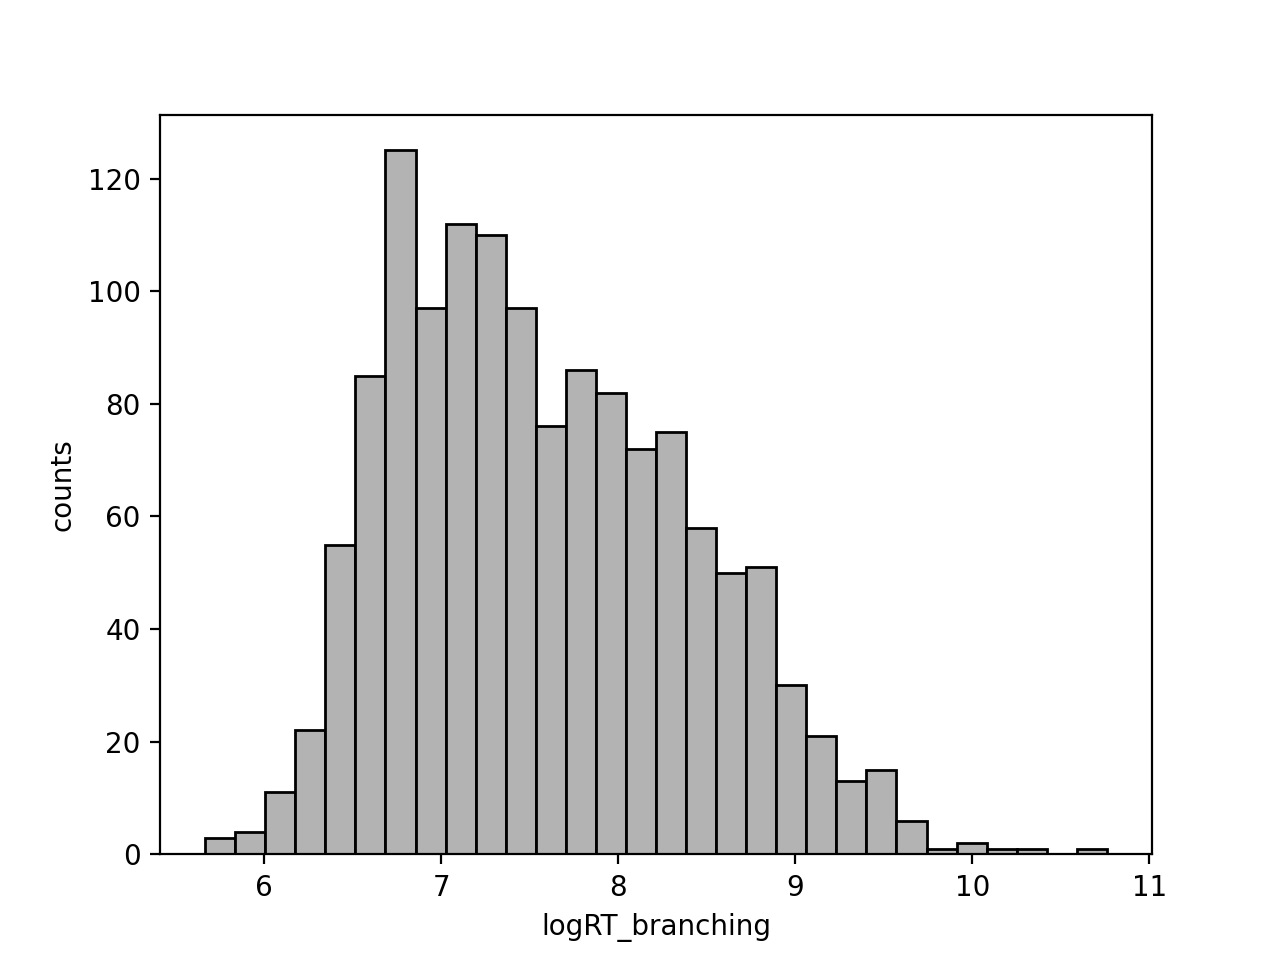

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(data_subset3.logRT_branching, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('logRT_branching') 
plt.show()

In [ ]:
%%R -i data_subset3

data_subset3$subjects <- as.factor(data_subset3[,"subjects"])
model_numError3 = lme4::glmer(numError ~  1 + logRT_branching + (1 |subjects),
                                  data = data_subset3, family = "poisson")

# get the coefficients for the best fitting model
summary(model_numError3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: numError ~ 1 + logRT_branching + (1 | subjects)
   Data: data_subset3

     AIC      BIC   logLik deviance df.resid 
  2735.1   2750.8  -1364.6   2729.1     1359 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9133 -0.7839  0.3099  0.4601  2.7566 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.03114  0.1765  
Number of obs: 1362, groups:  subjects, 88

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)  
(Intercept)     -0.63456    0.31762  -1.998   0.0457 *
logRT_branching  0.02681    0.04132   0.649   0.5165  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lgRT_brnchn -0.992


In [ ]:
%%R 

model_sumSeverityErrors3 = lme4::glmer(sumSeverityErrors ~  1 + logRT_branching + (1 |subjects),
                                  data = data_subset3, family = "poisson")

# get the coefficients for the best fitting model
summary(model_sumSeverityErrors3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: sumSeverityErrors ~ 1 + logRT_branching + (1 | subjects)
   Data: data_subset3

     AIC      BIC   logLik deviance df.resid 
  3085.6   3101.3  -1539.8   3079.6     1359 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1177 -0.7928  0.0140  0.4838  4.9827 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1414   0.3761  
Number of obs: 1362, groups:  subjects, 88

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)     -0.46101    0.30634  -1.505    0.132
logRT_branching  0.02149    0.03943   0.545    0.586

Correlation of Fixed Effects:
            (Intr)
lgRT_brnchn -0.984


### RT (as approximation to uncertainty) and error correlation

In [ ]:
data_subset = data_choice_level.loc[(data_choice_level.RT != -1), ["subjects","condition","error","RT"]]

<IPython.core.display.Javascript object>


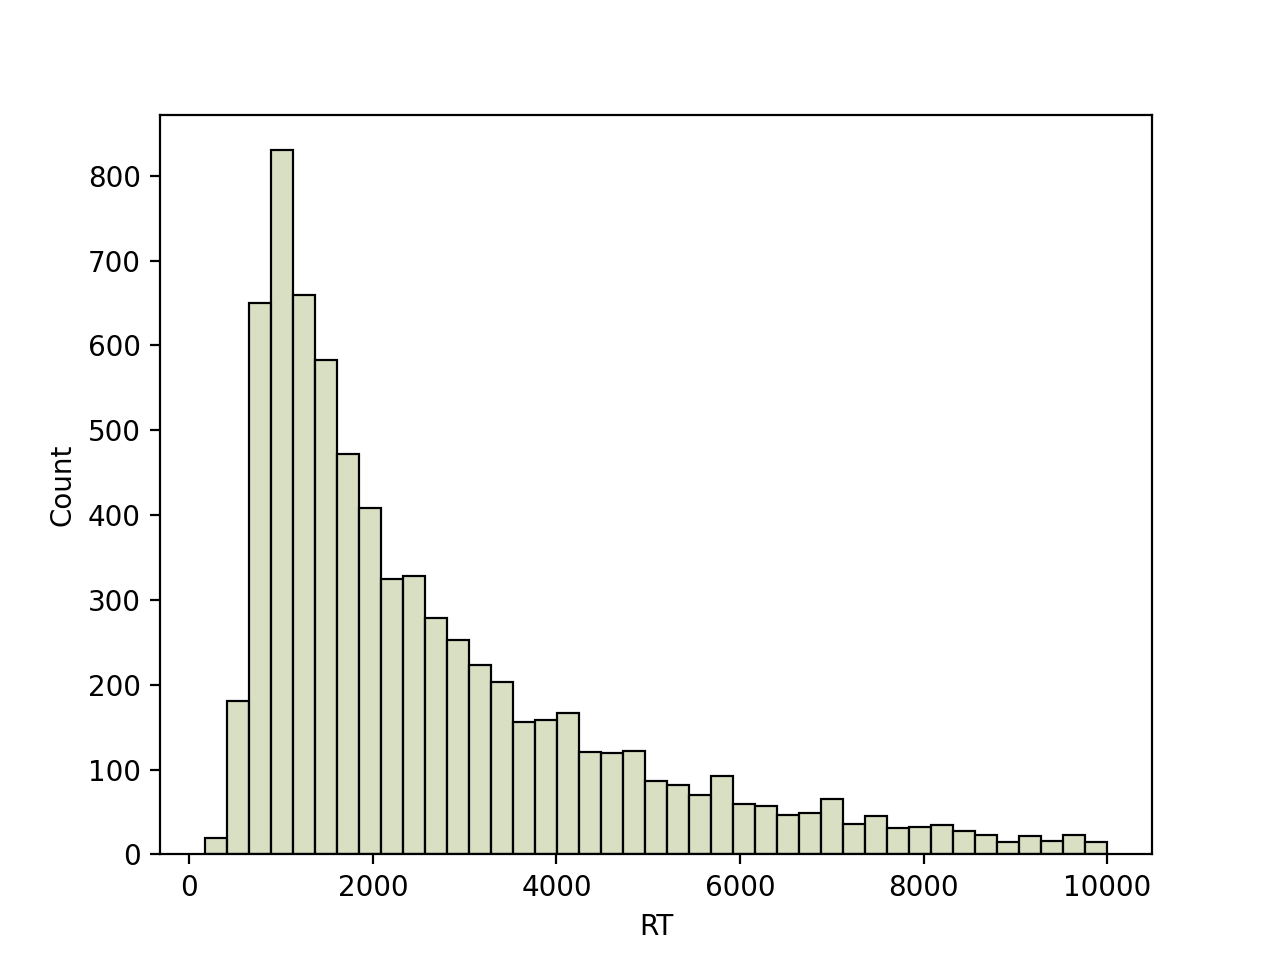

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1, 1)

#bx = sns.barplot(x='error', y='RT', data = data_subset, color = '#ccd5ae') 
bx = sns.histplot(x='RT', data = data_subset[(data_subset.RT<=10000)&(data_subset.error==1)], color = '#ccd5ae') 

In [ ]:
%%R -i data_subset

data_subset$subjects <- as.factor(data_subset[,"subjects"])
data_subset$z_RT<- scale(data_subset$RT)
data_subset

model_RT = lme4::glmer(error ~  1 + z_RT + (1 |subjects),
                                  data = data_subset[data_subset$condition==0,], family = "binomial")

# get the coefficients for the best fitting model
summary(model_RT)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + z_RT + (1 | subjects)
   Data: data_subset[data_subset$condition == 0, ]

     AIC      BIC   logLik deviance df.resid 
 20579.5  20605.3 -10286.8  20573.5    39579 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1836.26    -0.29    -0.26    -0.23     5.71 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1647   0.4059  
Number of obs: 39582, groups:  subjects, 100

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.59971    0.04544  -57.21   <2e-16 ***
z_RT         0.39590    0.01760   22.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
z_RT -0.110


## Cumulative Error Magnitude

### basic distributions before firstUndo

<IPython.core.display.Javascript object>


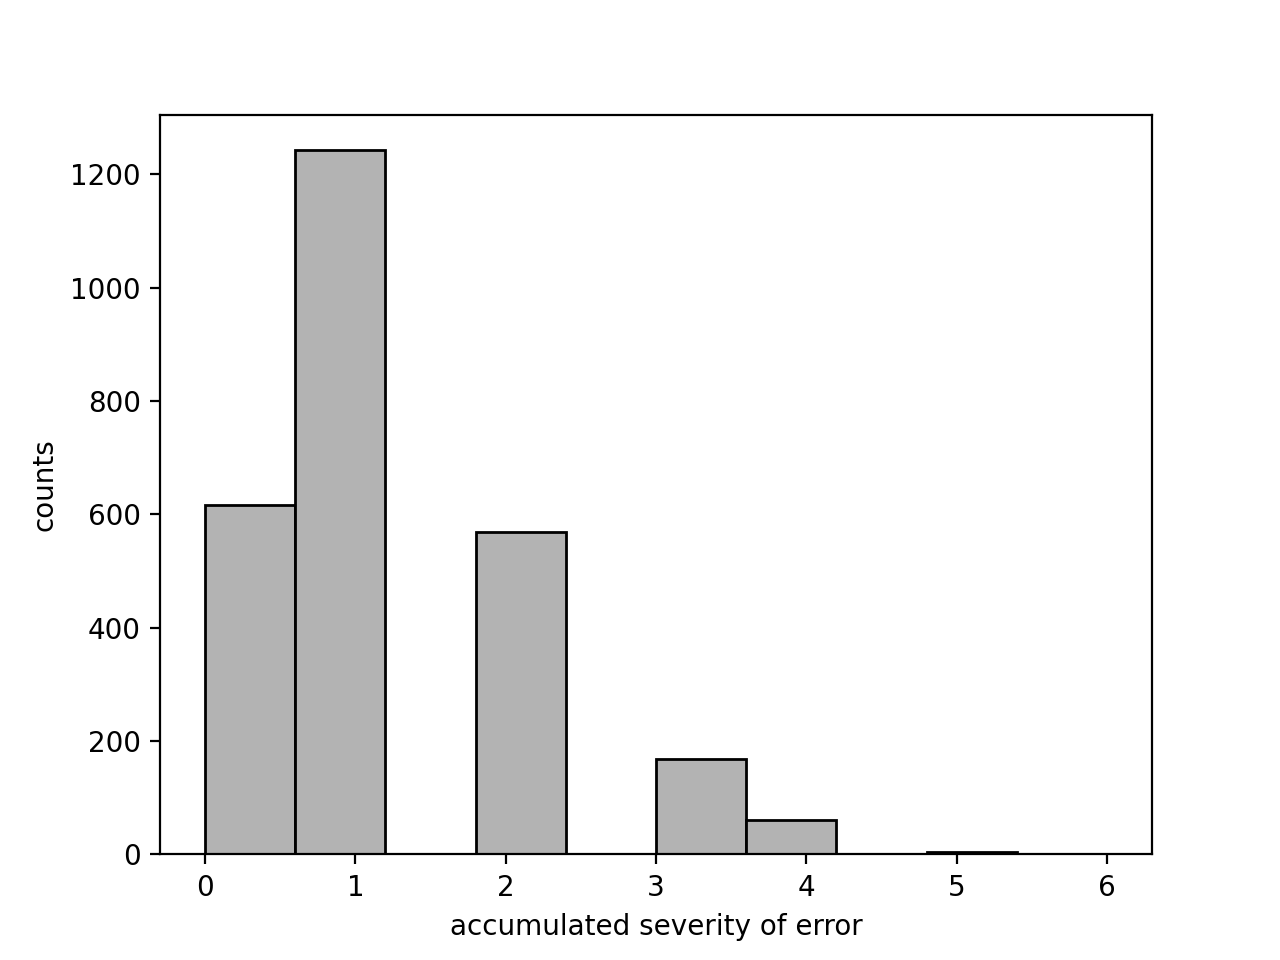

In [ ]:
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]

# MAS_trial = df_beforeUndo['allMAS']
accu_severity_error = df_beforeUndo['allMAS'] - df_beforeUndo['currMas']

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(accu_severity_error,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('accumulated severity of error') 
plt.show()

1    0.466917
0    0.231579
2    0.213534
3    0.063534
4    0.022556
5    0.001504
6    0.000376
dtype: float64


<IPython.core.display.Javascript object>


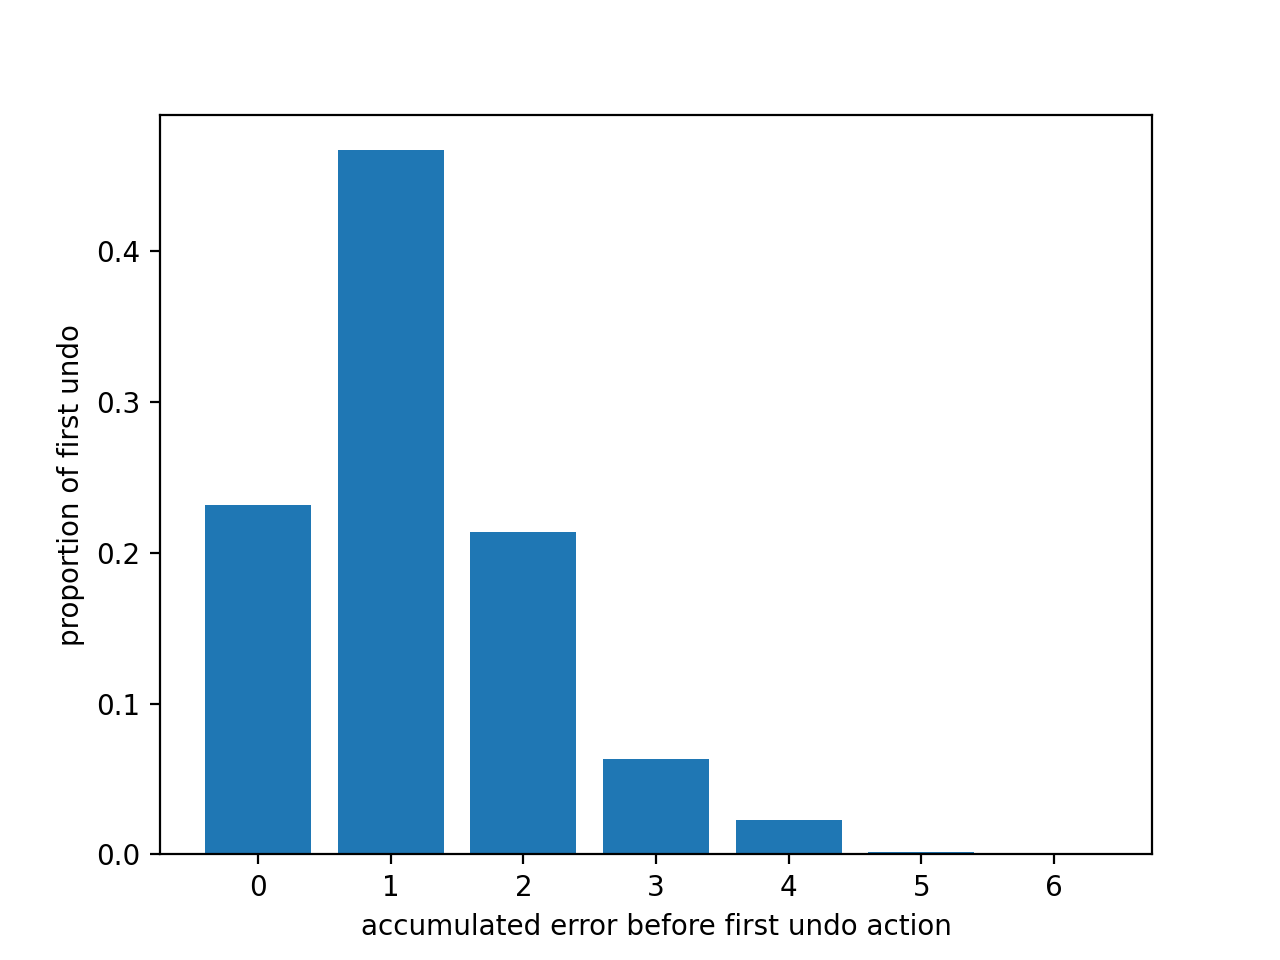

In [ ]:
groupby_error = accu_severity_error.value_counts()
print(groupby_error/sum(groupby_error))

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar(groupby_error.index,groupby_error/sum(groupby_error))
axs.set_ylabel('proportion of first undo')
axs.set_xlabel('accumulated error before first undo action')
plt.show()
# fig.savefig(out_dir + 'undo_accumulated_error.pdf', dpi=600, bbox_inches='tight')

### probability of undo -- conditional on error

#### [discarded]

In [ ]:
# FROM EACH SUBJECT
dat_subjects = []
for i in np.unique(np.array(data_choice_level_df['subjects'])):
    
#     temp_data = []
    undo_list_no = []
    undo_list_yes = []
    
    for j in np.unique(sc_data_choice_level['puzzleID']):
        
#         temp_data_puz =[]
        dat_sbj_pzi =  data_choice_level_df[(data_choice_level_df.subjects == i)&(data_choice_level_df.puzzleID == j)].reset_index()
        puzzle_error = dat_sbj_pzi['allMAS'] - dat_sbj_pzi['currMas']
        # no error --------------------------------------------------
        index_error = puzzle_error.index[puzzle_error == 0]
        index_error = np.array(index_error)
        index_error += 1
        if np.any(index_error>(dat_sbj_pzi.shape[0]-1)):
            index_error = np.delete(index_error, np.where(index_error>(dat_sbj_pzi.shape[0]-1)))
        
#         undo_list_no = []
        for ind in index_error:    
            if (dat_sbj_pzi.firstUndo[ind] == 0)&(dat_sbj_pzi.lastUndo[ind] == 0)&(dat_sbj_pzi.currNumCities[ind-1] > 1):
                undo_list_no.append(0)
            elif (dat_sbj_pzi['firstUndo'][ind] == 1):
                undo_list_no.append(1)

#         temp_data_puz.append(np.mean(undo_list_no))
        
        # YES error --------------------------------------------------
        index_error = puzzle_error.index[puzzle_error != 0]
        index_error = np.array(index_error)
        index_error += 1
        if np.any(index_error>(dat_sbj_pzi.shape[0]-1)):
            index_error = np.delete(index_error, np.where(index_error>(dat_sbj_pzi.shape[0]-1)))
        
#         undo_list_yes = []
        for ind in index_error:    
            if (dat_sbj_pzi.firstUndo[ind] == 0)&(dat_sbj_pzi.lastUndo[ind] == 0)&(dat_sbj_pzi.currNumCities[ind-1] > 1):
                undo_list_yes.append(0)
            elif (dat_sbj_pzi['firstUndo'][ind] == 1):
                undo_list_yes.append(1)

#         temp_data_puz.append(np.mean(undo_list_yes))
    
#         temp_data.append(temp_data_puz)
    
#     dat_subjects.append(np.nanmean(temp_data,axis=0))
    dat_subjects.append([np.nanmean(undo_list_no),np.nanmean(undo_list_yes)])

dat_subjects = np.array(dat_subjects)
dat_subjects[:,0]

array([0.01518987, 0.02617801, 0.03840473, 0.01949318, 0.02552204,
       0.00578035, 0.02028986, 0.00867052, 0.00387597, 0.01034483,
       0.        , 0.01111111, 0.        , 0.00763359, 0.03364486,
       0.02061856, 0.01408451, 0.08965517, 0.01445087, 0.00938967,
       0.        , 0.01769912, 0.        , 0.03376623, 0.03012048,
       0.        , 0.02222222, 0.        , 0.        , 0.04685212,
       0.        , 0.        , 0.00732601, 0.00512821, 0.00704225,
       0.01010101, 0.00943396, 0.00414938, 0.02364066, 0.01282051,
       0.015625  , 0.01257862, 0.00332226, 0.01530612, 0.01013514,
       0.02356902, 0.        , 0.01034483, 0.01977401, 0.00675676,
       0.        , 0.        , 0.01162791, 0.        , 0.01845018,
       0.05174353, 0.03436426, 0.06598985, 0.00869565, 0.        ,
       0.        , 0.        , 0.03857281, 0.01162791, 0.        ,
       0.04289216, 0.        , 0.        , 0.00396825, 0.00425532,
       0.00404858, 0.0041841 , 0.03863299, 0.00600601, 0.02486

#### all undo

In [ ]:
puzzle_error = sc_data_choice_level['allMAS'] - sc_data_choice_level['currMas']
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = puzzle_error.index[(puzzle_error == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=1)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo"]]
undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = puzzle_error.index[(puzzle_error != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=1)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo"]]
undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()

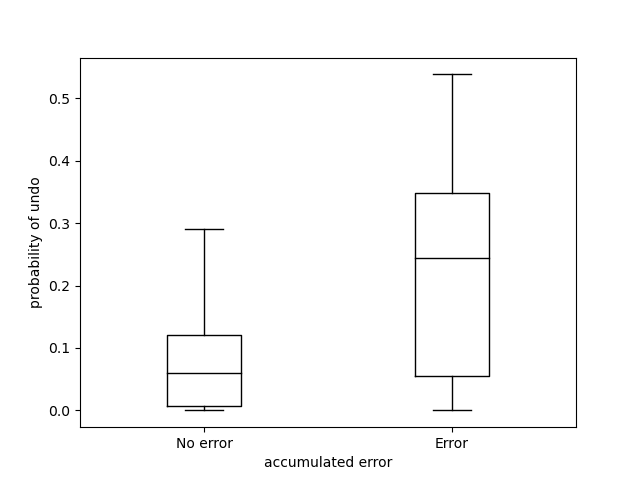

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

# axs.bar([1,2],
#         np.mean(dat_subjects,axis = 0),
#         color=[.7,.7,.7], 
#         edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [ np.array(undo_noerror_avg),#dat_subjects[:,0],
      np.array(undo_error_avg) #dat_subjects[:,1]
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    whis = 1.5,
    medianprops = dict(color = 'k'))  #

axs.set_xticks([1,2])
# axs.set_yticks(np.linspace(0,0.4,6))
axs.set_xticklabels(labels = ['No error', 'Error'])#,fontsize=18

axs.set_xlabel('accumulated error')
axs.set_ylabel('probability of undo')

# fig.set_figheight(4)
# fig.set_figwidth(2)
plt.show()
# fig.savefig(out_dir + 'conditional_undo_masError.pdf', dpi=600, bbox_inches='tight')

0.08388845294247214
0.16485758851140356


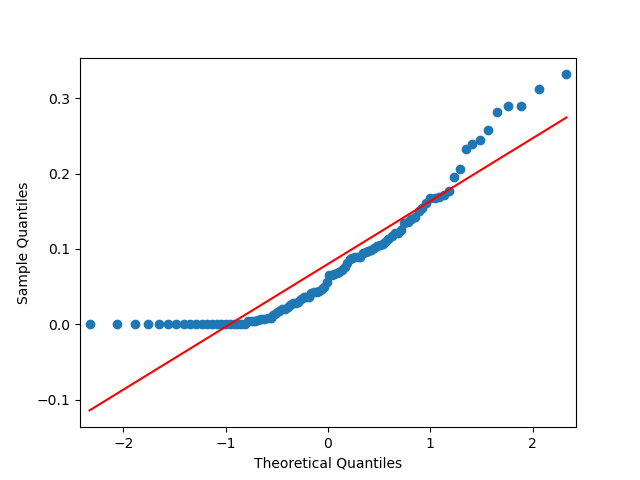

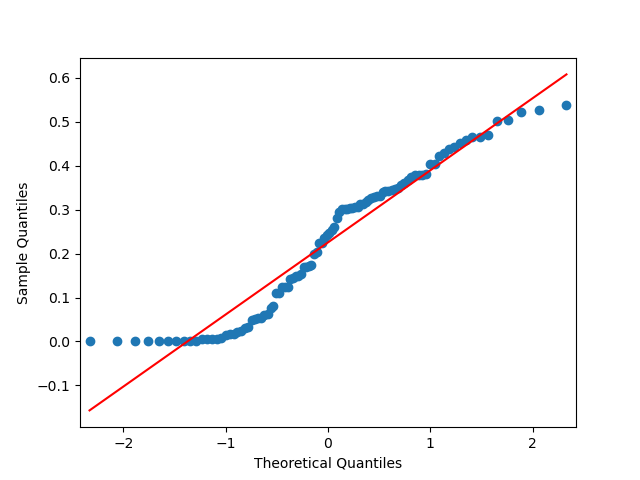

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(undo_noerror_avg, ddof=1))
print(np.std(undo_error_avg, ddof=1))
## check normality
sm.qqplot(undo_noerror_avg, line='s')
py.show()
sm.qqplot(undo_error_avg, line='s')
py.show()

In [ ]:
stat1, p1 = mannwhitneyu(undo_noerror_avg, undo_error_avg)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 8.7\\times 10^{-10}$')

##### GLM

In [ ]:
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo", "puzzleID", "allMAS"]]
undo_noerror["sum_error"] = list(puzzle_error[index_noerror])

undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo", "puzzleID", "allMAS"]]
undo_error["sum_error"] = list(puzzle_error[index_error])

undo_error_df = pd.concat([undo_noerror,undo_error])
undo_error_df = undo_error_df.reset_index(drop=True)
undo_error_df

subjects  undo  puzzleID  allMAS  sum_error
0             0     0        27      11          0
1             0     0        27      11          0
2             0     0        27      11          0
3             0     0        27      11          0
4             0     0        27      11          0
...         ...   ...       ...     ...        ...
57528        99     0        13      11          1
57529        99     0        13      11          1
57530        99     0        13      11          1
57531        99     0        11      12          1
57532        99     0        11      12          1

[57533 rows x 5 columns]

<IPython.core.display.Javascript object>


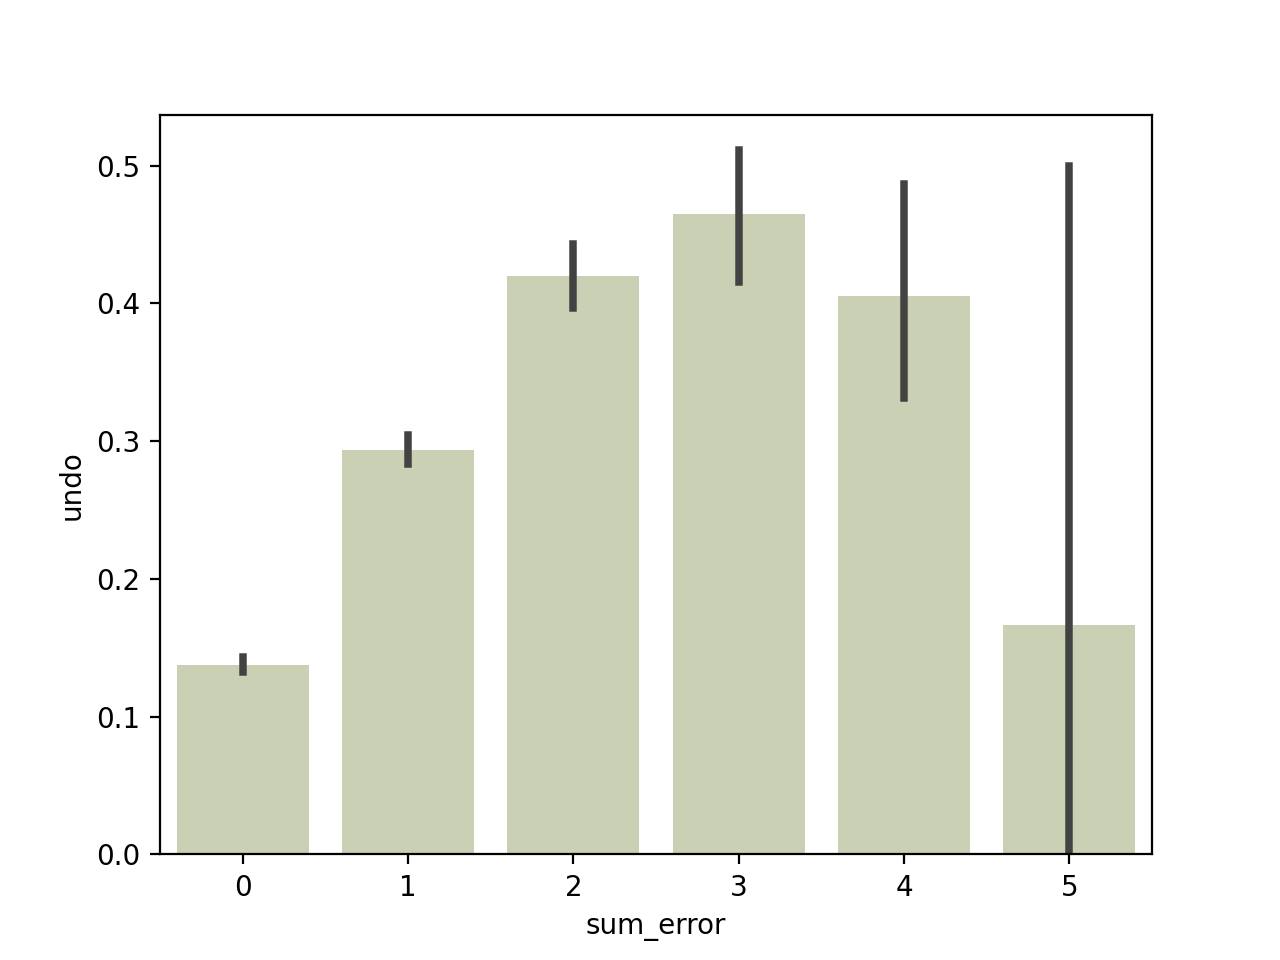

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='sum_error', y='undo', data = undo_error_df[undo_error_df.allMAS==9], color = '#ccd5ae') 

In [ ]:
%%R -i undo_error_df

undo_error_df$subjects <- as.factor(undo_error_df[,"subjects"])
undo_error_df$puzzleID <- as.factor(undo_error_df[,"puzzleID"])

model_error_undo = lme4::glmer(undo ~  1 + sum_error + (1 |subjects),
                                  data = undo_error_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_error_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo ~ 1 + sum_error + (1 | subjects)
   Data: undo_error_df

     AIC      BIC   logLik deviance df.resid 
 48103.3  48130.1 -24048.6  48097.3    57530 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8044 -0.5291 -0.3478 -0.0539 16.0353 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.51     1.873   
Number of obs: 57533, groups:  subjects, 100

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.11362    0.19085  -16.31   <2e-16 ***
sum_error    0.77874    0.01427   54.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
sum_error -0.076


#### § first undo

In [24]:
puzzle_error = sc_data_choice_level['allMAS'] - sc_data_choice_level['currMas']
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = puzzle_error.index[(puzzle_error == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo"]]
undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = puzzle_error.index[(puzzle_error != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo"]]
undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()


In [ ]:
print(len(undo_noerror_avg))
print(len(undo_error_avg))

100
100


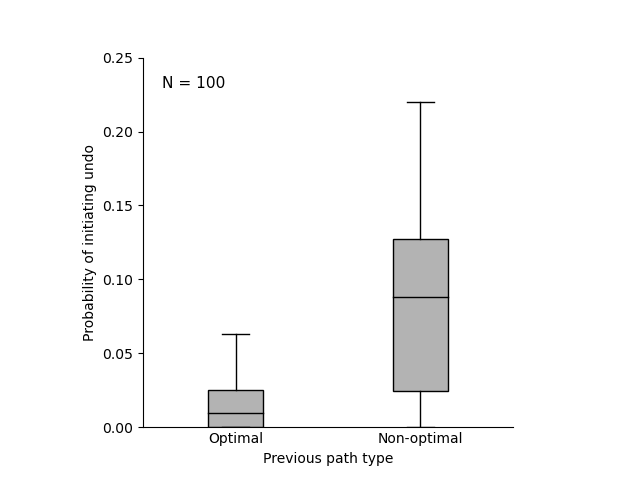

In [13]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

# axs.bar([1,2],
#         np.mean(dat_subjects,axis = 0),
#         color=[.7,.7,.7], 
#         edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [ np.array(undo_noerror_avg),#dat_subjects[:,0],
      np.array(undo_error_avg) #dat_subjects[:,1]
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    whis = 1.5,
    boxprops = dict(color = 'k'),
    medianprops = dict(color = 'k'), 
    patch_artist=True)  #

# fill with colors
for patch in bx['boxes']:
    patch.set_facecolor([.7,.7,.7])

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Optimal', 'Non-optimal'])#,fontsize=18
axs.set_xlabel('Previous path type')
# remove ticks on x axis
axs.tick_params(axis='x', which='both',length=0)

# set y ticks range
axs.set_ylim([0,0.25])
axs.set_yticks(np.linspace(0,0.25,6))
axs.set_ylabel('Probability of initiating undo')

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
      fontsize=11,  va='top')

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
# fig.savefig(out_dir + 'conditional_undo_masError.pdf', dpi=600, bbox_inches='tight')

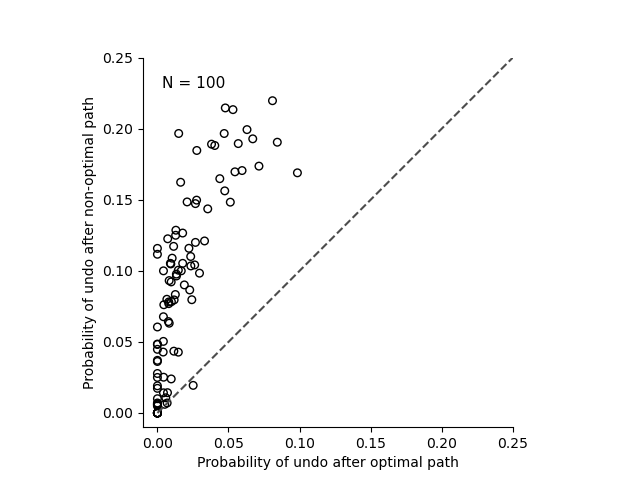

In [43]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(undo_noerror_avg), 
            np.array(undo_error_avg), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Probability of undo after optimal path')
axs.set_ylabel('Probability of undo after non-optimal path')

axs.set_ylim([-0.01,0.25])
axs.set_xlim([-0.01,0.25])

# add diagonal line
axs.plot([0,0.25], [0,0.25], ls="--", c=".3")

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
        fontsize=11,  va='top')

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

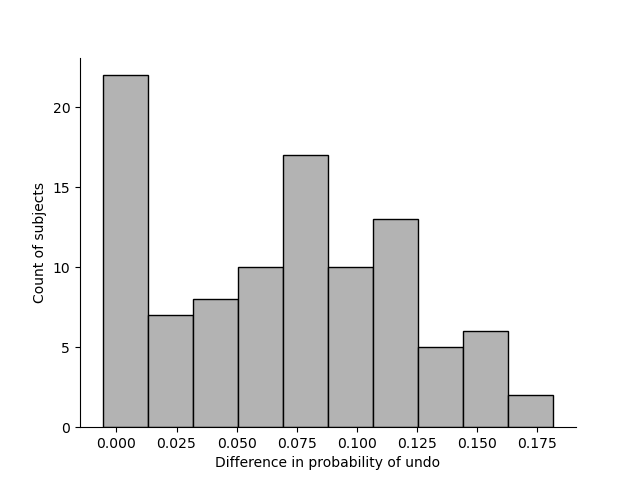

In [44]:
fig, axs = plt.subplots(1, 1)
diff = np.array(undo_error_avg) - np.array(undo_noerror_avg)

# plot histogram
axs.hist(diff, bins = 10, 
         color = [0.7,0.7,0.7], edgecolor = 'k')

axs.set_xlabel('Difference in probability of undo')
axs.set_ylabel('Count of subjects')
# make the figure transparent
fig.patch.set_alpha(0)
plt.show()

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

0.02175728540992308
0.0650974700558826


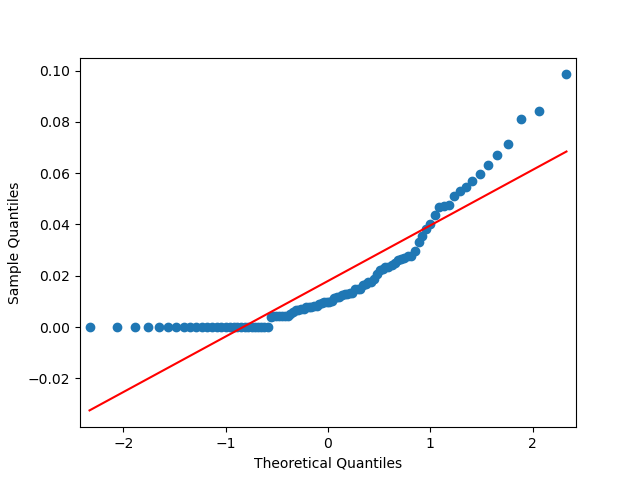

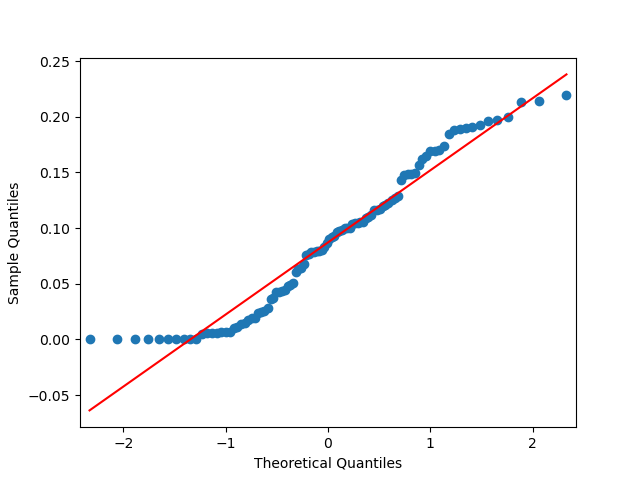

In [ ]:
# run 2-independent-sample t test
## check variance
print(np.std(undo_noerror_avg, ddof=1))
print(np.std(undo_error_avg, ddof=1))
## check normality
sm.qqplot(undo_noerror_avg, line='s')
py.show()
sm.qqplot(undo_error_avg, line='s')
py.show()

In [ ]:
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 1.1\\times 10^{-16}$')

#### Correlation with performance

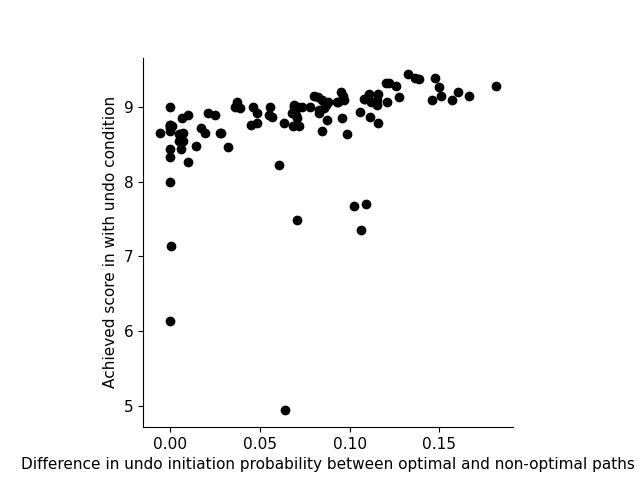

In [25]:
score = single_condition_data.groupby(['subjects'])['numCities'].mean()
efficiency = undo_error_avg - undo_noerror_avg

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter(efficiency, score, color = 'k')
axs.set_ylabel('Achieved score in with undo condition')
axs.set_xlabel('Difference in undo initiation probability between optimal and non-optimal paths')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

In [ ]:
# correlation between efficiency and score
spearmanr(score, efficiency)

SpearmanrResult(correlation=0.7049951630151167, pvalue=2.6841314899529293e-16)

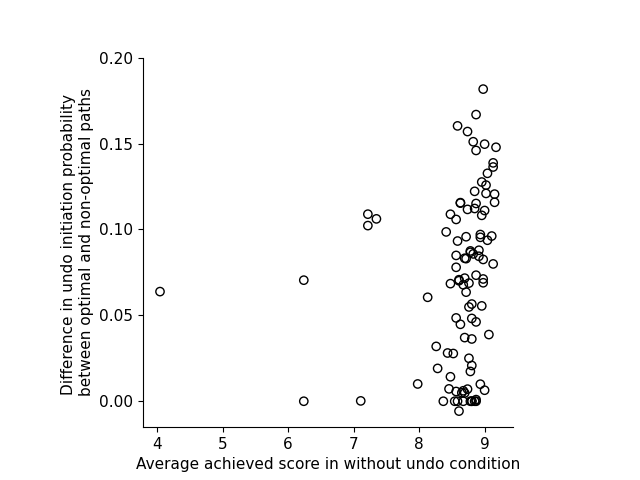

In [29]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['numCities'].mean()
efficiency = undo_error_avg - undo_noerror_avg

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, efficiency,               
             edgecolor="black",
                facecolor="None")
axs.set_yticks(np.linspace(0,0.2,5))
axs.set_xlabel('Average achieved score in without undo condition')
axs.set_ylabel('Difference in undo initiation probability \nbetween optimal and non-optimal paths')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

In [30]:
# correlation between efficiency and score
spearmanr(score, efficiency)

SpearmanrResult(correlation=0.38197846637549426, pvalue=8.798222501116256e-05)

#### Chart calculation

## Error of the last move

In [12]:
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]

instant_severity_error = df_beforeUndo['severityOfErrors']
groupby_error_instant = instant_severity_error.value_counts()
print(groupby_error_instant)

0    2329
1     269
2      43
3      16
4       2
6       1
Name: severityOfErrors, dtype: int64


<IPython.core.display.Javascript object>


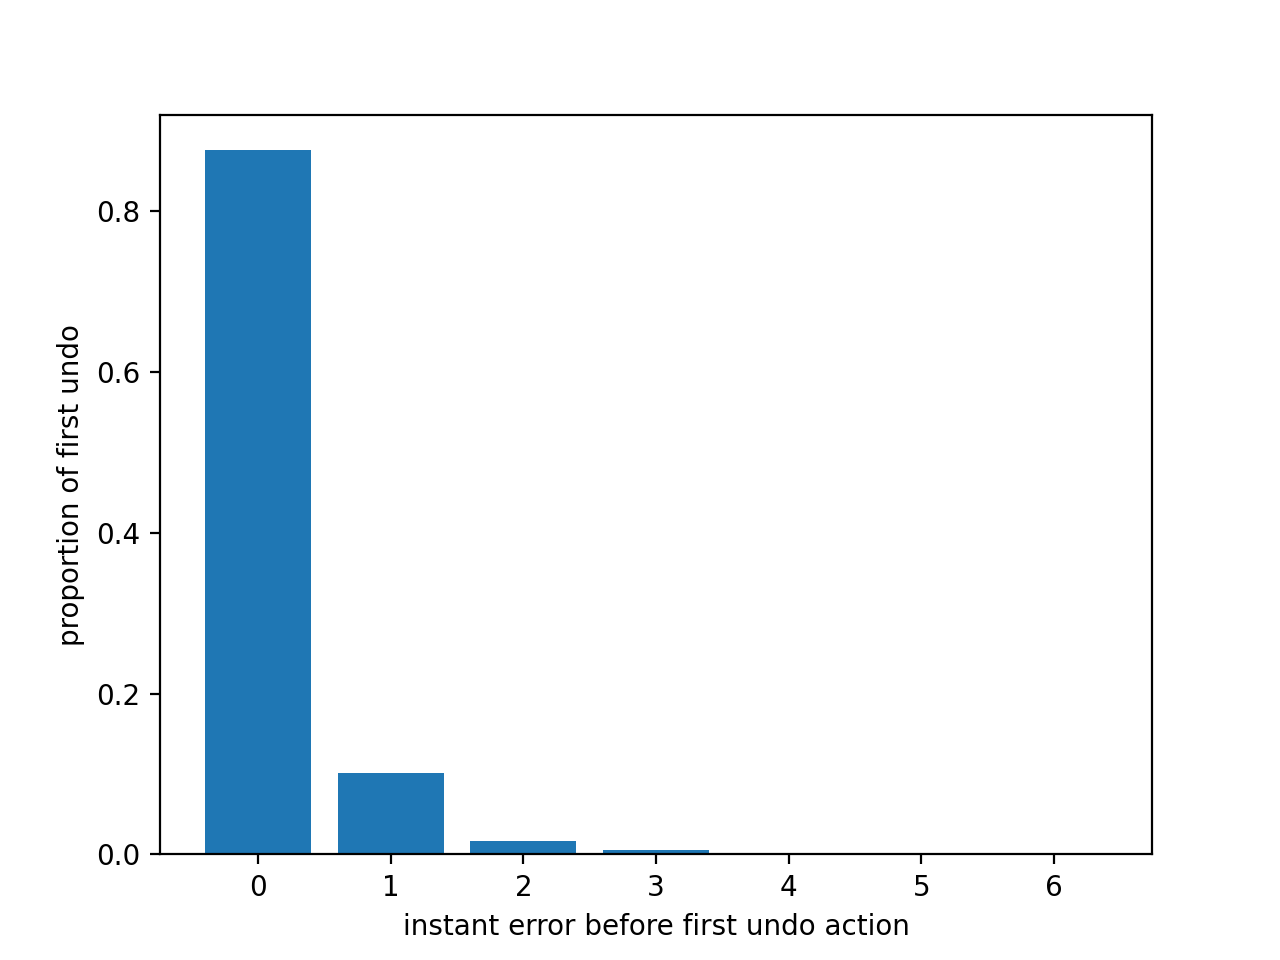

In [14]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar(groupby_error_instant.index,groupby_error_instant/sum(groupby_error_instant))
axs.set_ylabel('proportion of first undo')
axs.set_xlabel('instant error before first undo action')
plt.show()
# fig.savefig(out_dir + 'undo_instant_error.pdf', dpi=600, bbox_inches='tight')

#### [discarded]

In [178]:
# FROM EACH SUBJECT
dat_subjects = []
for i in np.unique(np.array(data_choice_level_df['subjects'])):
    
#     temp_data = []
    undo_list_no = []
    undo_list_yes = []
    
    for j in np.unique(sc_data_choice_level['puzzleID']):
        
#         temp_data_puz =[]
        dat_sbj_pzi =  data_choice_level_df[(data_choice_level_df.subjects == i)&(data_choice_level_df.puzzleID == j)].reset_index()

        # no error --------------------------------------------------
        index_error = dat_sbj_pzi['severityOfErrors'].index[(dat_sbj_pzi['severityOfErrors'] == 0)&(dat_sbj_pzi['submit'] != 1)]
        index_error = np.array(index_error)
        index_error += 1
        if np.any(index_error>(dat_sbj_pzi.shape[0]-1)):
            index_error = np.delete(index_error, np.where(index_error>(dat_sbj_pzi.shape[0]-1)))
        
#         undo_list_no = []
        for ind in index_error:    
            if (dat_sbj_pzi.firstUndo[ind] == 0)&(dat_sbj_pzi.lastUndo[ind] == 0)&(dat_sbj_pzi.currNumCities[ind-1] > 1):
                undo_list_no.append(0)
            elif (dat_sbj_pzi['firstUndo'][ind] == 1):
                undo_list_no.append(1)

#         temp_data_puz.append(np.mean(undo_list_no))
        
        # YES error --------------------------------------------------
        index_error = dat_sbj_pzi['severityOfErrors'].index[(dat_sbj_pzi['severityOfErrors'] != 0)&(dat_sbj_pzi['submit'] != 1)]
        index_error = np.array(index_error)
        index_error += 1
        if np.any(index_error>(dat_sbj_pzi.shape[0]-1)):
            index_error = np.delete(index_error, np.where(index_error>(dat_sbj_pzi.shape[0]-1)))
        
#         undo_list_yes = []
        for ind in index_error:    
            if (dat_sbj_pzi.firstUndo[ind] == 0)&(dat_sbj_pzi.lastUndo[ind] == 0)&(dat_sbj_pzi.currNumCities[ind-1] > 1):
                undo_list_yes.append(0)
            elif (dat_sbj_pzi['firstUndo'][ind] == 1):
                undo_list_yes.append(1)

#         temp_data_puz.append(np.mean(undo_list_yes))
    
#         temp_data.append(temp_data_puz)
    
#     dat_subjects.append(np.nanmean(temp_data,axis=0))
    dat_subjects.append([np.nanmean(undo_list_no),np.nanmean(undo_list_yes)])

dat_subjects = np.array(dat_subjects)

<IPython.core.display.Javascript object>


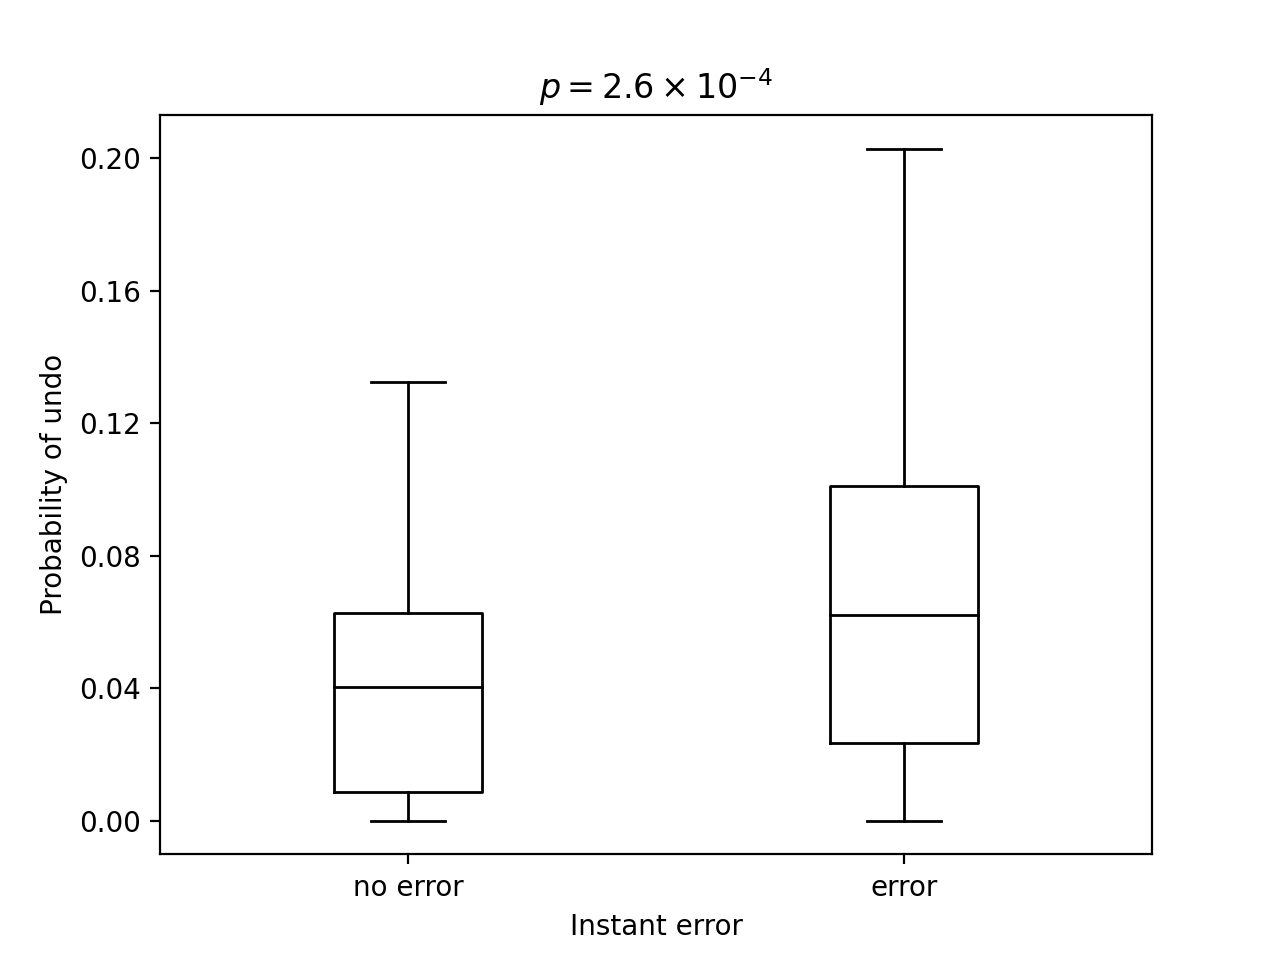

-3.7221081045480835
0.00025741785187125894


In [179]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
# axs.bar([1,2],
#         np.mean(dat_subjects,axis = 0),
#         color=[.7,.7,.7], 
#         edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [
        dat_subjects[:,0],
        dat_subjects[:,1]
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    whis = 1.5,
   medianprops = dict(color = 'k'))  #

axs.set_xticks([1,2])
axs.set_yticks(np.linspace(0,0.2,6))
axs.set_xticklabels(labels = ['no error', 'error'])#,fontsize=18

axs.set_xlabel('Instant error')
axs.set_ylabel('Probability of undo')



stat1, p1 = ttest_ind(dat_subjects[:,0], dat_subjects[:,1])
print(stat1)
print(p1)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

# fig.set_figheight(4)
# fig.set_figwidth(3)
plt.show()
fig.savefig(out_dir + 'undo_prob_instant_error.png', dpi=600, bbox_inches='tight')


<IPython.core.display.Javascript object>


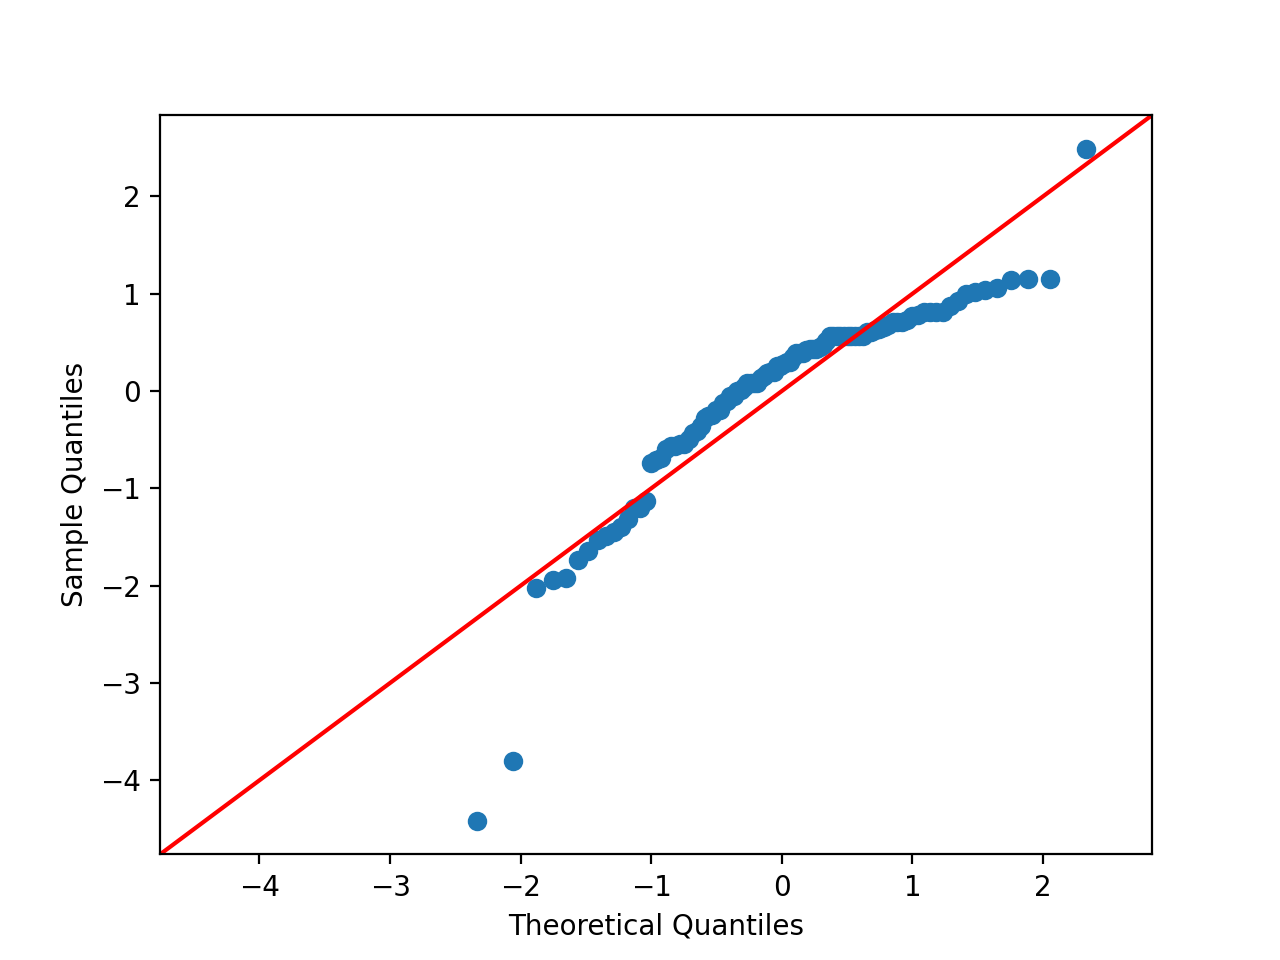

In [80]:
# The paired t–test assumes that the differences between pairs are normally distributed
# ref: http://www.biostathandbook.com/pairedttest.html

sm.qqplot(stats.zscore(dat_subjects[:,0]-dat_subjects[:,1]), line ='45')
py.show()

#### all undo

In [330]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=1)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo"]]
undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=1)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo"]]
undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()

<IPython.core.display.Javascript object>


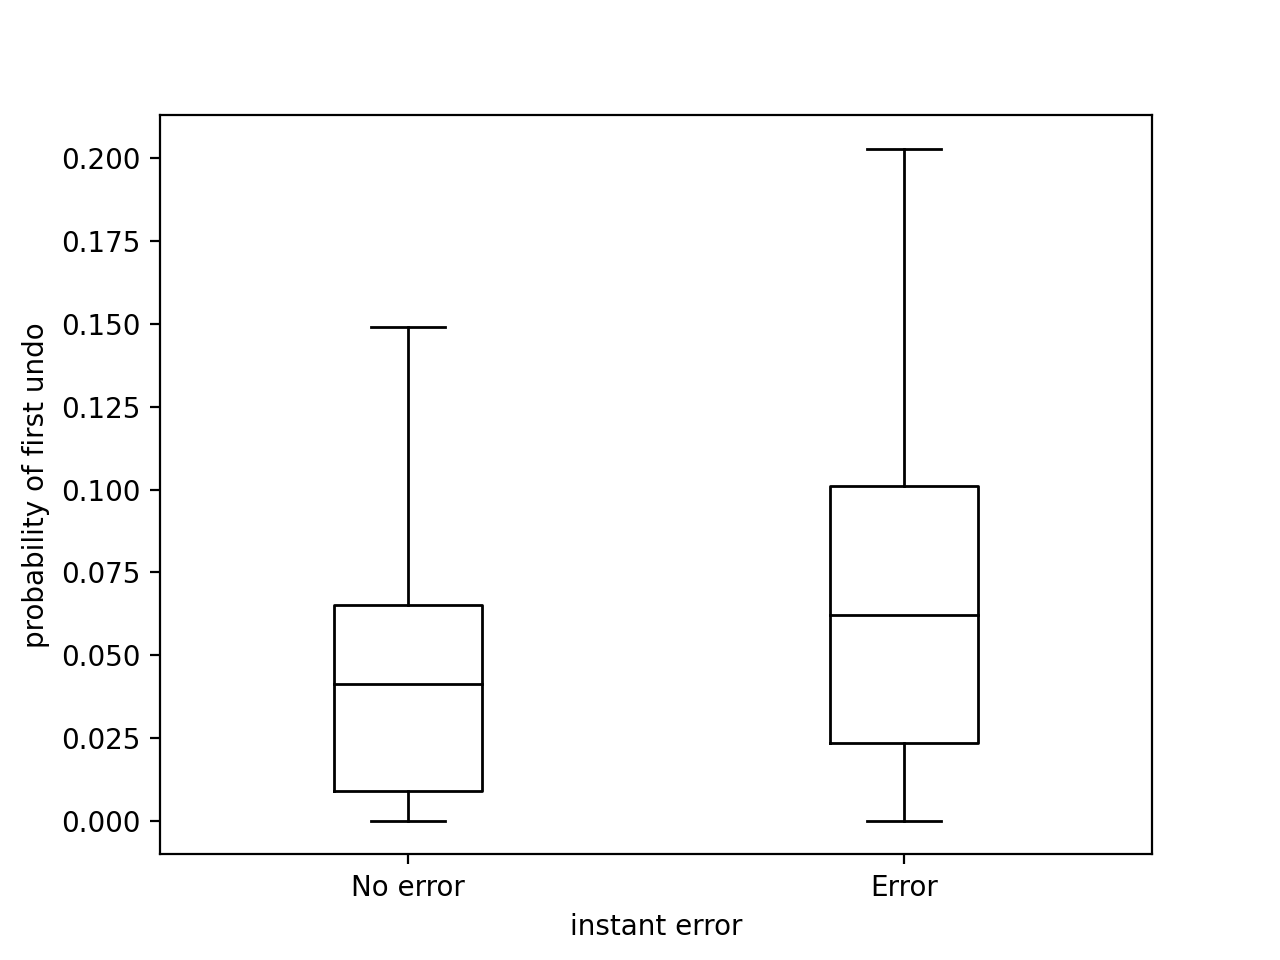

In [82]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

# axs.bar([1,2],
#         np.mean(dat_subjects,axis = 0),
#         color=[.7,.7,.7], 
#         edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [ np.array(undo_noerror_avg),#dat_subjects[:,0],
      np.array(undo_error_avg) #dat_subjects[:,1]
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    whis = 1.5,
    medianprops = dict(color = 'k'))  #

axs.set_xticks([1,2])
# axs.set_yticks(np.linspace(0,0.4,6))
axs.set_xticklabels(labels = ['No error', 'Error'])#,fontsize=18

axs.set_xlabel('instant error')
axs.set_ylabel('probability of undo')

# fig.set_figheight(4)
# fig.set_figwidth(2)
plt.show()
# fig.savefig(out_dir + 'conditional_undo_masError.pdf', dpi=600, bbox_inches='tight')

In [332]:
stat1, p1 = mannwhitneyu(undo_noerror_avg, undo_error_avg)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 2.8\\times 10^{-6}$')

##### GLM

In [336]:
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo", "puzzleID"]]
undo_noerror["severityOfErrors"] = list(sc_data_choice_level.loc[index_noerror,"severityOfErrors"])

undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo", "puzzleID"]]
undo_error["severityOfErrors"] = list(sc_data_choice_level.loc[index_error,"severityOfErrors"])

undo_error_df = pd.concat([undo_noerror,undo_error])
undo_error_df = undo_error_df.reset_index(drop=True)


In [337]:
%%R -i undo_error_df

undo_error_df$subjects <- as.factor(undo_error_df[,"subjects"])
undo_error_df$puzzleID <- as.factor(undo_error_df[,"puzzleID"])

model_error_undo = lme4::glmer(undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_error_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error_df

     AIC      BIC   logLik deviance df.resid 
 50894.1  50921.0 -25444.0  50888.1    57530 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.882 -0.564 -0.401 -0.059 64.825 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.023    1.739   
Number of obs: 57533, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.40451    0.17361  -13.85   <2e-16 ***
severityOfErrors -0.82713    0.04947  -16.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.013


#### § first undo

In [45]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo"]]
undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo"]]
undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()

In [18]:
print(len(undo_noerror_avg))
print(len(undo_error_avg))

100
100


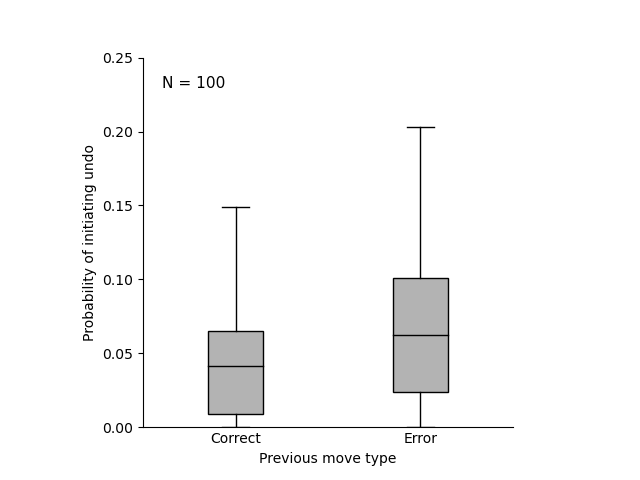

In [46]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

# axs.bar([1,2],
#         np.mean(dat_subjects,axis = 0),
#         color=[.7,.7,.7], 
#         edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx = axs.boxplot(
    [ np.array(undo_noerror_avg),#dat_subjects[:,0],
      np.array(undo_error_avg) #dat_subjects[:,1]
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    whis = 1.5,
    medianprops = dict(color = 'k'),
    patch_artist=True)  #

# fill with colors
for patch in bx['boxes']:
    patch.set_facecolor([.7,.7,.7])
    
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['Correct', 'Error'])#,fontsize=18
axs.set_xlabel('Previous move type')
axs.tick_params(axis='x', which='both',length=0)

axs.set_yticks(np.linspace(0,0.25,6))
axs.set_ylim([0,0.25])
axs.set_ylabel('Probability of initiating undo')

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
      fontsize=11,  va='top')

axs.set_aspect(1/axs.get_data_ratio())

# fig.set_figheight(4)
# fig.set_figwidth(2)
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
# fig.savefig(out_dir + 'conditional_undo_masError.pdf', dpi=600, bbox_inches='tight')

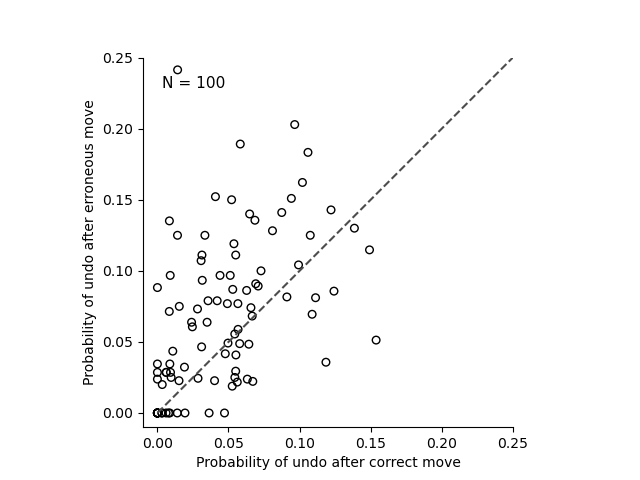

In [49]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(undo_noerror_avg), 
            np.array(undo_error_avg), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Probability of undo after correct move')
axs.set_ylabel('Probability of undo after erroneous move')

axs.set_ylim([-0.01,0.25])
axs.set_xlim([-0.01,0.25])

# add diagonal line
axs.plot([0,0.25], [0,0.25], ls="--", c=".3")

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
        fontsize=11,  va='top')

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

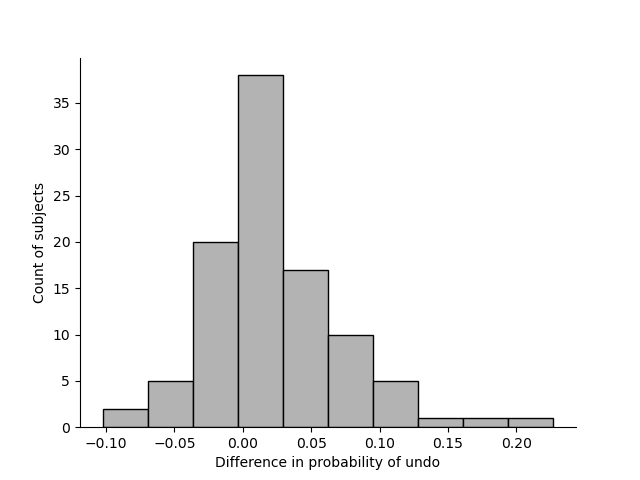

In [50]:
fig, axs = plt.subplots(1, 1)
diff = np.array(undo_error_avg) - np.array(undo_noerror_avg)

# plot histogram
axs.hist(diff, bins = 10, 
         color = [0.7,0.7,0.7], edgecolor = 'k')

axs.set_xlabel('Difference in probability of undo')
axs.set_ylabel('Count of subjects')
# make the figure transparent
fig.patch.set_alpha(0)
plt.show()

fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

0.038925416137539186
0.05806890338994977


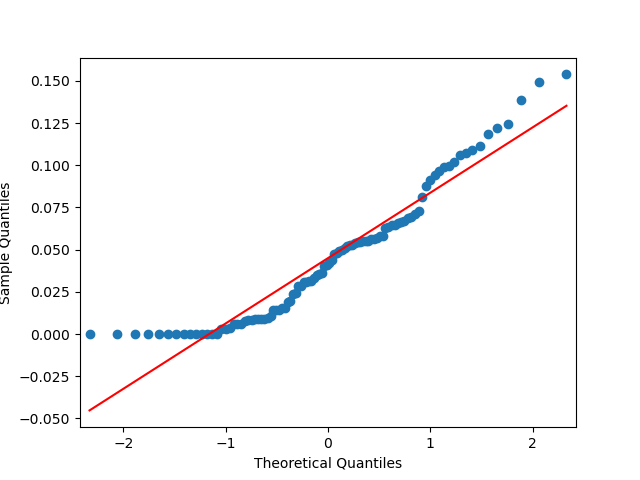

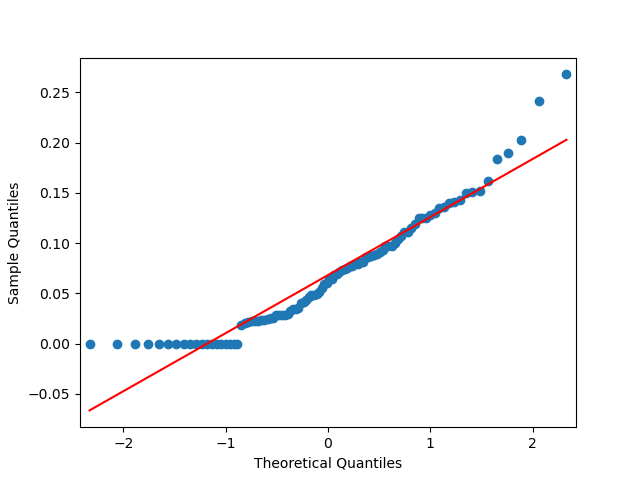

In [329]:
# run 2-independent-sample t test
## check variance
print(np.std(undo_noerror_avg, ddof=1))
print(np.std(undo_error_avg, ddof=1))
## check normality
sm.qqplot(undo_noerror_avg, line='s')
py.show()
sm.qqplot(undo_error_avg, line='s')
py.show()

In [330]:
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 1.1\\times 10^{-5}$')

##### GLM

In [341]:
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo", "puzzleID"]]
undo_noerror["severityOfErrors"] = list(sc_data_choice_level.loc[index_noerror,"severityOfErrors"])

undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo", "puzzleID"]]
undo_error["severityOfErrors"] = list(sc_data_choice_level.loc[index_error,"severityOfErrors"])

undo_error_df = pd.concat([undo_noerror,undo_error])
undo_error_df = undo_error_df.reset_index(drop=True)


In [342]:
%%R -i undo_error_df

undo_error_df$subjects <- as.factor(undo_error_df[,"subjects"])
undo_error_df$puzzleID <- as.factor(undo_error_df[,"puzzleID"])

model_error_undo = lme4::glmer(undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_error_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error_df

     AIC      BIC   logLik deviance df.resid 
 19246.9  19273.2  -9620.4  19240.9    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6700 -0.2819 -0.2280 -0.1184 13.0269 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.414    1.189   
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.51328    0.12649  -27.78  < 2e-16 ***
severityOfErrors  0.26734    0.04369    6.12 9.38e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.059


#### Correlation with performance

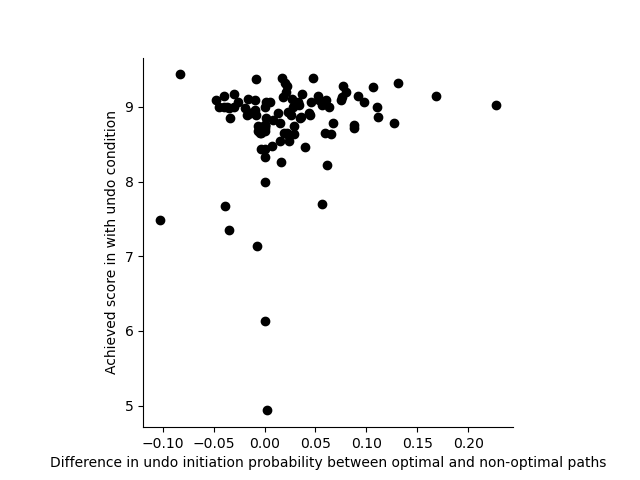

In [51]:
score = single_condition_data.groupby(['subjects'])['numCities'].mean()
efficiency = undo_error_avg - undo_noerror_avg

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter(efficiency, score, color = 'k')
axs.set_ylabel('Achieved score in with undo condition')
axs.set_xlabel('Difference in undo initiation probability between optimal and non-optimal paths')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

In [52]:
# correlation between efficiency and score
spearmanr(score, efficiency)

SpearmanrResult(correlation=0.17803684917336524, pvalue=0.07636601817987271)

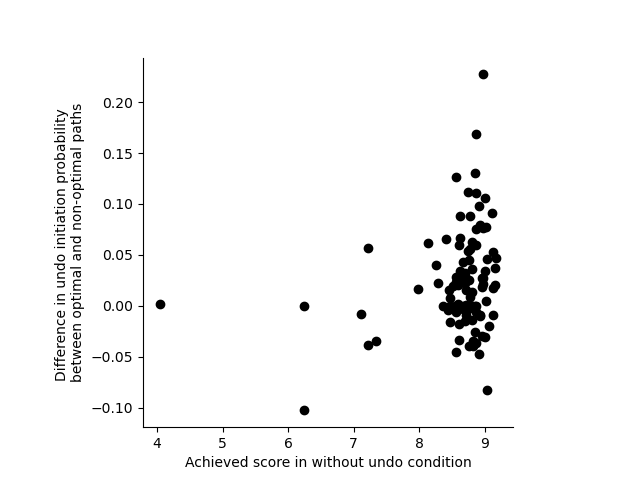

In [53]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['numCities'].mean()
efficiency = undo_error_avg - undo_noerror_avg

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, efficiency, color = 'k')
axs.set_xlabel('Achieved score in without undo condition')
axs.set_ylabel('Difference in undo initiation probability \nbetween optimal and non-optimal paths')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

In [54]:
# correlation between efficiency and score
spearmanr(score, efficiency)

SpearmanrResult(correlation=0.1610644729340864, pvalue=0.10940668705476193)

## Optimality

### all trials

#### plot

In [401]:
data_subset = data_choice_level[(data_choice_level['condition']==1)&(data_choice_level['currNumCities']!=1)]
data_subset = data_subset.drop(columns=['branching', 'branchingFirst'])

optimal = (data_subset.allMAS == data_subset.currMas) &(data_subset.submit != 1)
index_undo = data_subset.loc[optimal,:].index + 1
invalid = set(index_undo) - set(data_subset.index)
index_undo_valid = [x for x in index_undo if x not in invalid]
df_undo_optimal = data_subset.loc[index_undo_valid, ['firstUndo','subjects','puzzleID']]
undo_sub_optimal = df_undo_optimal.groupby(['subjects'])['firstUndo'].mean()

nonoptimal = (data_subset.allMAS != data_subset.currMas) &(data_subset.submit != 1)
index_undo = data_subset.loc[nonoptimal,:].index + 1
invalid = set(index_undo) - set(data_subset.index)
index_undo_valid = [x for x in index_undo if x not in invalid]
df_undo_nonoptimal = data_subset.loc[index_undo_valid, ['firstUndo','subjects','puzzleID']]
undo_sub_nonoptimal = df_undo_nonoptimal.groupby(['subjects'])['firstUndo'].mean()

<IPython.core.display.Javascript object>


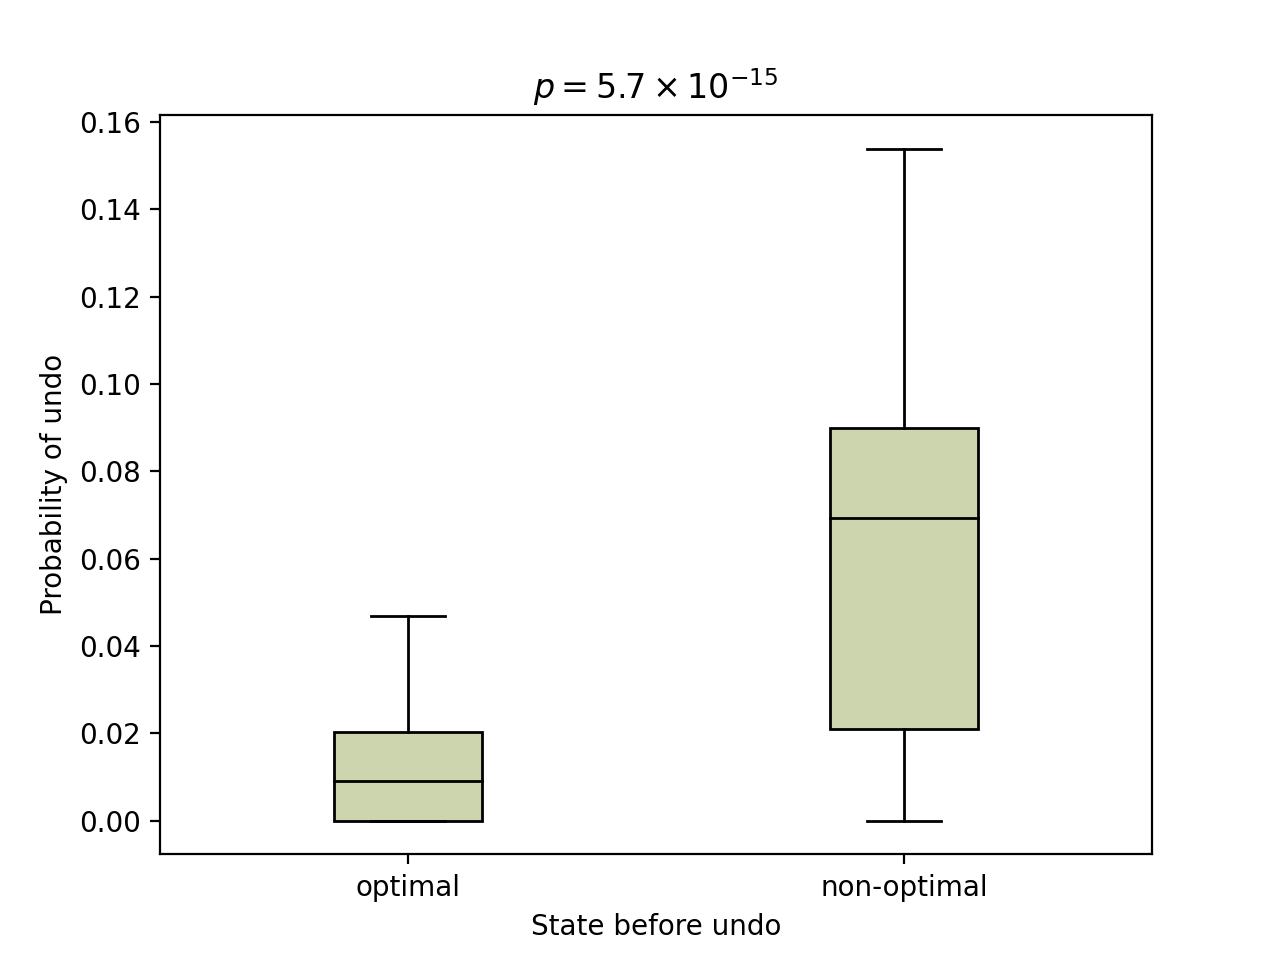

In [402]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot(
    [np.array(undo_sub_optimal), np.array(undo_sub_nonoptimal)],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    patch_artist=True,
    whis = 1.5,
    medianprops = dict(color = 'k'))  #

colors = ['#ccd5ae','#ccd5ae']
for patch, color in zip(bx['boxes'], colors):
    patch.set_facecolor(color)

axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['optimal',
                              'non-optimal'])#,fontsize=18

axs.set_ylabel('Probability of undo')
axs.set_xlabel('State before undo')

# fig.set_figheight(4)
# fig.set_figwidth(3)
plt.show()
# fig.savefig(out_dir + 'undo_prob_end_state.png', dpi=600, bbox_inches='tight')

0.01679661578152935
0.043341708464030494


<IPython.core.display.Javascript object>


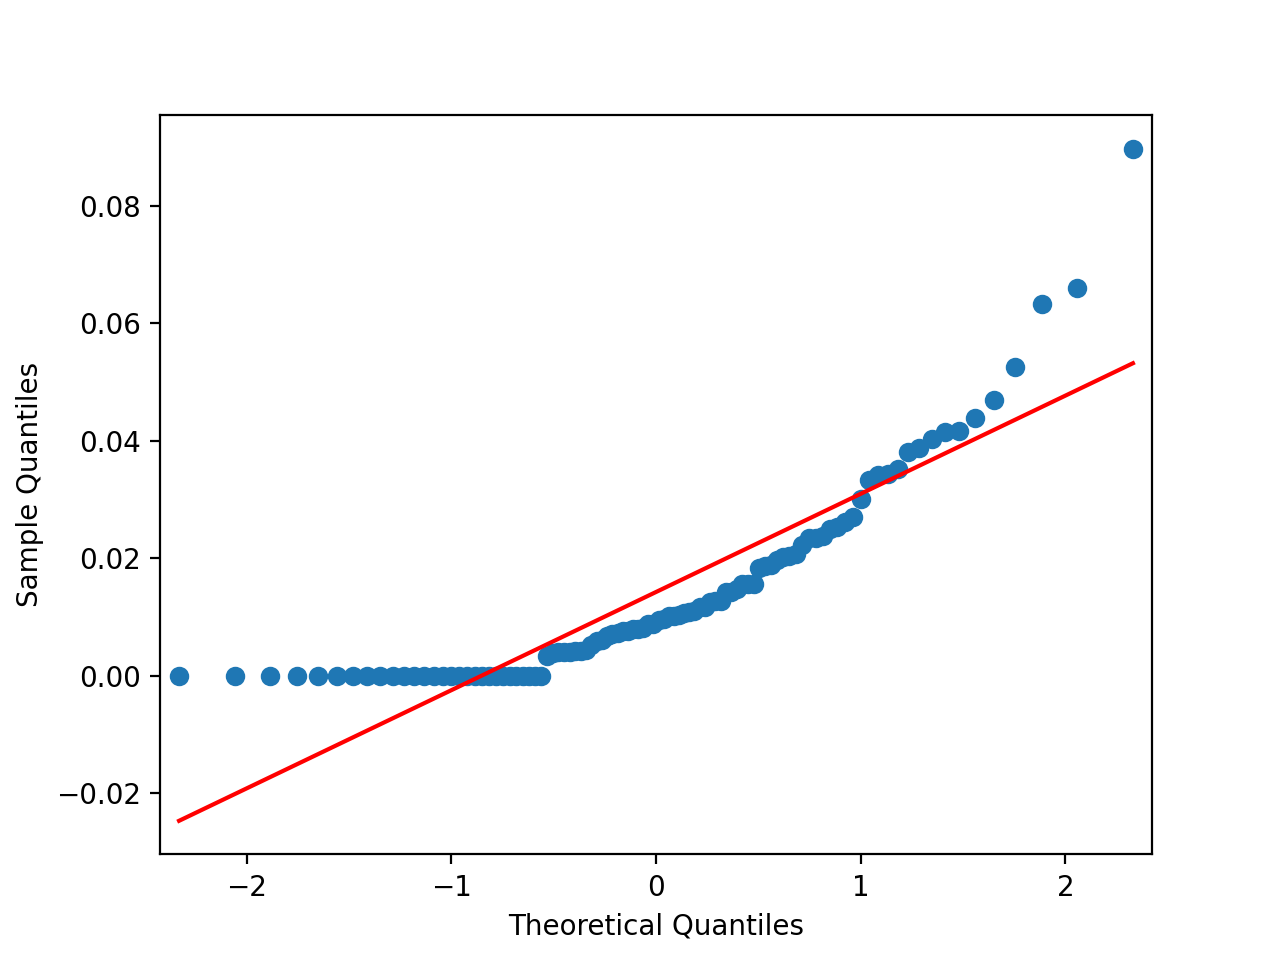

<IPython.core.display.Javascript object>


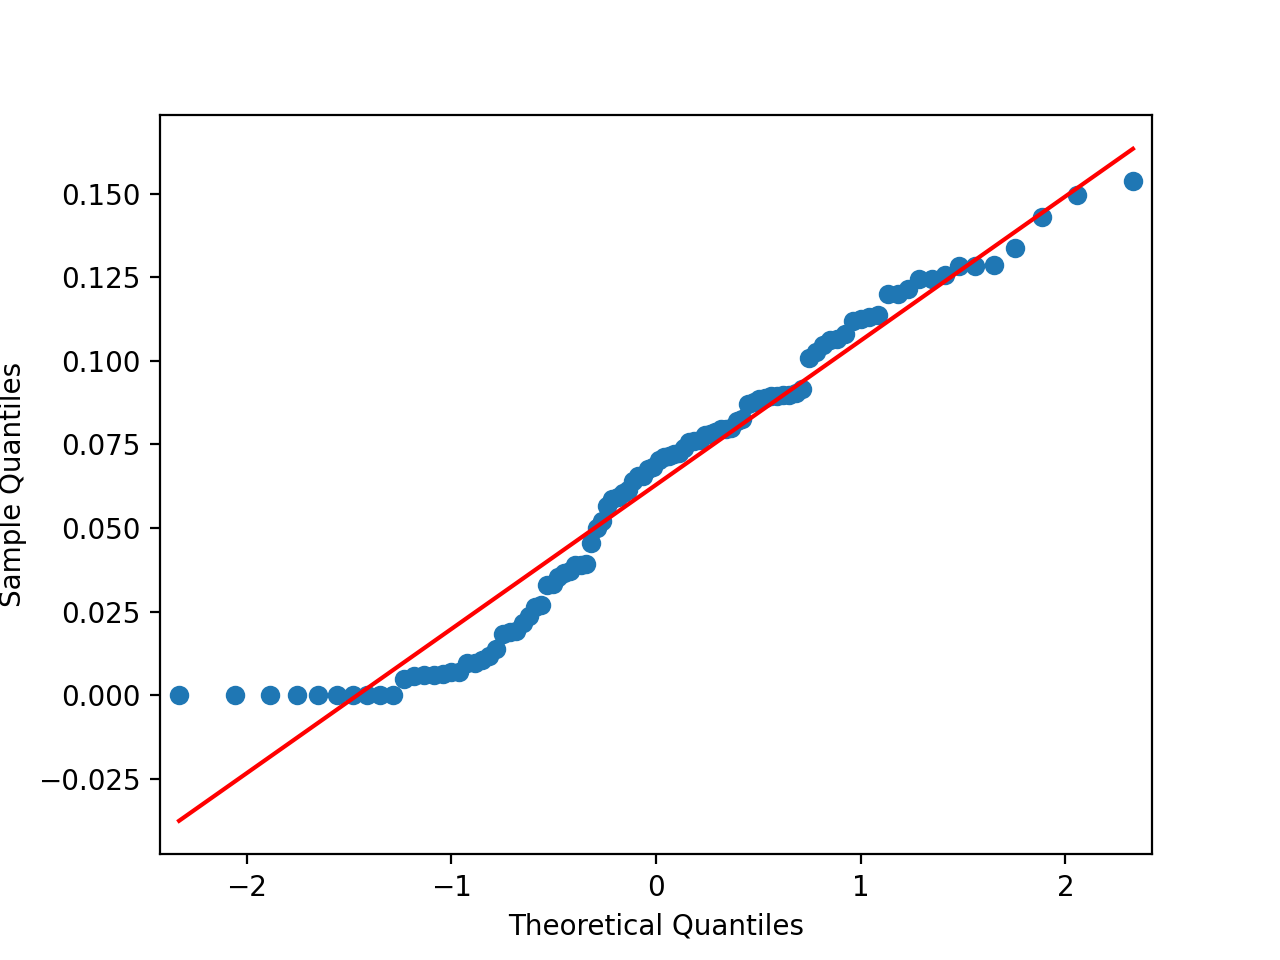

1815.0
5.719703629466232e-15


Text(0.5, 1.0, '$p = 5.7\\times 10^{-15}$')

In [404]:
# check equal variance ----
print(np.std(undo_sub_optimal, ddof=1))
print(np.std(undo_sub_nonoptimal, ddof=1))
## violated

# check normality ----
sm.qqplot(undo_sub_optimal, line='s')
py.show()
sm.qqplot(undo_sub_nonoptimal, line='s')
py.show()
## violated

stat1, p1 = mannwhitneyu(np.array(undo_sub_optimal), np.array(undo_sub_nonoptimal))
print(stat1)
print(p1)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

#### glm

In [410]:
df_undo_optimal["type"] = "optimal"
df_undo_nonoptimal["type"] = "non-optimal"
undo_optimal_df = pd.concat([df_undo_optimal, df_undo_nonoptimal])

In [411]:
%%R -i undo_optimal_df

undo_optimal_df$subject <- factor(undo_optimal_df$subject)

model_undo_optimal = lme4::glmer(firstUndo ~  1 + type + (1 |subjects),
                                  data = undo_optimal_df, family = "binomial")

# get the coefficients for the best fitting model
summary(model_undo_optimal)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + type + (1 | subjects)
   Data: undo_optimal_df

     AIC      BIC   logLik deviance df.resid 
 18936.7  18963.6  -9465.4  18930.7    56319 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.4460 -0.2600 -0.1683 -0.1149 17.3688 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.108    1.053   
Number of obs: 56322, groups:  subjects, 100

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.08831    0.11433  -27.01   <2e-16 ***
typeoptimal -1.48522    0.04858  -30.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
typeoptimal -0.096


### separate end/non-end

#### plot

In [412]:
data_subset = data_choice_level[(data_choice_level['condition']==1)&(data_choice_level['currNumCities']!=1)]
data_subset = data_subset.drop(columns=['branching', 'branchingFirst'])

optimal_end = (data_subset.checkEnd == 1)&(data_subset.allMAS == data_subset.currMas) &(data_subset.submit != 1)
index_undo = data_subset.loc[optimal_end,:].index + 1
invalid = set(index_undo) - set(data_subset.index)
index_undo_valid = [x for x in index_undo if x not in invalid]
df_optimal_end = data_subset.loc[index_undo_valid, ['firstUndo','subjects','puzzleID']]
df_optimal_end_sub = df_optimal_end.groupby(['subjects'])['firstUndo'].mean()

optimal_nonend = (data_subset.checkEnd != 1)&(data_subset.allMAS == data_subset.currMas) &(data_subset.submit != 1)
index_undo = data_subset.loc[optimal_nonend,:].index + 1
invalid = set(index_undo) - set(data_subset.index)
index_undo_valid = [x for x in index_undo if x not in invalid]
df_optimal_nonend = data_subset.loc[index_undo_valid, ['firstUndo','subjects','puzzleID']]
df_optimal_nonend_sub = df_optimal_nonend.groupby(['subjects'])['firstUndo'].mean()

nonoptimal_end = (data_subset.checkEnd == 1)&(data_subset.allMAS != data_subset.currMas) &(data_subset.submit != 1)
index_undo = data_subset.loc[nonoptimal_end,:].index + 1
invalid = set(index_undo) - set(data_subset.index)
index_undo_valid = [x for x in index_undo if x not in invalid]
df_nonoptimal_end = data_subset.loc[index_undo_valid, ['firstUndo','subjects','puzzleID']]
df_nonoptimal_end_sub = df_nonoptimal_end.groupby(['subjects'])['firstUndo'].mean()

nonoptimal_nonend = (data_subset.checkEnd != 1)&(data_subset.allMAS != data_subset.currMas) &(data_subset.submit != 1)
index_undo = data_subset.loc[nonoptimal_nonend,:].index + 1
invalid = set(index_undo) - set(data_subset.index)
index_undo_valid = [x for x in index_undo if x not in invalid]
df_nonoptimal_nonend = data_subset.loc[index_undo_valid, ['firstUndo','subjects','puzzleID']]
df_nonoptimal_nonend_sub = df_nonoptimal_nonend.groupby(['subjects'])['firstUndo'].mean()

<IPython.core.display.Javascript object>


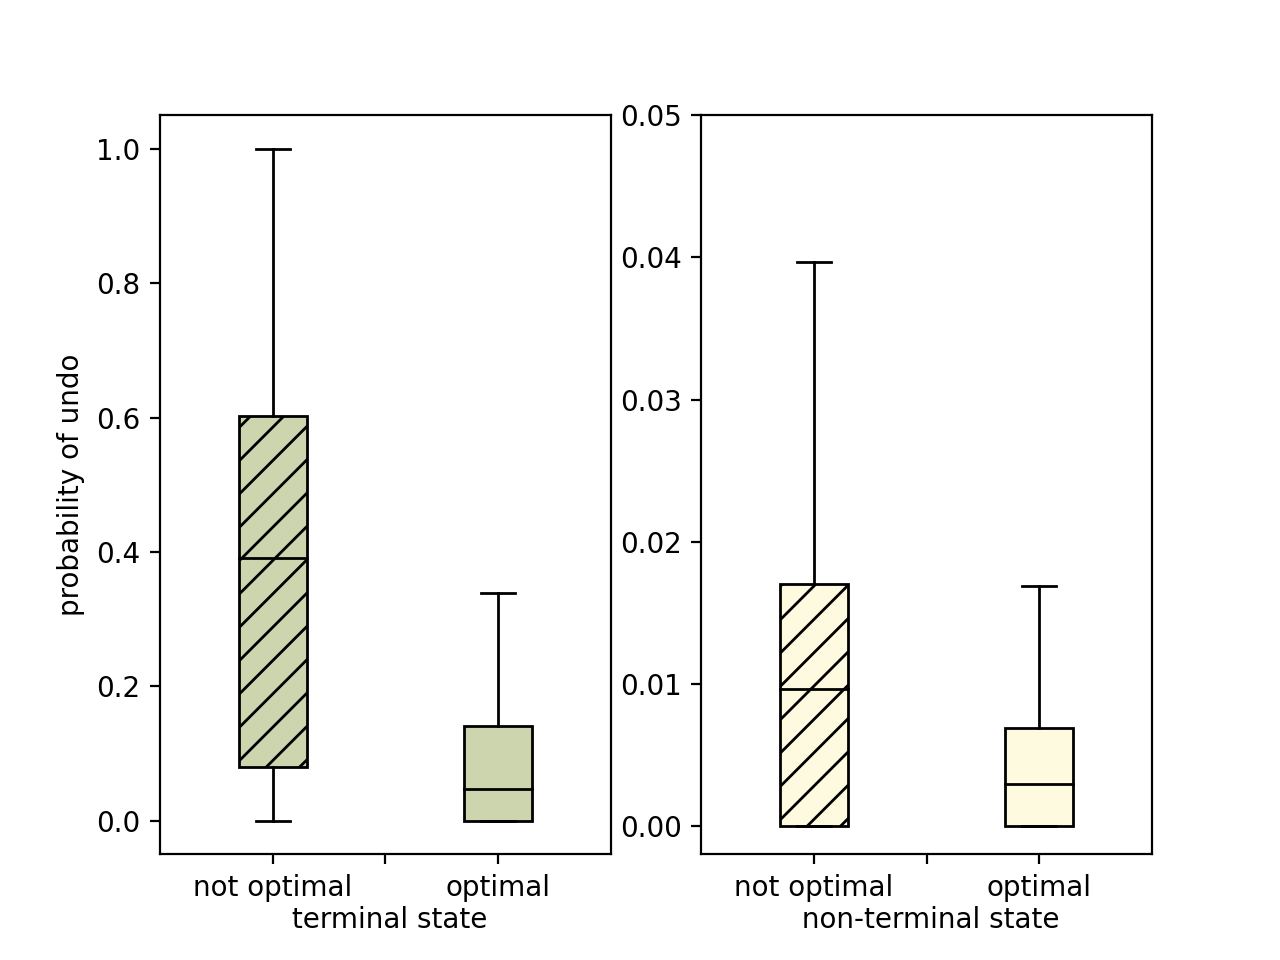

In [417]:
%matplotlib notebook

fig, axs = plt.subplots(1, 2)
# axs.bar([1,2,3,4],np.nanmean(dat_subjects,axis = 0),
#         color=['#ccd5ae','#ccd5ae','#fefae0','#fefae0'],
#         hatch=['//','','//',''],edgecolor = 'k', 
#         yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))

bx1 = axs[0].boxplot(
    [
        df_nonoptimal_end_sub,
        df_optimal_end_sub
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    patch_artist=True,
    whis = 1.5,
   medianprops = dict(color = 'k'))  #

bx2 = axs[1].boxplot(
    [
        df_nonoptimal_nonend_sub,
        df_optimal_nonend_sub
    ],
    positions =[1,2],
    widths = 0.3,
    showfliers=False,
    patch_artist=True,
    whis = 1.5,
   medianprops = dict(color = 'k'))  #

colors_1 = ['#ccd5ae','#ccd5ae']
colors_2 = ['#fefae0','#fefae0']
for patch, color in zip(bx1['boxes'], colors_1):
    patch.set_facecolor(color)
for patch, color in zip(bx2['boxes'], colors_2):
    patch.set_facecolor(color)
    
hatches = ['//', '']
for bx in [bx1,bx2]:
    for i in range(len(bx['boxes'])):
        bx['boxes'][i].set(hatch = hatches[i])

axs[0].set_xticks([1,1.5,2])
axs[1].set_xticks([1,1.5,2])
axs[1].set_yticks(np.linspace(0,0.05,6))
axs[0].set_xticklabels(labels = ['not optimal',
                              '\n terminal state',
                              'optimal'])
axs[1].set_xticklabels(labels = ['not optimal',
                              '\n non-terminal state',
                              'optimal'])#,fontsize=18

axs[0].set_ylabel('probability of undo')
# fig.set_figheight(4)
# fig.set_figwidth(3)

plt.show()
# fig.savefig(out_dir + 'undo_prob_end_optimal_state.png', dpi=600, bbox_inches='tight')
# [TODO] distribution of state/optimality itself

#### glm

In [418]:
df_optimal_end["end_type"] = "terminal"
df_optimal_end["opti_type"] = "optimal"

df_optimal_nonend["end_type"] = "non-terminal"
df_optimal_nonend["opti_type"] = "optimal"

df_nonoptimal_end["end_type"] = "terminal"
df_nonoptimal_end["opti_type"] = "non-optimal"

df_nonoptimal_nonend["end_type"] = "non-terminal"
df_nonoptimal_nonend["opti_type"] = "non-optimal"
undo_optimal_end = pd.concat([df_optimal_end, df_optimal_nonend, df_nonoptimal_end, df_nonoptimal_nonend])

In [421]:
%%R -i undo_optimal_end

undo_optimal_end$subject <- factor(undo_optimal_end$subject)

model_undo_optimal_end = lme4::glmer(firstUndo ~  1 + end_type + opti_type + (1 |subjects),
                                  data = undo_optimal_end, family = "binomial")

# get the coefficients for the best fitting model
summary(model_undo_optimal_end)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + end_type + opti_type + (1 | subjects)
   Data: undo_optimal_end

     AIC      BIC   logLik deviance df.resid 
 11040.9  11076.6  -5516.4  11032.9    56318 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.421 -0.113 -0.067 -0.036 70.858 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 2.472    1.572   
Number of obs: 56322, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.23779    0.17238  -30.39   <2e-16 ***
end_typeterminal  4.45231    0.06181   72.04   <2e-16 ***
opti_typeoptimal -1.69124    0.05970  -28.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) end_ty
end_typtrmn -0.277       
opt_typptml -0.015 -0.209


## the puzzle is difficult; the puzzle has multiple similar solutions

### number of optimal solutions

In [428]:
# bins1 = stats.binned_statistic(n_optimal, error_basic, 'mean', bins=[1,3,6,9,200])
# bins2 = stats.binned_statistic(n_optimal, error_undo, 'mean', bins=[1,3,6,9,15])

bins0 = (single_condition_data.groupby(['subjects', pd.cut(single_condition_data.nos,[1,4,8,12,17,34,76,180])])['numFullUndo'].mean()).reset_index()


<IPython.core.display.Javascript object>


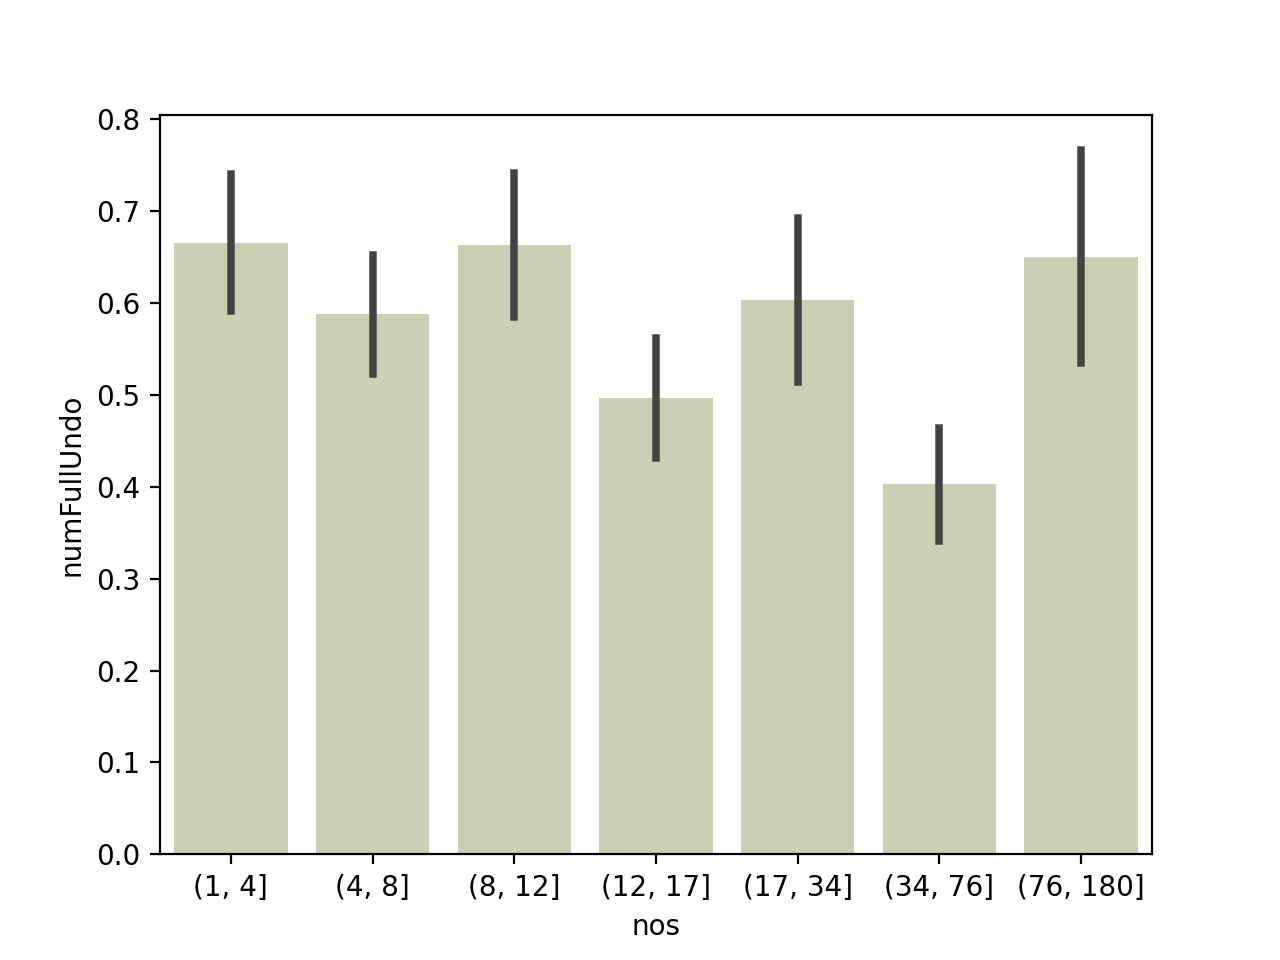

In [429]:
fig, axs = plt.subplots()         

# axs.plot(bins1[1][:-1], bins1[0], color = '#81b29a', linewidth=3,label='basic')

# sub_n = len(np.unique(puzzleID_order_data.subjects))
# x = range(len(bins00))
# y1 = bins00.mean()
# c1 = bins00.std()/np.sqrt(sub_n)

# axs.plot(x,y1 , color = '#81b29a', linewidth=3, label = 'Self')
# axs.fill_between(x, (y1-c1), (y1+c1), color='#81b29a', alpha=.1)

axs = sns.barplot(x='nos', y='numFullUndo', data = bins0, errorbar = "se", color = '#ccd5ae') 
# axs.set_xlabel('number of optimal solutions')
# axs.set_ylabel('count of error')
# axs.set_xticks([1,3,6,9])
# axs.set_xticklabels(["1-45","3,6,'9+'])
# axs.legend()
# fig.savefig(out_dir + 'error_optimal.png', dpi=600, bbox_inches='tight')

In [431]:
%%R -i single_condition_data

single_condition_data$subjects <- as.factor(single_condition_data[,"subjects"])

model_undo_brms2 = brm(numFullUndo ~  1  + sqrt_nos + (1 |subjects),
                                  data = single_condition_data,  
                                  chains = 3, cores = 3, iter = 2000, warmup = 1000, 
                                  family = "zero_inflated_poisson")

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling

Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 


In [432]:
%%R -i out_dir2
save(model_undo_brms2, single_condition_data, file=file.path(out_dir2, file=paste("model_undo_brms_nos.RData", sep="")))

In [433]:
%%R
summary(model_undo_brms2)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: numFullUndo ~ 1 + sqrt_nos + (1 | subjects) 
   Data: single_condition_data (Number of observations: 4646) 
  Draws: 3 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 3000

Group-Level Effects: 
~subjects (Number of levels: 101) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.47      0.13     1.23     1.75 1.00      292      647

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.89      0.14    -1.17    -0.61 1.03      131      255
sqrt_nos     -0.02      0.01    -0.03    -0.00 1.00     3755     2001

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.28      0.02     0.24     0.31 1.00     2885     2338

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size 

In [434]:
%%R
hypothesis(model_undo_brms2, "sqrt_nos<0")

Hypothesis Tests for class b:
      Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob Star
1 (sqrt_nos) < 0    -0.02      0.01    -0.03        0      44.45      0.98    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.


### RT of the first move

In [437]:
%%R -i single_condition_data

model_undo_brms3 = brm(numFullUndo ~  1  + log_RT1 + (1 |subjects),
                                  data = single_condition_data,  
                                  chains = 3, cores = 3, iter = 2000, warmup = 1000, 
                                  family = "zero_inflated_poisson")

R[write to console]: Compiling Stan program...

R[write to console]: recompiling to avoid crashing R session

R[write to console]: Start sampling

Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 
Warning message:
package ‘rstan’ was built under R version 4.1.2 


In [438]:
%%R -i out_dir2
save(model_undo_brms3, single_condition_data, file=file.path(out_dir2, file=paste("model_undo_brms_log_RT1.RData", sep="")))

In [439]:
%%R
summary(model_undo_brms3)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: numFullUndo ~ 1 + log_RT1 + (1 | subjects) 
   Data: single_condition_data (Number of observations: 4646) 
  Draws: 3 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 3000

Group-Level Effects: 
~subjects (Number of levels: 101) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.42      0.13     1.19     1.71 1.00      245      525

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -1.32      0.16    -1.65    -1.01 1.01      203      380
log_RT1       0.26      0.04     0.19     0.34 1.00     2994     2243

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.26      0.02     0.23     0.30 1.00     2738     2108

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size m

### RT for the first visit of the branching node

In [440]:
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

In [441]:
for i in range(len(subjects_chosen)):
    index_chosen = (puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])
    puzzleID_order_data.loc[index_chosen,'logRT_branching'] = np.log(RT_branching[i])


In [442]:
data_subset4 = puzzleID_order_data[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['logRT_branching'].notna())]
data_subset4

subjects  puzzleID  reward  numCities  mas  nos   leftover  numError  \
14           1         0      81          9    9  104  12.884179         1   
17           1         1      49          7    7    6  20.819878         3   
90           1         2     100         10   10   70  24.612640         0   
87           1         3      81          9   10   34   4.923116         1   
77           1         4      81          9   10    4   3.415435         1   
...        ...       ...     ...        ...  ...  ...        ...       ...   
9048        99        35      81          9   11    5  48.406308         2   
9069        99        38      49          7    9   33  45.430652         2   
9058        99        42      81          9    9   16  14.438090         0   
9078        99        44      49          7    7   13   6.619204         0   
9065        99        45     100         10   10    6   8.153328         0   

      sumSeverityErrors  condition  ...  numFullUndo  numEnd      TT     RT1  \
14                    1          1  ...            1       2  48.615   6.991   
17                    3          1  ...            3       4  62.332  12.950   
90                    0          1  ...            1       2  56.502   5.713   
87                    1          1  ...            0       1  20.538   6.919   
77                    1          1  ...            0       1  17.277   3.956   
...                 ...        ...  ...          ...     ...     ...     ...   
9048                  2          1  ...            0       1  11.115   1.810   
9069                  2          1  ...            0       1  11.526   4.089   
9058                  0          1  ...            0       1  19.784  11.180   
9078                  0          1  ...            0       1   8.404   2.116   
9065                  0          1  ...            0       1  12.100   2.282   

       RTlater  RTsubmit  tortuosity   sqrt_nos   log_RT1  logRT_branching  
14    2.998786     2.330    1.324578  10.198039  1.944624         7.533694  
17    3.026647     2.671    1.194868   2.449490  2.561096         7.202661  
90    2.591250     7.993    1.461975   8.366600  1.742744         8.638880  
87    2.345000     1.486    4.915218   5.830952  1.934271         8.652423  
77    1.986375     1.174    1.623106   2.000000  1.375233         7.411556  
...        ...       ...         ...        ...       ...              ...  
9048  1.224375     1.063    2.366376   2.236068  0.593327         6.586172  
9069  1.658833     1.330    1.660486   5.744563  1.408300         7.165493  
9058  2.300625     1.181    1.339191   4.000000  2.414126         8.649274  
9078  1.209833     0.870    1.339582   3.605551  0.749528         9.130431  
9065  1.238889     0.690    1.536035   2.449490  0.825052         8.695674  

[1362 rows x 21 columns]

<IPython.core.display.Javascript object>


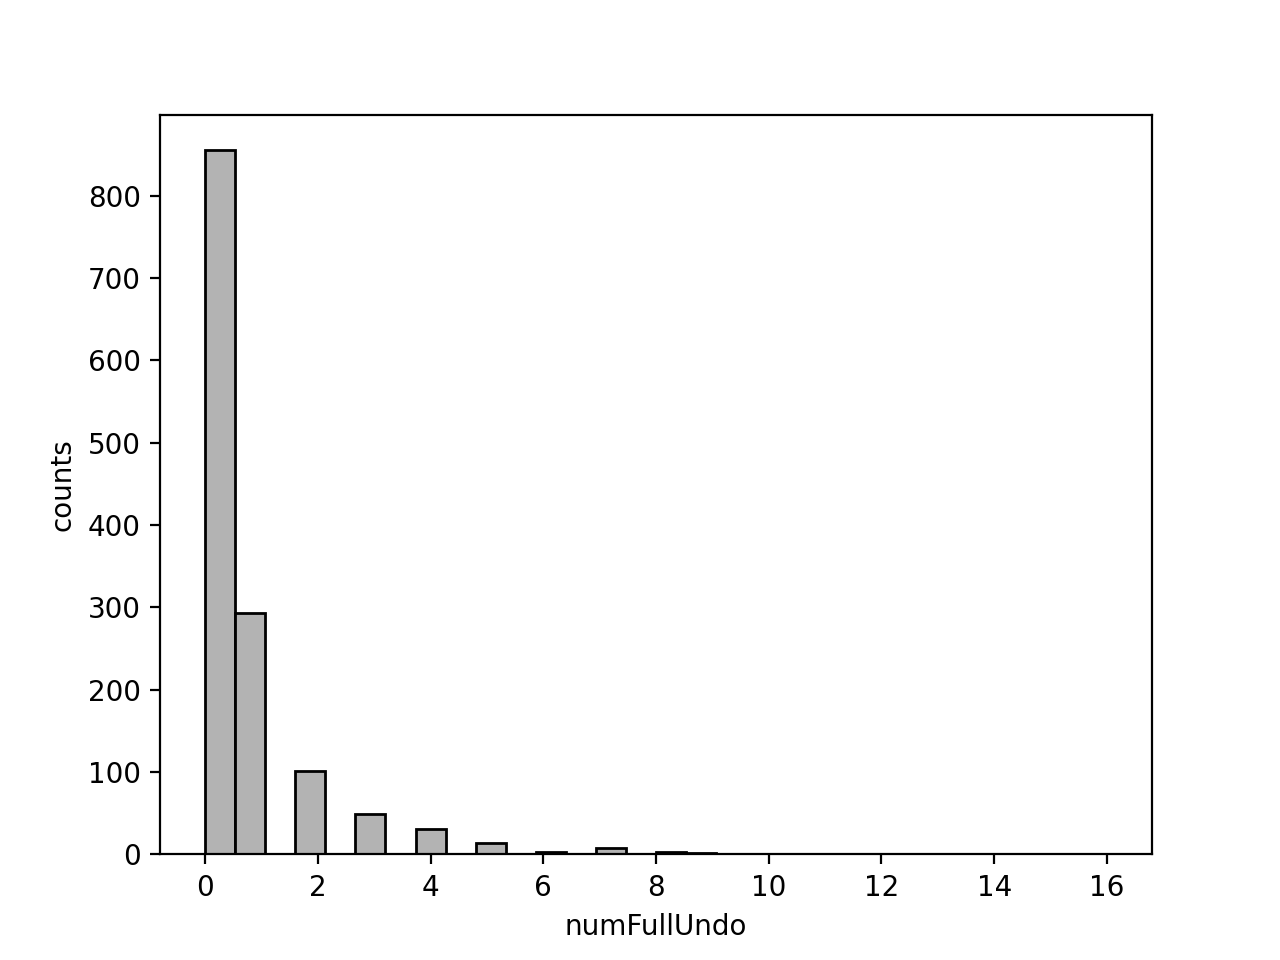

In [443]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(data_subset4.numFullUndo, bins = 30,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('numFullUndo') 
plt.show()

In [444]:
%%R -i data_subset4

data_subset4$subjects <- as.factor(data_subset4[,"subjects"])
model_numError3 = lme4::glmer(numFullUndo ~  1 + logRT_branching + (1 |subjects),
                                  data = data_subset4, family = "poisson")

# get the coefficients for the best fitting model
summary(model_numError3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: numFullUndo ~ 1 + logRT_branching + (1 | subjects)
   Data: data_subset4

     AIC      BIC   logLik deviance df.resid 
  2869.7   2885.3  -1431.8   2863.7     1359 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8990 -0.6203 -0.3150  0.2214  8.0548 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.64     1.281   
Number of obs: 1362, groups:  subjects, 88

Fixed effects:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     -1.3720732  0.0007633 -1797.65   <2e-16 ***
logRT_branching  0.0333251  0.0007653    43.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lgRT_brnchn 0.000 
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.092108 (tol = 0.002, component 1)
Mode